In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [1]:
#Activate operating system interfacing with JupyterLab
import os

In [2]:
#Change path name in function below to top-most directory containing data
    # 1) filtered_assignments.csv from centroid_mapping.ipynb
    # 2) rabies barcode count matrices from process_rabies_barcodes.sh
    # 3) helper barcode count matrices from process_counts.sh

os.chdir('/Users/maddieurbanek/Desktop/revision_data/resubmission/data/')

In [3]:
#For module versions, see requirements.txt on Github (LINK TO REFRESHED GITHUB)
import seaborn as sns
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import ast
import networkx as nx
from scipy import stats
import scipy
import math
import time
import upsetplot
from matplotlib.ticker import PercentFormatter

plt.rc('font', family='Arial')

In [4]:
#THIS IS POINTING TO LOG1P FIRST NORMALIZATION
#metadata_df=pd.read_csv('./transcriptome/filtered_assignments.csv')
#THIS IS THE ONE I GENERATED WITH THE FIXED REFERENCE ATLAS ON SEP 30!!!

#THIS ONE IS WITH IKE'S CODE
metadata_df=pd.read_csv('./transcriptome/mapped_centroids.csv')
metadata_df=metadata_df.loc[metadata_df['high_score'] >0.2]
metadata_df = metadata_df.rename(columns={'type_updated': 'celltype', 'Unnamed: 0':'cellbarcode','dataset_id':'datasetid'})
metadata_df

,cellbarcode,high_score,datasetid,cbc,celltype,n_types,umap_1,umap_2
0,c1_AAAAAAAAATCGCAGA,0.416132,c1,CVS-N2c cell,EN-L4-IT,1,-4.291120,-1.398332
1,c1_AAAAAAACCCTCCCAA,0.551036,c1,CVS-N2c cell,EN-L4-IT,1,-6.856859,-1.405619
2,c1_AAAAAACAAGCTAAGC,0.541680,c1,CVS-N2c cell,EN-L4-IT,1,-5.705260,0.020503
3,c1_AAAAAAGCATGGAGGT,0.490021,c1,CVS-N2c cell,EN-L4-IT,1,-6.399585,-1.293094
4,c1_AAAAAAGTAGATCAAA,0.458501,c1,CVS-N2c cell,Astrocyte-Fibrous,1,10.384505,3.936133
...,...,...,...,...,...,...,...,...
49549,s1_CCTCCCCCAGCGATCC,0.434926,s1,SADB-19 cell,IPC-EN,1,1.393792,-0.107803
49550,s1_CCTGAGAAACCGACGC,0.457192,s1,SADB-19 cell,EN-Newborn,1,-1.639336,-2.168794
49551,s1_CCTGCCCGATGTAATT,0.484928,s1,SADB-19 cell,RG-vRG,1,10.178526,3.639504
49552,s1_CCTTATTGCATTCCCA,0.529649,s1,SADB-19 cell,EN-Newborn,1,-0.411113,-1.457353


In [5]:
#Add more metadata to sample_coords
clusters=metadata_df['celltype'].unique()

#Define broad classes
en=['EN-L5_6-NP', 'EN-L4-IT','EN-Newborn', 'EN-L2_3-IT','EN-L6b','EN-IT-Immature','EN-L5-ET',
    'EN-L6-CT', 'EN-L6-IT','EN-Non-IT-Immature','EN-L5-IT','Cajal-Retzius cell']
inh=['IN-NCx_dGE-Immature','IN-CGE-Immature','IN-MGE-SST','IN-CGE-VIP', 'IN-CGE-SNCG',
     'IN-MGE-PV','IN-Mix-LAMP5','IN-MGE-Immature']
pro=['IPC-EN','Tri-IPC']
glia=['Astrocyte-Fibrous','Microglia','OPC','Vascular','Astrocyte-Protoplasmic','RG-vRG',
      'Oligodendrocyte','Oligodendrocyte-Immature','Astrocyte-Immature','RG-tRG','RG-oRG']
unknown=['Unknown']
metadata_df['broad_class']=metadata_df['celltype'].copy()
metadata_df.loc[metadata_df['celltype'].isin(en), 'broad_class'] = 'EN'
metadata_df.loc[metadata_df['celltype'].isin(inh), 'broad_class'] = 'IN'
metadata_df.loc[metadata_df['celltype'].isin(pro), 'broad_class'] = 'IPC'
metadata_df.loc[metadata_df['celltype'].isin(glia), 'broad_class'] = 'Glia'
metadata_df.loc[metadata_df['celltype'].isin(unknown), 'broad_class'] = 'Unknown'

#Define subclasses (layer identies for excitatory neurons, types for glia, region for inhibitory)
astro=['Astrocyte-Fibrous','Astrocyte-Protoplasmic','Astrocyte-Immature']
opc=['OPC','Oligodendrocyte','Oligodendrocyte-Immature']
rgc=['RG-tRG','RG-oRG','RG-vRG']

mge=['IN-MGE-SST','IN-MGE-PV','IN-MGE-Immature']
cge=['IN-CGE-Immature','IN-CGE-VIP', 'IN-CGE-SNCG']
dge=['IN-NCx_dGE-Immature']

immature=['EN-Newborn','EN-IT-Immature','EN-Non-IT-Immature']
deep=['EN-L5_6-NP','EN-L6b','EN-L5-ET','EN-L6-CT', 'EN-L6-IT','EN-L5-IT']

metadata_df['subclass']=metadata_df['celltype'].copy()
metadata_df.loc[metadata_df['celltype'].isin(astro), 'subclass'] = 'Astrocyte'
metadata_df.loc[metadata_df['celltype'].isin(opc), 'subclass'] = 'Oligo'
metadata_df.loc[metadata_df['celltype'].isin(rgc), 'subclass'] = 'RG'
metadata_df.loc[metadata_df['celltype'].isin(pro), 'subclass'] = 'IPC'
metadata_df.loc[metadata_df['celltype'].isin(mge), 'subclass'] = 'IN-MGE'
metadata_df.loc[metadata_df['celltype'].isin(cge), 'subclass'] = 'IN-CGE'
metadata_df.loc[metadata_df['celltype'].isin(dge), 'subclass'] = 'IN-DGE'
metadata_df.loc[metadata_df['celltype'].isin(immature), 'subclass'] = 'EN-Immature'
metadata_df.loc[metadata_df['celltype'].isin(deep), 'subclass'] = 'EN-Deep Layer'

metadata_df['subclass'].unique()
metadata_df

,cellbarcode,high_score,datasetid,cbc,celltype,n_types,umap_1,umap_2,broad_class,subclass
0,c1_AAAAAAAAATCGCAGA,0.416132,c1,CVS-N2c cell,EN-L4-IT,1,-4.291120,-1.398332,EN,EN-L4-IT
1,c1_AAAAAAACCCTCCCAA,0.551036,c1,CVS-N2c cell,EN-L4-IT,1,-6.856859,-1.405619,EN,EN-L4-IT
2,c1_AAAAAACAAGCTAAGC,0.541680,c1,CVS-N2c cell,EN-L4-IT,1,-5.705260,0.020503,EN,EN-L4-IT
3,c1_AAAAAAGCATGGAGGT,0.490021,c1,CVS-N2c cell,EN-L4-IT,1,-6.399585,-1.293094,EN,EN-L4-IT
4,c1_AAAAAAGTAGATCAAA,0.458501,c1,CVS-N2c cell,Astrocyte-Fibrous,1,10.384505,3.936133,Glia,Astrocyte
...,...,...,...,...,...,...,...,...,...,...
49549,s1_CCTCCCCCAGCGATCC,0.434926,s1,SADB-19 cell,IPC-EN,1,1.393792,-0.107803,IPC,IPC
49550,s1_CCTGAGAAACCGACGC,0.457192,s1,SADB-19 cell,EN-Newborn,1,-1.639336,-2.168794,EN,EN-Immature
49551,s1_CCTGCCCGATGTAATT,0.484928,s1,SADB-19 cell,RG-vRG,1,10.178526,3.639504,Glia,RG
49552,s1_CCTTATTGCATTCCCA,0.529649,s1,SADB-19 cell,EN-Newborn,1,-0.411113,-1.457353,EN,EN-Immature


In [6]:
metadata_df=metadata_df[['cellbarcode','celltype','datasetid','broad_class','subclass']]
metadata_df

metadata_df = metadata_df[metadata_df.celltype != 'Unknown']

In [7]:
#Load in rabies count matrices

    #Rabies barcode count matrices are calculated individually for each dataset using the script rvdg_barcode_calling.sh
    #These count matrices are loaded in, assigned a matching dataset ID to the transcriptome_metadata table from above, and renamed to match those cell barcodes
    #The dataset ID for each sample is also tacked onto the front of the rabies barcode sequence to prevent barcode collision across distinct slices

s1=pd.read_table('./barcode_count_matrices/s1_completecounts.tsv',delimiter='\t')
s1['datasetid']='s1'
s1['CBC'] = s1['CBC'].str.replace("'", "")
s1['CBC'] = s1['CBC'].str.replace('b', 's1_')
s1['barcode'] = 's1_' + s1['barcode']

s2=pd.read_table('./barcode_count_matrices/s2_completecounts.tsv',delimiter='\t')
s2['datasetid']='s2'
s2['CBC'] = s2['CBC'].str.replace("'", "")
s2['CBC'] = s2['CBC'].str.replace('b', 's2_')
s2['barcode'] = 's2' + s2['barcode']

s3=pd.read_table('./barcode_count_matrices/s3_completecounts.tsv',delimiter='\t')
s3['datasetid']='s3'
s3['CBC'] = s3['CBC'].str.replace("'", "")
s3['CBC'] = s3['CBC'].str.replace('b', 's3_')
s3['barcode'] = 's3_' + s3['barcode']

s4=pd.read_table('./barcode_count_matrices/s4_completecounts.tsv',delimiter='\t')
s4['datasetid']='s4'
s4['CBC'] = s4['CBC'].str.replace("'", "")
s4['CBC'] = s4['CBC'].str.replace('b', 's4_')
s4['barcode'] = 's4_' + s4['barcode']


s5=pd.read_table('./barcode_count_matrices/s5_completecounts.tsv',delimiter='\t')
s5['datasetid']='s5'
s5['CBC'] = s5['CBC'].str.replace("'", "")
s5['CBC'] = s5['CBC'].str.replace('b', 's5_')
s5['barcode'] = 's5_' + s5['barcode']


c1=pd.read_table('./barcode_count_matrices/c1_completecounts.tsv',delimiter='\t')
c1['datasetid']='c1'
c1['CBC'] = c1['CBC'].str.replace("'", "")
c1['CBC'] = c1['CBC'].str.replace('b', 'c1_')
c1['barcode'] = 'c1_' + c1['barcode']


c2=pd.read_table('./barcode_count_matrices/c2_completecounts.tsv',delimiter='\t')
c2['datasetid']='c2'
c2['CBC'] = c2['CBC'].str.replace("'", "")
c2['CBC'] = c2['CBC'].str.replace('b', 'c2_')
c2['barcode'] = 'c2_' + c2['barcode']


n1=pd.read_table('./barcode_count_matrices/n1_completecounts.tsv',delimiter='\t')
n1['datasetid']='n1'
n1['CBC'] = n1['CBC'].str.replace("'", "")
n1['CBC'] = n1['CBC'].str.replace('b', 'n1_')
n1['barcode'] = 'n1_' + n1['barcode']


n2=pd.read_table('./barcode_count_matrices/n2_completecounts.tsv',delimiter='\t')
n2['datasetid']='n2'
n2['CBC'] = n2['CBC'].str.replace("'", "")
n2['CBC'] = n2['CBC'].str.replace('b', 'n2_')
n2['barcode'] = 'n2_' + n2['barcode']



c3=pd.read_table('./barcode_count_matrices/c3_completecounts.tsv',delimiter='\t')
c3['datasetid']='c3'
c3['CBC'] = c3['CBC'].str.replace("'", "")
c3['CBC'] = c3['CBC'].str.replace('b', 'c3_')
c3['barcode'] = 'c3_' + c3['barcode']

c4=pd.read_table('./barcode_count_matrices/c4_completecounts.tsv',delimiter='\t')
c4['datasetid']='c4'
c4['CBC'] = c4['CBC'].str.replace("'", "")
c4['CBC'] = c4['CBC'].str.replace('b', 'c4_')
c4['barcode'] = 'c4_' + c4['barcode']

n3=pd.read_table('./barcode_count_matrices/n3_completecounts.tsv',delimiter='\t')
n3['datasetid']='n3'
n3['CBC'] = n3['CBC'].str.replace("'", "")
n3['CBC'] = n3['CBC'].str.replace('b', 'n3_')
n3['barcode'] = 'n3_' + n3['barcode']

n4=pd.read_table('./barcode_count_matrices/n4_completecounts.tsv',delimiter='\t')
n4['datasetid']='n4'
n4['CBC'] = n4['CBC'].str.replace("'", "")
n4['CBC'] = n4['CBC'].str.replace('b', 'n4_')
n4['barcode'] = 'n4_' + n4['barcode']

#Final barcode matrices across all experiments are concatenated into one large dataframe
barcodes_df=pd.concat([s1,s2,s3,s4,s5,c1,c2,c3,c4,n1,n2,n3,n4], ignore_index=True, axis=0)
barcodes_df

,CBC,barcode,UMI_Count,datasetid
0,s1_CACACAGGACTAATAC,s1_AATTCAAACCCCTGGCGATGG-GATCCATTTCCCAACGGCTG-...,1,s1
1,s1_ATTGACCTCCTAAGCA,s1_AATTCAAACCCCTGGCGATGG-GATCCATTTCCCAACGGCTG-...,1,s1
2,s1_CATACCAACATTACAT,s1_AATTCAAACCCCTGGCGATGG-GATCCATTTCCCAACGGCTG-...,1,s1
3,s1_ATTGAGCCCAGCATCA,s1_AATTCAAACCCCTGGCGATGG-GATCCATTTCCCAACGGCTG-...,1,s1
4,s1_AACCCATCACAGCAGA,s1_AATTCAAACCCCTGGCGATGG-GATCCATTTCCCAACGGCTG-...,1,s1
...,...,...,...,...
44655647,n4_CCACCCTTCCGAAAAA,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4
44655648,n4_CCTCAATGACCACAGC,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4
44655649,n4_AAGGAGGGAGCAACGC,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4
44655650,n4_AGAGCAATCACGACGC,n4_AATTCTTTTGGTGCGAGCCTG-GATCTTTGCGCGAGTCACTG-...,1,n4


In [8]:
#Load in helper count matrices
    #This cell repeats the same steps as above but for helper counts rather than rabies barcodes

s1_helper=pd.read_table('./barcode_count_matrices/s1_helperindex.tsv',delimiter='\t')
s1_helper['datasetid']='s1'
s1_helper['CBC'] = s1_helper['CBC'].str.replace("'", "")
s1_helper['CBC'] = s1_helper['CBC'].str.replace('b', 's1_')

s2_helper=pd.read_table('./barcode_count_matrices/s2_helperindex.tsv',delimiter='\t')
s2_helper['datasetid']='s2'
s2_helper['CBC'] = s2_helper['CBC'].str.replace("'", "")
s2_helper['CBC'] = s2_helper['CBC'].str.replace('b', 's2_')

s3_helper=pd.read_table('./barcode_count_matrices/s3_helperindex.tsv',delimiter='\t')
s3_helper['datasetid']='s3'
s3_helper['CBC'] = s3_helper['CBC'].str.replace("'", "")
s3_helper['CBC'] = s3_helper['CBC'].str.replace('b', 's3_')

s4_helper=pd.read_table('./barcode_count_matrices/s4_helperindex.tsv',delimiter='\t')
s4_helper['datasetid']='s4'
s4_helper['CBC'] = s4_helper['CBC'].str.replace("'", "")
s4_helper['CBC'] = s4_helper['CBC'].str.replace('b', 's4_')

s5_helper=pd.read_table('./barcode_count_matrices/s5_helperindex.tsv',delimiter='\t')
s5_helper['datasetid']='s5'
s5_helper['CBC'] = s5_helper['CBC'].str.replace("'", "")
s5_helper['CBC'] = s5_helper['CBC'].str.replace('b', 's5_')

c1_helper=pd.read_table('./barcode_count_matrices/c1_helperindex.tsv',delimiter='\t')
c1_helper['datasetid']='c1'
c1_helper['CBC'] = c1_helper['CBC'].str.replace("'", "")
c1_helper['CBC'] = c1_helper['CBC'].str.replace('b', 'c1_')

c2_helper=pd.read_table('./barcode_count_matrices/c2_helperindex.tsv',delimiter='\t')
c2_helper['datasetid']='c2'
c2_helper['CBC'] = c2_helper['CBC'].str.replace("'", "")
c2_helper['CBC'] = c2_helper['CBC'].str.replace('b', 'c2_')

n1_helper=pd.read_table('./barcode_count_matrices/n1_helperindex.tsv',delimiter='\t')
n1_helper['datasetid']='n1'
n1_helper['CBC'] = n1_helper['CBC'].str.replace("'", "")
n1_helper['CBC'] = n1_helper['CBC'].str.replace('b', 'n1_')

n2_helper=pd.read_table('./barcode_count_matrices/n2_helperindex.tsv',delimiter='\t')
n2_helper['datasetid']='n2'
n2_helper['CBC'] = n2_helper['CBC'].str.replace("'", "")
n2_helper['CBC'] = n2_helper['CBC'].str.replace('b', 'n2_')


c3_helper=pd.read_table('./barcode_count_matrices/c3_helperindex.tsv',delimiter='\t')
c3_helper['datasetid']='c3'
c3_helper['CBC'] = c3_helper['CBC'].str.replace("'", "")
c3_helper['CBC'] = c3_helper['CBC'].str.replace('b', 'c3_')

c4_helper=pd.read_table('./barcode_count_matrices/c4_helperindex.tsv',delimiter='\t')
c4_helper['datasetid']='c4'
c4_helper['CBC'] = c4_helper['CBC'].str.replace("'", "")
c4_helper['CBC'] = c4_helper['CBC'].str.replace('b', 'c4_')


n3_helper=pd.read_table('./barcode_count_matrices/n3_helperindex.tsv',delimiter='\t')
n3_helper['datasetid']='n3'
n3_helper['CBC'] = n3_helper['CBC'].str.replace("'", "")
n3_helper['CBC'] = n3_helper['CBC'].str.replace('b', 'n3_')

n4_helper=pd.read_table('./barcode_count_matrices/n4_helperindex.tsv',delimiter='\t')
n4_helper['datasetid']='n4'
n4_helper['CBC'] = n4_helper['CBC'].str.replace("'", "")
n4_helper['CBC'] = n4_helper['CBC'].str.replace('b', 'n4_')

helpers_df=pd.concat([s1_helper,s2_helper,s3_helper,s4_helper,s5_helper,c1_helper,c2_helper,c3_helper,c4_helper, n1_helper,n2_helper,n3_helper,n4_helper], ignore_index=True, axis=0)
helpers_df=helpers_df[['CBC','UMI_Count','datasetid']]
helpers_df

,CBC,UMI_Count,datasetid
0,s1_ATGTCCTACAACACGC,33,s1
1,s1_CCGTCAGGAACGACTC,24,s1
2,s1_ATGTAGGTAAAGCAAG,22,s1
3,s1_AGATACATCCGCATGC,13,s1
4,s1_ACGGATGTAAGCAAAC,12,s1
...,...,...,...
49835,n4_AAACAATAACGCATCT,1,n4
49836,n4_CAAGCAGGCCGTCACT,1,n4
49837,n4_ATCGACACAAGACCCT,1,n4
49838,n4_ATTCATTTCCTACAGC,1,n4


In [9]:
#Drop any barcodes that don't map to cells passing transcriptome QC
barcodes_df = barcodes_df.loc[barcodes_df['CBC'].isin(metadata_df['cellbarcode'])].copy()

#Add barcode sequence without dataset ID
barcodes_df['barcode_sequence']=barcodes_df['barcode'].str[3:]
barcodes_df

,CBC,barcode,UMI_Count,datasetid,barcode_sequence
35,s1_CAGCATCGCACAATAT,s1_AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-...,638,s1,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...
40,s1_CCCCCACGCACAACGT,s1_AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-...,85,s1,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...
50,s1_AGTAAATTAACTATTA,s1_AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-...,48,s1,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...
78,s1_AACCACTCAGGAAATC,s1_AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-...,1,s1,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...
98,s1_AGTGAAACACGTCCGG,s1_AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-...,32,s1,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...
...,...,...,...,...,...
44655342,n4_AGGAATGAACGTAACA,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4,AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-CTA...
44655359,n4_CAGGACCGAGTACAAG,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4,AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-CTA...
44655459,n4_AAAGATTACCCGCAGG,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4,AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-CTA...
44655511,n4_AGAACAAGAATAAAGC,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4,AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-CTA...


In [10]:
#Make deep copy of barcodes_df for thresholding on
threshold_barcodes_df=barcodes_df.copy(deep=True)
threshold_barcodes_df

,CBC,barcode,UMI_Count,datasetid,barcode_sequence
35,s1_CAGCATCGCACAATAT,s1_AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-...,638,s1,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...
40,s1_CCCCCACGCACAACGT,s1_AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-...,85,s1,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...
50,s1_AGTAAATTAACTATTA,s1_AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-...,48,s1,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...
78,s1_AACCACTCAGGAAATC,s1_AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-...,1,s1,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...
98,s1_AGTGAAACACGTCCGG,s1_AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-...,32,s1,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...
...,...,...,...,...,...
44655342,n4_AGGAATGAACGTAACA,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4,AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-CTA...
44655359,n4_CAGGACCGAGTACAAG,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4,AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-CTA...
44655459,n4_AAAGATTACCCGCAGG,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4,AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-CTA...
44655511,n4_AGAACAAGAATAAAGC,n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...,1,n4,AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-CTA...


In [11]:
#Threshold helper_df on UMIs
thresholded_helpers_df=helpers_df.copy(deep=True)
thresholded_helpers_df.drop(thresholded_helpers_df[thresholded_helpers_df['UMI_Count'] < 2].index, inplace=True)

In [12]:
#Break out threshold_barcodes_df into viral library matched experiments
dataset_list=['s1','s2','s3','s4','s5']
dec_exp=threshold_barcodes_df.loc[threshold_barcodes_df['datasetid'].isin(dataset_list)]

dataset_list=['c1','c2','n1','n2','c3','c4','n3','n4']
mar_exp=threshold_barcodes_df.loc[threshold_barcodes_df['datasetid'].isin(dataset_list)]

Thresholding steps include the following:
    
    1) Drop all barcodes from experimental datasets with ≤2 UMIs within a cell
    
    2) For each barcode sequenced in viral libraries, 
    plot barcode proportion vs. number of cells with 
    that barcode across real datasets
    
    3) For barcodes missing in viral libraries but present in real experiments, 
    plot number of cells infected by each barcode
    
    4) For each barcode sequenced in viral libraries,
    plot barcode proportion vs. number of starter cells with 
    that barcode across real datasets

    5) Drop barcodes within viral libraries but and observed in 
    an excessive number of starter cells, as determined by preceding plot
    
    6) For barcodes missing in viral libraries but present in real experiments, 
    plot number of starter cells infected by each barcode

    7) Drop barcodes absent from viral libraries but observed in 
    an excessive number of starter cells, as determined by distribution in preceding plot

    8) Drop barcodes absent from viral library but observed across multiple experiments

    9) Retain barcodes that are suitably rare to result in a single starter cell infection event
    via SBARRO-based infection simulation

Each step is self-contained in the following cells, so it's possible to skip thresholding steps

In [17]:
#Viral diversity libraries are generated from sequencing the rabies genome
#Because they are the reverse complement of the sequences derived from polyA capture with Pip-seq,
#We need to make a bit key that allows us to switch between strands of barcode sequences

#The resulting dataframe is derived from our bit sequences and should have four columns
    #original=barcode number, forward orientation
    #reverse=barcode number, reverse orientation
    #original_seq=barcode sequence, forward orientation
    #reverse_seq=barcide sequence, reverse orientation

remapping_bits=pd.read_table('/Users/maddieurbanek/Desktop/revision_data/remapping_bits.csv',delimiter=',',header=None)
remapping_bits.columns=['original','reverse']
remapping_bits['original']=remapping_bits['original'].str.replace(">","")
remapping_bits['reverse']=remapping_bits['reverse'].str.replace(">","")

fragments = remapping_bits.iloc[::2]
bits = remapping_bits.iloc[1::2]
bit_key = pd.concat([fragments, bits.set_index(fragments.index)], axis = 1)
bit_key.columns=['original','reverse','original_seq','reverse_seq']

#Set original forward indexing as key
original_key=bit_key.set_index('original')
original_key

,reverse,original_seq,reverse_seq
original,,,
Fragment1_F_001,Fragment1_R_001,AATTCCATAGGGGCACAGCCG,GATCCGGCTGTGCCCCTATGG
Fragment1_F_002,Fragment1_R_002,AATTCCGATTCACATAGGGGG,GATCCCCCCTATGTGAATCGG
Fragment1_F_003,Fragment1_R_003,AATTCGCAACAATGCGCTGTG,GATCCACAGCGCATTGTTGCG
Fragment1_F_004,Fragment1_R_004,AATTCTGATGGAGTGTGTGGG,GATCCCCACACACTCCATCAG
Fragment1_F_005,Fragment1_R_005,AATTCATGTCGGATTCCGGTG,GATCCACCGGAATCCGACATG
...,...,...,...
Fragment3_F_496,Fragment3_R_496,CTAGCGCGGGCATTCAGAAC,TCGAGTTCTGAATGCCCGCG
Fragment3_F_497,Fragment3_R_497,CTAGGAGTCGCTTGTGCGTC,TCGAGACGCACAAGCGACTC
Fragment3_F_498,Fragment3_R_498,CTAGTAACGGACGGGTTGTC,TCGAGACAACCCGTCCGTTA


In [18]:
dec2023_sadb=pd.read_table('/Users/maddieurbanek/Desktop/revision_data/resubmission/data/barcode_diversity_libraries/used_in_experiments/sad_rep.csv',delimiter=',')
dec2023_sadb=dec2023_sadb[['barcode','UMI_Count']]
dec2023_sadb.columns=['viral_barcode','viral_total_UMIs']

In [19]:
#Add metrics barcode proportions and rank barcodes by prevalence
dec2023_sadb['%UMI']=(dec2023_sadb['viral_total_UMIs']/(dec2023_sadb['viral_total_UMIs'].sum()))*100
dec2023_sadb_s=dec2023_sadb.sort_values(by='%UMI',ascending=False)
dec2023_sadb=dec2023_sadb_s.reset_index()
dec2023_sadb['rank']=dec2023_sadb.index

dec2023_sadb[['bit1', 'bit2', 'bit3']] = dec2023_sadb['viral_barcode'].str.split('-', expand=True)
##I realigned these using the forward orientation of the barcodes for the reference genome, so they don't need to be reformatted
#dec2023_sadb['original_bit3'] = dec2023_sadb['bit1'].map(remapping_bits.set_index('reverse')['original'])
#dec2023_sadb['original_bit2'] = dec2023_sadb['bit2'].map(remapping_bits.set_index('reverse')['original'])
#dec2023_sadb['original_bit1'] = dec2023_sadb['bit3'].map(remapping_bits.set_index('reverse')['original'])
#dec2023_sadb['original_barcode']=dec2023_sadb['original_bit1'] + "-" + dec2023_sadb['original_bit2'] + "-" + dec2023_sadb['original_bit3']


dec2023_sadb['original_barcode']=dec2023_sadb['viral_barcode']
exp_dec2023_sadb=dec2023_sadb['original_barcode'].repeat(dec2023_sadb['viral_total_UMIs'])
exp_dec2023_sadb=pd.DataFrame(exp_dec2023_sadb)
exp_dec2023_sadb=exp_dec2023_sadb.reset_index()
exp_dec2023_sadb

,index,original_barcode
0,0,AATTCAGCTTCGCCGGGTCAG-GATCGCCCTGTCTTGTTGTG-CTA...
1,0,AATTCAGCTTCGCCGGGTCAG-GATCGCCCTGTCTTGTTGTG-CTA...
2,0,AATTCAGCTTCGCCGGGTCAG-GATCGCCCTGTCTTGTTGTG-CTA...
3,0,AATTCAGCTTCGCCGGGTCAG-GATCGCCCTGTCTTGTTGTG-CTA...
4,0,AATTCAGCTTCGCCGGGTCAG-GATCGCCCTGTCTTGTTGTG-CTA...
...,...,...
832189540,2672494,AATTCGTCAGTCGACACCCTG-GATCCCTGCCCTCACTTGAG-CTA...
832189541,2672495,AATTCATCCCCACTGCATCCG-GATCCTGGTGCAGTCTTCGG-CTA...
832189542,2672496,TCGAGCGGATACCGTATTCC-CTAGCGGCTGCTTCACTAAC-GATC...
832189543,2672497,AATTCGAAACCGTGGTCCGAG-GATCGCGTCGGTGTTCCAAG-CTA...


In [20]:
#For March 2024, CVS libraries
mar2024_cvs=pd.read_table('/Users/maddieurbanek/Desktop/revision_data/resubmission/data/barcode_diversity_libraries/used_in_experiments/cvs_rep.csv',delimiter=',')
mar2024_cvs=mar2024_cvs[['barcode','UMI_Count']]
mar2024_cvs.columns=['viral_barcode','viral_total_UMIs']

#Add metrics barcode proportions and rank barcodes by prevalence
mar2024_cvs['%UMI']=(mar2024_cvs['viral_total_UMIs']/(mar2024_cvs['viral_total_UMIs'].sum()))*100
mar2024_cvs_s=mar2024_cvs.sort_values(by='%UMI',ascending=False)
mar2024_cvs=mar2024_cvs_s.reset_index()
mar2024_cvs['rank']=mar2024_cvs.index

#Formatting
mar2024_cvs[['bit1', 'bit2', 'bit3']] = mar2024_cvs['viral_barcode'].str.split('-', expand=True)
mar2024_cvs['original_bit3'] = mar2024_cvs['bit1'].map(remapping_bits.set_index('reverse')['original'])
mar2024_cvs['original_bit2'] = mar2024_cvs['bit2'].map(remapping_bits.set_index('reverse')['original'])
mar2024_cvs['original_bit1'] = mar2024_cvs['bit3'].map(remapping_bits.set_index('reverse')['original'])
mar2024_cvs['original_barcode']=mar2024_cvs['original_bit1'] + "-" + mar2024_cvs['original_bit2'] + "-" + mar2024_cvs['original_bit3']

#Expand library
exp_mar2024_cvs=mar2024_cvs['original_barcode'].repeat(mar2024_cvs['viral_total_UMIs'])
exp_mar2024_cvs=pd.DataFrame(exp_mar2024_cvs)
exp_mar2024_cvs=exp_mar2024_cvs.reset_index()
exp_mar2024_cvs

,index,original_barcode
0,0,AATTCTTTGGCGGGACGTGTG-GATCAGCTGAGTTTGCCAGG-CTA...
1,0,AATTCTTTGGCGGGACGTGTG-GATCAGCTGAGTTTGCCAGG-CTA...
2,0,AATTCTTTGGCGGGACGTGTG-GATCAGCTGAGTTTGCCAGG-CTA...
3,0,AATTCTTTGGCGGGACGTGTG-GATCAGCTGAGTTTGCCAGG-CTA...
4,0,AATTCTTTGGCGGGACGTGTG-GATCAGCTGAGTTTGCCAGG-CTA...
...,...,...
77325290,1026627,AATTCCGCTCCAGAGACAAAG-GATCGCACAGTGATGGGCAG-CTA...
77325291,1026628,AATTCACGAGCAGCAAGGAGG-GATCAGAACGGTGTGCGCAG-CTA...
77325292,1026629,AATTCGGACTGCCGTAATACG-GATCGTCGGAGTTGACGCGG-CTA...
77325293,1026630,AATTCAGCCGATAGCCTCATG-GATCAATGCATCCAGGGCGG-CTA...


In [13]:
#Step 1) Drop all barcodes from experimental datasets not meeting UMI threshold

def umi_threshold(thresholded_data, #split barcode matrices
                  umi=1): #minimum number of UMIs needed per cell to pass threshold
    print('Total number of unique barcodes prior to thresholding')
    print(thresholded_data['barcode'].nunique())
    thresholded_data.drop(thresholded_data[thresholded_data['UMI_Count'] < umi].index, inplace=True)
    print()
    print('Total number of unique barcodes after thresholding')
    print(thresholded_data['barcode'].nunique())
    print()
    
    return thresholded_data

#Run UMI thresholding on default settings
dec_exp=umi_threshold(dec_exp,umi=2)
mar_exp=umi_threshold(mar_exp,umi=2)

Total number of unique barcodes prior to thresholding
5717

Total number of unique barcodes after thresholding
2971

Total number of unique barcodes prior to thresholding
66519

Total number of unique barcodes after thresholding
20247



In [14]:
#Split datasets down even further (each experimental slice)
t_s1=dec_exp.loc[(dec_exp['datasetid'] == 's1')]
t_s2=dec_exp.loc[(dec_exp['datasetid'] == 's2')]
t_s3=dec_exp.loc[(dec_exp['datasetid'] == 's3')]
t_s4=dec_exp.loc[(dec_exp['datasetid'] == 's4')]
t_s5=dec_exp.loc[(dec_exp['datasetid'] == 's5')]

t_c1=mar_exp.loc[(mar_exp['datasetid'] == 'c1')]
t_c2=mar_exp.loc[(mar_exp['datasetid'] == 'c2')]
t_n1=mar_exp.loc[(mar_exp['datasetid'] == 'n1')]
t_n2=mar_exp.loc[(mar_exp['datasetid'] == 'n2')]
t_c3=mar_exp.loc[(mar_exp['datasetid'] == 'c3')]
t_c4=mar_exp.loc[(mar_exp['datasetid'] == 'c4')]
t_n3=mar_exp.loc[(mar_exp['datasetid'] == 'n3')]
t_n4=mar_exp.loc[(mar_exp['datasetid'] == 'n4')]

In [ ]:
#Step 9) Single starter infection modeling using SBARRO strategy

In [ ]:
#Steps for this
    #1) For each experiment create a distribution of VBC drawing simulations (n=10, with replacement) required to match VBCs observed in at least 2 cells in the experiment
        #How many library draws does it take to match the number of unique bcs present in each experiment 
    #2) The median value (perhaps of each barcode) from step 1 is set as the founder infection estimates for each experiment
    #3) For each barcode, calculate its FI score:
        #FI=log10(p)/log10(1-f)
        #p=probability of avoiding a second founder infection (from simulations???)
            #p just set to 0.9 for single cell infections? probably should be based on no G data???
        #f=frequency in viral diversity library
    #4) Retain barcode sets where FI trust score > FI estimates (step 2)

#The “FI trust” score equates to the number of spreading founder infections that could in 
#theory occur for that VBC or VBC set before a second founder infection was expected (at 
#a given probability) by leveraging library VBC frequencies:

In [15]:
#Build SBARRO function
#Arguments:
    #sample_dataset=barcode count matrix of transcriptome-passing, UMI thresholded cells
    #viral_library=diversity library that matchces the rabies used to infect the slice, expanded for
    #line per barcode UMI
    #bootstraps=number of iterations for infection simulations

    #This function calculates the total number of draws from the viral barcode library needed to match
    #the total number of unique barcodes observed in at least 2 cells in each experiment 
def calculate_fi_trust(sample_dataset, viral_library, bootstraps):
    starttime = time.time()
    print('Calculating Founder Infection Trust Threshold')
    #Get total number of unique barcodes observed in the slice
    dup_counts=sample_dataset['barcode'].value_counts().reset_index()
    dup_counts.drop(dup_counts[dup_counts['count'] < 2].index, inplace=True)
    total_obs_bc=dup_counts['barcode'].nunique()
    print('Total number of unique barcodes detected in ≥2 cells per slice:')
    print(total_obs_bc)
    #Make dataframe to store pulled viral barcodes from simulation
    
    print('Beginning VBC draws')
    #Make empty array to send FI trust bootstrapped values for calculating median
    fi_trust=[]

    #Bootstrap FI trust score by simulating barcode draws until the same amount of unique barcodes as observed n the original dataset are found 
    for i in range(0, bootstraps):
        exit_signal = 0
        pulled_vbc=pd.DataFrame(columns=['original_barcode'])
        while exit_signal !=1 :
            acquired_vbc=(np.random.choice(viral_library['original_barcode'],1,replace=True))
            acquired_vbc=pd.DataFrame(acquired_vbc)
            #acquired_vbc.reset_index()
            acquired_vbc.columns=['original_barcode']
            pulled_vbc=pd.concat([pulled_vbc,acquired_vbc],ignore_index=True,axis=0)
            if pulled_vbc['original_barcode'].nunique()<total_obs_bc:
                exit_signal=0
            else:
                fi_rep=len(pulled_vbc)
                fi_trust = np.append(fi_trust, fi_rep)
                exit_signal = 1
    
    print('Done calculating FI Trust Threshold! :)')
    print(fi_trust)
    fi_trust_score=np.median(fi_trust)
    print('FI Trust Threshold=')
    print(fi_trust_score)
    print()
    print('This took...')
    endtime = time.time()
    print(endtime-starttime)
    print('seconds!')
    print()
    
    return fi_trust_score

In [21]:
#Calculate FI trust score threshold for each dataset 
#Bootstrapping 10 times
np.random.seed(13)

t_s1_fi_trust=calculate_fi_trust(t_s1, exp_dec2023_sadb, 10)
t_s2_fi_trust=calculate_fi_trust(t_s2, exp_dec2023_sadb, 10)
t_s3_fi_trust=calculate_fi_trust(t_s3, exp_dec2023_sadb, 10)
t_s4_fi_trust=calculate_fi_trust(t_s4, exp_dec2023_sadb, 10)
t_s5_fi_trust=calculate_fi_trust(t_s5, exp_dec2023_sadb, 10)

t_c1_fi_trust=calculate_fi_trust(t_c1, exp_mar2024_cvs, 10)
t_c2_fi_trust=calculate_fi_trust(t_c2, exp_mar2024_cvs, 10)
t_n1_fi_trust=calculate_fi_trust(t_n1, exp_mar2024_cvs, 10)
t_n2_fi_trust=calculate_fi_trust(t_n2, exp_mar2024_cvs, 10)

t_c3_fi_trust=calculate_fi_trust(t_c3, exp_mar2024_cvs, 10)
t_c4_fi_trust=calculate_fi_trust(t_c4, exp_mar2024_cvs, 10)
t_n3_fi_trust=calculate_fi_trust(t_n3, exp_mar2024_cvs, 10)
t_n4_fi_trust=calculate_fi_trust(t_n4, exp_mar2024_cvs, 10)

Calculating Founder Infection Trust Threshold
Total number of unique barcodes detected in ≥2 cells per slice:
357
Beginning VBC draws
Done calculating FI Trust Threshold! :)
[358. 357. 358. 357. 357. 357. 358. 357. 358. 358.]
FI Trust Threshold=
357.5

This took...
0.6545169353485107
seconds!

Calculating Founder Infection Trust Threshold
Total number of unique barcodes detected in ≥2 cells per slice:
66
Beginning VBC draws
Done calculating FI Trust Threshold! :)
[66. 66. 66. 67. 66. 66. 66. 66. 66. 66.]
FI Trust Threshold=
66.0

This took...
0.13162016868591309
seconds!

Calculating Founder Infection Trust Threshold
Total number of unique barcodes detected in ≥2 cells per slice:
377
Beginning VBC draws
Done calculating FI Trust Threshold! :)
[377. 378. 377. 377. 377. 377. 377. 377. 377. 377.]
FI Trust Threshold=
377.0

This took...
0.6713972091674805
seconds!

Calculating Founder Infection Trust Threshold
Total number of unique barcodes detected in ≥2 cells per slice:
779
Beginning VB

In [22]:
#Calculate FI Trust score for each viral barcode
#December 2023, SADB19
dec2023_sadb['vbc_proportion']=dec2023_sadb['viral_total_UMIs']/(dec2023_sadb['viral_total_UMIs'].sum())
dec2023_sadb['p = 0.9'] = np.log10(0.9)/(np.log10(1-dec2023_sadb['vbc_proportion']))
dec2023_sadb['p = 0.925'] = np.log10(0.925)/(np.log10(1-dec2023_sadb['vbc_proportion']))
dec2023_sadb['p = 0.95'] = np.log10(0.95)/(np.log10(1-dec2023_sadb['vbc_proportion']))
dec2023_sadb['p = 0.975'] = np.log10(0.975)/(np.log10(1-dec2023_sadb['vbc_proportion']))
dec2023_sadb['p = 0.99'] = np.log10(0.99)/(np.log10(1-dec2023_sadb['vbc_proportion']))

#March 2024, CVS
mar2024_cvs['vbc_proportion']=mar2024_cvs['viral_total_UMIs']/(mar2024_cvs['viral_total_UMIs'].sum())
mar2024_cvs['p = 0.9'] = np.log10(0.9)/(np.log10(1-mar2024_cvs['vbc_proportion']))
mar2024_cvs['p = 0.925'] = np.log10(0.925)/(np.log10(1-mar2024_cvs['vbc_proportion']))
mar2024_cvs['p = 0.95'] = np.log10(0.95)/(np.log10(1-mar2024_cvs['vbc_proportion']))
mar2024_cvs['p = 0.975'] = np.log10(0.975)/(np.log10(1-mar2024_cvs['vbc_proportion']))
mar2024_cvs['p = 0.99'] = np.log10(0.99)/(np.log10(1-mar2024_cvs['vbc_proportion']))


In [ ]:
#Plot individual barcodes versus whole sample library threshold
#December 2023, SADB19
plt.plot((dec2023_sadb['rank']),dec2023_sadb['p = 0.9'], label='p = 0.9', color = 'royalblue',linewidth=1.5)
plt.plot((dec2023_sadb['rank']),dec2023_sadb['p = 0.925'], label='p = 0.925', color = 'mediumseagreen',linewidth=1.5)
plt.plot((dec2023_sadb['rank']),dec2023_sadb['p = 0.95'], label='p = 0.95', color = 'darkkhaki',linewidth=1.5)
plt.plot((dec2023_sadb['rank']),dec2023_sadb['p = 0.975'], label='p = 0.975', color = 'sandybrown',linewidth=1.5)
plt.plot((dec2023_sadb['rank']),dec2023_sadb['p = 0.99'], label='p = 0.99', color = 'firebrick',linewidth=1.5)

plt.xlabel("Log10(Barcode Rank)")
plt.ylabel("FI Trust Score")
plt.title("December 2023, SADB19")
plt.axhline(y=t_s1_fi_trust, color='black', linestyle='solid',label="S1 FI Threshold")
plt.axhline(y=t_s2_fi_trust, color='black',linestyle='dotted',label="S2 FI Threshold")
plt.axhline(y=t_s3_fi_trust, color='black',linestyle='dashed',label="S3 FI Threshold")
plt.axhline(y=t_s4_fi_trust, color='black',linestyle='dashdot',label="S4 FI Threshold")
plt.axhline(y=t_s5_fi_trust, color='black',linestyle=(0,(3,5,1,5,1,5)),label="S5 FI Threshold")
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='upper left')
plt.draw()
plt.savefig("../figs/sfig_conn/sadb_sbarro.pdf",bbox_inches='tight', format='pdf')
plt.show()

In [ ]:
plt.plot((mar2024_cvs['rank']),mar2024_cvs['p = 0.9'], label='p = 0.9', color = 'royalblue',linewidth=1.5)
plt.plot((mar2024_cvs['rank']),mar2024_cvs['p = 0.925'], label='p = 0.925', color = 'mediumseagreen',linewidth=1.5)
plt.plot((mar2024_cvs['rank']),mar2024_cvs['p = 0.95'], label='p = 0.95', color = 'darkkhaki',linewidth=1.5)
plt.plot((mar2024_cvs['rank']),mar2024_cvs['p = 0.975'], label='p = 0.975', color = 'sandybrown',linewidth=1.5)
plt.plot((mar2024_cvs['rank']),mar2024_cvs['p = 0.99'], label='p = 0.99', color = 'firebrick',linewidth=1.5)

plt.xlabel("Log10(Barcode Rank)")
plt.ylabel("FI Trust Score")
plt.title("March 2024, CVS-N2c")
plt.axhline(y=t_c1_fi_trust, color='black',linestyle='solid',label="C1 FI Threshold")
plt.axhline(y=t_c2_fi_trust, color='black',linestyle='dotted',label="C2 FI Threshold")
plt.axhline(y=t_c3_fi_trust, color='black',linestyle='dashed',label="C3 FI Threshold")
plt.axhline(y=t_c4_fi_trust, color='black',linestyle='dashdot',label="C4 FI Threshold")
plt.axhline(y=t_n1_fi_trust, color='grey',linestyle='solid',label="N1 FI Threshold")
plt.axhline(y=t_n2_fi_trust, color='grey',linestyle='dotted',label="N2 FI Threshold")
plt.axhline(y=t_n3_fi_trust, color='grey',linestyle='dashed',label="N3 FI Threshold")
plt.axhline(y=t_n4_fi_trust, color='grey',linestyle='dashdot',label="N4 FI Threshold")
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='upper left')
plt.draw()
plt.savefig("../figs/sfig_conn/cvsb_sbarro.pdf",bbox_inches='tight', format='pdf')
plt.show()

In [24]:
#Make function for thresholding fi trust score by dataset
#Experimental library should be 

#Start by printing the total number of unique barcodes in the dataset
#So throw out any barcodes that fall below threshold point...threshold point comes from c1_fi_trust
#Pull all viral_library['original_barcode'] where p column > threshold
#Retain all barcodes from experimental library that are found in the original barcode list
#Return fi_thresholded dataframe
#Report back how many barcodes were lost to thresholding


def threshold_fi_trust(experimental_library, experimental_trust_score, p, viral_library):
    print('Thresholding experimental dataset based on FI trust scores')
    print('Total number of unique barcodes from experimental dataset:')
    print(experimental_library['barcode'].nunique())
    print(f'Thresholding on p = {p}')

    #Make new column in experimental library that includes barcode w/o dataset it
    experimental_library['barcode_no_id']=experimental_library['barcode'].str[3:]
    
    #Make list of barcodes that aren't meeting the threshold (lower FI trust score than experimental simulation)
    threshold_viral=viral_library[['original_barcode',f'p = {p}']]
    threshold_viral.drop(threshold_viral[threshold_viral[f'p = {p}'] > experimental_trust_score].index, inplace=True)

    thresholded_library=experimental_library.loc[~(experimental_library['barcode_no_id'].isin(threshold_viral['original_barcode']))]

    print('Total number of unique barcodes retained after thresholding on FI trust scores:')
    print(thresholded_library['barcode'].nunique())
    print('Percentage of barcodes retained:')
    print(thresholded_library['barcode'].nunique()/experimental_library['barcode'].nunique()*100)

    return thresholded_library

In [25]:
#Run FI Trust thresholding function from above
sbarro_threshold=0.9

#December 2023 datasets
t_s1=threshold_fi_trust(t_s1, t_s1_fi_trust, sbarro_threshold, dec2023_sadb)
t_s2=threshold_fi_trust(t_s2, t_s2_fi_trust, sbarro_threshold, dec2023_sadb)
t_s3=threshold_fi_trust(t_s3, t_s3_fi_trust, sbarro_threshold, dec2023_sadb)
t_s4=threshold_fi_trust(t_s4, t_s4_fi_trust, sbarro_threshold, dec2023_sadb)
t_s5=threshold_fi_trust(t_s5, t_s5_fi_trust, sbarro_threshold, dec2023_sadb)

#March 2024 datasets
t_c1=threshold_fi_trust(t_c1, t_c1_fi_trust, sbarro_threshold, mar2024_cvs)
t_c2=threshold_fi_trust(t_c2, t_c2_fi_trust, sbarro_threshold, mar2024_cvs)

t_n1=threshold_fi_trust(t_n1, t_n1_fi_trust, sbarro_threshold, mar2024_cvs)
t_n2=threshold_fi_trust(t_n2, t_n2_fi_trust, sbarro_threshold, mar2024_cvs)

t_c3=threshold_fi_trust(t_c3, t_c1_fi_trust, sbarro_threshold, mar2024_cvs)
t_c4=threshold_fi_trust(t_c4, t_c2_fi_trust, sbarro_threshold, mar2024_cvs)

t_n3=threshold_fi_trust(t_n3, t_n1_fi_trust, sbarro_threshold, mar2024_cvs)
t_n4=threshold_fi_trust(t_n4, t_n2_fi_trust, sbarro_threshold, mar2024_cvs)

Thresholding experimental dataset based on FI trust scores
Total number of unique barcodes from experimental dataset:
429
Thresholding on p = 0.9
Total number of unique barcodes retained after thresholding on FI trust scores:
429
Percentage of barcodes retained:
100.0
Thresholding experimental dataset based on FI trust scores
Total number of unique barcodes from experimental dataset:
79
Thresholding on p = 0.9
Total number of unique barcodes retained after thresholding on FI trust scores:
79
Percentage of barcodes retained:
100.0
Thresholding experimental dataset based on FI trust scores
Total number of unique barcodes from experimental dataset:
492
Thresholding on p = 0.9
Total number of unique barcodes retained after thresholding on FI trust scores:
492
Percentage of barcodes retained:
100.0
Thresholding experimental dataset based on FI trust scores
Total number of unique barcodes from experimental dataset:
1075
Thresholding on p = 0.9
Total number of unique barcodes retained after t

In [ ]:
plt.figure(figsize=(8, 1))
s1_overlap=dec2023_sadb[dec2023_sadb['original_barcode'].isin(t_s1['barcode_sequence'])]
s2_overlap=dec2023_sadb[dec2023_sadb['original_barcode'].isin(t_s2['barcode_sequence'])]
s3_overlap=dec2023_sadb[dec2023_sadb['original_barcode'].isin(t_s3['barcode_sequence'])]
s4_overlap=dec2023_sadb[dec2023_sadb['original_barcode'].isin(t_s4['barcode_sequence'])]
s5_overlap=dec2023_sadb[dec2023_sadb['original_barcode'].isin(t_s5['barcode_sequence'])]

plt.scatter(np.log10(dec2023_sadb['rank']),dec2023_sadb['%UMI'],color = 'lightgrey',linewidth=1.5,alpha=1)
plt.scatter(np.log10(s1_overlap['rank']),s1_overlap['%UMI'],label = "S1",color = 'green',linewidth=1.5,marker=',',s=2)
plt.scatter(np.log10(s2_overlap['rank']),s2_overlap['%UMI'],label = "S2",color = 'blue',linewidth=1.5,marker=',',s=2)
plt.scatter(np.log10(s3_overlap['rank']),s3_overlap['%UMI'],label = "S3",color = 'indigo',linewidth=1.5,marker=',',s=2)
plt.scatter(np.log10(s4_overlap['rank']),s4_overlap['%UMI'],label = "S4",color = 'orange',linewidth=1.5,marker=',',s=2)
plt.scatter(np.log10(s5_overlap['rank']),s5_overlap['%UMI'],label = "S5",color = 'red',linewidth=1.5,marker=',',s=2)

plt.xlabel("Log10(Barcode Rank)")
plt.ylabel("%UMI")
#plt.yscale('log')
plt.draw()
plt.savefig("../figs/sfig_conn/present_barcodes_sadb.png",bbox_inches='tight', format='png', dpi=500)
plt.show()

In [ ]:
plt.figure(figsize=(8, 1))
c1_overlap=mar2024_cvs[mar2024_cvs['original_barcode'].isin(t_c1['barcode_sequence'])]
c2_overlap=mar2024_cvs[mar2024_cvs['original_barcode'].isin(t_c2['barcode_sequence'])]
c3_overlap=mar2024_cvs[mar2024_cvs['original_barcode'].isin(t_c3['barcode_sequence'])]
c4_overlap=mar2024_cvs[mar2024_cvs['original_barcode'].isin(t_c4['barcode_sequence'])]

plt.scatter(np.log10(mar2024_cvs['rank']),mar2024_cvs['%UMI'],color = 'lightgrey',linewidth=1.5,alpha=1)
plt.scatter(np.log10(c1_overlap['rank']),c1_overlap['%UMI'],label = "C1",color = 'green',linewidth=1.5,marker=',',s=2)
plt.scatter(np.log10(c2_overlap['rank']),c2_overlap['%UMI'],label = "C2",color = 'blue',linewidth=1.5,marker=',',s=2)
plt.scatter(np.log10(c3_overlap['rank']),c3_overlap['%UMI'],label = "C3",color = 'indigo',linewidth=1.5,marker=',',s=2)
plt.scatter(np.log10(c4_overlap['rank']),c4_overlap['%UMI'],label = "C4",color = 'red',linewidth=1.5,marker=',',s=2)

plt.xlabel("Log10(Barcode Rank)")
plt.ylabel("%UMI")
#plt.yscale('log')
plt.draw()
plt.savefig("../figs/sfig_conn/present_barcodes_cvs_cell.png",bbox_inches='tight', format='png', dpi=500)
plt.show()

In [ ]:
plt.figure(figsize=(8, 1))
n1_overlap=mar2024_cvs[mar2024_cvs['original_barcode'].isin(t_n1['barcode_sequence'])]
n2_overlap=mar2024_cvs[mar2024_cvs['original_barcode'].isin(t_n2['barcode_sequence'])]
n3_overlap=mar2024_cvs[mar2024_cvs['original_barcode'].isin(t_n3['barcode_sequence'])]
n4_overlap=mar2024_cvs[mar2024_cvs['original_barcode'].isin(t_n4['barcode_sequence'])]

plt.scatter(np.log10(mar2024_cvs['rank']),mar2024_cvs['%UMI'],color = 'lightgrey',linewidth=1.5,alpha=1)
plt.scatter(np.log10(n1_overlap['rank']),n1_overlap['%UMI'],label = "N1",color = 'green',linewidth=1.5,marker=',',s=2)
plt.scatter(np.log10(n2_overlap['rank']),n2_overlap['%UMI'],label = "N2",color = 'blue',linewidth=1.5,marker=',',s=2)
plt.scatter(np.log10(n3_overlap['rank']),n3_overlap['%UMI'],label = "N3",color = 'indigo',linewidth=1.5,marker=',',s=2)
plt.scatter(np.log10(n4_overlap['rank']),n4_overlap['%UMI'],label = "N4",color = 'red',linewidth=1.5,marker=',',s=2)

plt.xlabel("Log10(Barcode Rank)")
plt.ylabel("%UMI")
#plt.yscale('log')
plt.draw()
plt.savefig("../figs/sfig_conn/present_barcodes_cvs_nuc.png",bbox_inches='tight', format='png', dpi=500)
plt.show()

In [26]:
#Reconcatenate separated dataframes into viral split dataframes
dec_exp=pd.concat([t_s1,
                   t_s2,
                   t_s3,
                   t_s4,
                   t_s5],
                  ignore_index=True, axis=0)

mar_exp=pd.concat([t_c1,
                   t_c2,
                   t_n1,
                   t_n2,
                  t_c3,
                   t_c4,
                   t_n3,
                   t_n4],
                  ignore_index=True, axis=0)


In [ ]:
#Post thresholding, concatenate all thresholded dataframes together

In [27]:
thresholded_barcodes_df = pd.concat([dec_exp,
                                     mar_exp
                                     ],
                                    ignore_index=True, axis=0)

thresholded_barcodes_df

,CBC,barcode,UMI_Count,datasetid,barcode_sequence,barcode_no_id
0,s1_CAGCATCGCACAATAT,s1_AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-...,638,s1,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...
1,s1_CCCCCACGCACAACGT,s1_AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-...,85,s1,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...
2,s1_AGTAAATTAACTATTA,s1_AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-...,48,s1,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...
3,s1_AGTGAAACACGTCCGG,s1_AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-...,32,s1,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...
4,s1_AGTGAATGCCTTACAG,s1_AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-...,69,s1,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...
...,...,...,...,...,...,...
500250,n4_CATGAGATCAGCCCGT,n4_AATTCTTTTGGTGCGAGCCTG-GATCACCATGTCCAGTGCCG-...,3,n4,AATTCTTTTGGTGCGAGCCTG-GATCACCATGTCCAGTGCCG-CTA...,AATTCTTTTGGTGCGAGCCTG-GATCACCATGTCCAGTGCCG-CTA...
500251,n4_ACTCCACCAAGCATAA,n4_AATTCTTTTGGTGCGAGCCTG-GATCTACCAGAACTGCCCTG-...,2,n4,AATTCTTTTGGTGCGAGCCTG-GATCTACCAGAACTGCCCTG-CTA...,AATTCTTTTGGTGCGAGCCTG-GATCTACCAGAACTGCCCTG-CTA...
500252,n4_CAGCACAGCCGGAAGG,n4_AATTCTTTTGGTGCGAGCCTG-GATCTAGGCGCCACGCGTAG-...,4,n4,AATTCTTTTGGTGCGAGCCTG-GATCTAGGCGCCACGCGTAG-CTA...,AATTCTTTTGGTGCGAGCCTG-GATCTAGGCGCCACGCGTAG-CTA...
500253,n4_AGAGATGCACGAATGA,n4_AATTCTTTTGGTGCGAGCCTG-GATCTCTCGGAGCCGGGTAG-...,4,n4,AATTCTTTTGGTGCGAGCCTG-GATCTCTCGGAGCCGGGTAG-CTA...,AATTCTTTTGGTGCGAGCCTG-GATCTCTCGGAGCCGGGTAG-CTA...


In [28]:
#Print some stats
print('Number of unique barcodes pre-thresholding:')
print(barcodes_df['barcode'].nunique())
print()

print('Number of unique barcodes post-thresholding:')
print(thresholded_barcodes_df['barcode'].nunique())
print()

print('Number of cells w/ barcodes pre-thresholding:')
print(barcodes_df['CBC'].nunique())
print

print('Number of cells w/ barcodes post-thresholding:')
print(thresholded_barcodes_df['CBC'].nunique())
print()

Number of unique barcodes pre-thresholding:
72236

Number of unique barcodes post-thresholding:
21896

Number of cells w/ barcodes pre-thresholding:
27516
Number of cells w/ barcodes post-thresholding:
26994



In [50]:
#Export thresholded matrix to local machine
thresholded_barcodes_df.to_csv('./connectivity/supplementary_table_4.csv')

### Upset Plot for thresholded barcodes

In [ ]:
#Pull barcodes passing UMI threshold in real cells
upset_input = thresholded_barcodes_df.loc[thresholded_barcodes_df['CBC'].isin(metadata_df['cellbarcode'])]

In [ ]:
#Generating input to upset plot

temp=upset_input.loc[upset_input['datasetid'] == 's1']
s1=temp['barcode_sequence'].unique().tolist()
temp=upset_input.loc[upset_input['datasetid'] == 's2']
s2=temp['barcode_sequence'].unique().tolist()
temp=upset_input.loc[upset_input['datasetid'] == 's3']
s3=temp['barcode_sequence'].unique().tolist()
temp=upset_input.loc[upset_input['datasetid'] == 's4']
s4=temp['barcode_sequence'].unique().tolist()
temp=upset_input.loc[upset_input['datasetid'] == 's5']
s5=temp['barcode_sequence'].unique().tolist()
temp=upset_input.loc[upset_input['datasetid'] == 'c1']
c1=temp['barcode_sequence'].unique().tolist()
temp=upset_input.loc[upset_input['datasetid'] == 'c2']
c2=temp['barcode_sequence'].unique().tolist()
temp=upset_input.loc[upset_input['datasetid'] == 'c3']
c3=temp['barcode_sequence'].unique().tolist()
temp=upset_input.loc[upset_input['datasetid'] == 'c4']
c4=temp['barcode_sequence'].unique().tolist()
temp=upset_input.loc[upset_input['datasetid'] == 'n1']
n1=temp['barcode_sequence'].unique().tolist()
temp=upset_input.loc[upset_input['datasetid'] == 'n2']
n2=temp['barcode_sequence'].unique().tolist()
temp=upset_input.loc[upset_input['datasetid'] == 'n3']
n3=temp['barcode_sequence'].unique().tolist()
temp=upset_input.loc[upset_input['datasetid'] == 'n4']
n4=temp['barcode_sequence'].unique().tolist()

In [ ]:
import matplotlib

In [ ]:
from upsetplot import from_contents

barcode_overlap = from_contents(
    {"s1": s1, 
     "s2": s2,
    "s3": s3,
    "s4": s4,
    "s5": s5
     }
)
from upsetplot import UpSet
from upsetplot import plot
plot(barcode_overlap, show_counts=True, subset_size="count")
from matplotlib import pyplot

matplotlib.rc('font', family='Arial')
pyplot.savefig("../figs/sfig_conn/102025_sadb19_barcode_overlap.pdf",bbox_inches='tight', format='pdf')
pyplot.show()  




barcode_overlap = from_contents(
    {"c1": c1,
     "c2": c2,
     "c3": c3,
     "c4": c4,
     "n1": n1,
     "n2": n2,
     "n3": n3,
     "n4": n4,
     }
)

plot(barcode_overlap, show_counts=True, subset_size="count")

matplotlib.rc('font', family='Arial')
pyplot.savefig("../figs/sfig_conn/cvs_barcode_overlap.pdf",bbox_inches='tight', format='pdf')
pyplot.show()  

## Connectivity Analysis

### Formatting dataframe for input into analysis

Inputs include:

    1) metadata_df that has matching cell barcodes, 
    type annotations, and datasetIDs at a minimum

    2) thresholded_barcodes_df generated above, which should
    include cell barcodes, barcode sequences, and barcode UMIs

    3) thresholded_helpers_df generated above, which should
    include cell barcodes and number of helper UMIs
    

In [29]:
#Generating process_barcodes_df
def process_barcodes_df(metadata_df,
                        feature_column, #Which column in metadata_df you're using for type annotations
                        barcodes_df, 
                        helpers_df
                       ):

    #Make a copy of the helpers_df
    startercells_df = helpers_df.copy(deep=True)

    #Add celltype metadata 
    celltype_dict = dict(zip(metadata_df['cellbarcode'],metadata_df[feature_column]))
    barcodes_df['celltypes'] = barcodes_df['CBC'].apply(lambda x: celltype_dict[x])

    #Identify barcodes in ≥2 cells
    barcodes_df['duplicate?'] = barcodes_df.duplicated(subset=['barcode'], keep=False)       

    #Assign starters
    barcodes_df['helper'] = barcodes_df.loc[:, 'CBC']
    startercells=startercells_df['CBC']
    barcodes_df.loc[barcodes_df['CBC'].isin(startercells), 'helper'] = 'starter'
    helper_umi_dict = dict(zip(helpers_df['CBC'],helpers_df['UMI_Count']))
    barcodes_df['helper_UMI_count'] = barcodes_df['CBC'].apply(lambda x: helper_umi_dict[x] if x in helper_umi_dict.keys() else 0)
    barcodes_df.loc[~barcodes_df['CBC'].isin(startercells), 'helper'] = 'nonstarter'

    #Label cells that are in single-starter networks
    starter_barcodes_df = barcodes_df.loc[barcodes_df['helper'] == 'starter'].copy()
    starter_barcodes_list = list(starter_barcodes_df.drop_duplicates('barcode')['barcode'])
    barcodes_df.loc[(barcodes_df['barcode'].isin(starter_barcodes_list)),'starter_barcode'] = 'y'
    barcodes_df.loc[~(barcodes_df['barcode'].isin(starter_barcodes_list)),'starter_barcode'] = 'n'
    starter_barcodes_df_counts = starter_barcodes_df.groupby('barcode').count()['CBC'].reset_index()
    single_starter_barcodes = list(starter_barcodes_df_counts.loc[starter_barcodes_df_counts['CBC'] == 1]['barcode'])
    barcodes_df.loc[barcodes_df['barcode'].isin(single_starter_barcodes),'single_starter_barcode'] = 'y'
    barcodes_df.loc[~(barcodes_df['barcode'].isin(single_starter_barcodes)),'single_starter_barcode'] = 'n'

    # determining and labeling nonstarter barcodes:
    nonstarter_barcodes_df = barcodes_df.loc[barcodes_df['helper'] == 'nonstarter']
    nonstarter_barcodes_list = list(nonstarter_barcodes_df.drop_duplicates('barcode')['barcode'])
    barcodes_df.loc[(barcodes_df['barcode'].isin(nonstarter_barcodes_list)),'non_starter_barcode'] = 'y'
    barcodes_df.loc[~(barcodes_df['barcode'].isin(nonstarter_barcodes_list)),'non_starter_barcode'] = 'n'
    barcodes_df.loc[(barcodes_df['non_starter_barcode'] == 'y') & (barcodes_df['starter_barcode'] == 'y'),'starter/nonstarter barcode'] = 'both'
    barcodes_df.loc[(barcodes_df['non_starter_barcode'] == 'y') & (barcodes_df['starter_barcode'] == 'n'),'starter/nonstarter barcode'] = 'nonstarter_only'
    barcodes_df.loc[(barcodes_df['non_starter_barcode'] == 'n') & (barcodes_df['starter_barcode'] == 'y'),'starter/nonstarter barcode'] = 'starter_only'
    barcodes_df.loc[(barcodes_df['non_starter_barcode'] == 'n') & (barcodes_df['starter_barcode'] == 'n'),'starter/nonstarter barcode'] = 'error'
    
    return barcodes_df

In [30]:
#Run process_barcodes_df() function on pooled datasets
processed_barcodes_df = process_barcodes_df(metadata_df,'celltype',thresholded_barcodes_df,thresholded_helpers_df)
processed_barcodes_df

,CBC,barcode,UMI_Count,datasetid,barcode_sequence,barcode_no_id,celltypes,duplicate?,helper,helper_UMI_count,starter_barcode,single_starter_barcode,non_starter_barcode,starter/nonstarter barcode
0,s1_CAGCATCGCACAATAT,s1_AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-...,638,s1,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...,EN-Newborn,True,starter,4,y,n,y,both
1,s1_CCCCCACGCACAACGT,s1_AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-...,85,s1,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...,EN-L2_3-IT,True,starter,5,y,n,y,both
2,s1_AGTAAATTAACTATTA,s1_AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-...,48,s1,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...,EN-Newborn,True,starter,5,y,n,y,both
3,s1_AGTGAAACACGTCCGG,s1_AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-...,32,s1,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...,EN-Newborn,True,nonstarter,0,y,n,y,both
4,s1_AGTGAATGCCTTACAG,s1_AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-...,69,s1,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...,EN-L2_3-IT,True,starter,5,y,n,y,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500250,n4_CATGAGATCAGCCCGT,n4_AATTCTTTTGGTGCGAGCCTG-GATCACCATGTCCAGTGCCG-...,3,n4,AATTCTTTTGGTGCGAGCCTG-GATCACCATGTCCAGTGCCG-CTA...,AATTCTTTTGGTGCGAGCCTG-GATCACCATGTCCAGTGCCG-CTA...,EN-L2_3-IT,False,nonstarter,0,n,n,y,nonstarter_only
500251,n4_ACTCCACCAAGCATAA,n4_AATTCTTTTGGTGCGAGCCTG-GATCTACCAGAACTGCCCTG-...,2,n4,AATTCTTTTGGTGCGAGCCTG-GATCTACCAGAACTGCCCTG-CTA...,AATTCTTTTGGTGCGAGCCTG-GATCTACCAGAACTGCCCTG-CTA...,Cajal-Retzius cell,False,nonstarter,0,n,n,y,nonstarter_only
500252,n4_CAGCACAGCCGGAAGG,n4_AATTCTTTTGGTGCGAGCCTG-GATCTAGGCGCCACGCGTAG-...,4,n4,AATTCTTTTGGTGCGAGCCTG-GATCTAGGCGCCACGCGTAG-CTA...,AATTCTTTTGGTGCGAGCCTG-GATCTAGGCGCCACGCGTAG-CTA...,EN-L2_3-IT,False,nonstarter,0,n,n,y,nonstarter_only
500253,n4_AGAGATGCACGAATGA,n4_AATTCTTTTGGTGCGAGCCTG-GATCTCTCGGAGCCGGGTAG-...,4,n4,AATTCTTTTGGTGCGAGCCTG-GATCTCTCGGAGCCGGGTAG-CTA...,AATTCTTTTGGTGCGAGCCTG-GATCTCTCGGAGCCGGGTAG-CTA...,Cajal-Retzius cell,False,nonstarter,0,n,n,y,nonstarter_only


In [31]:
#Any other features to add? Use a dictionary like this:

#For broad classes
feature_dict = dict(zip(metadata_df['cellbarcode'],metadata_df['broad_class']))
processed_barcodes_df['broad_class'] = processed_barcodes_df['CBC'].apply(lambda x: feature_dict[x])

#For subclasses
feature_dict = dict(zip(metadata_df['cellbarcode'],metadata_df['subclass']))
processed_barcodes_df['subclass'] = processed_barcodes_df['CBC'].apply(lambda x: feature_dict[x])

processed_barcodes_df

,CBC,barcode,UMI_Count,datasetid,barcode_sequence,barcode_no_id,celltypes,duplicate?,helper,helper_UMI_count,starter_barcode,single_starter_barcode,non_starter_barcode,starter/nonstarter barcode,broad_class,subclass
0,s1_CAGCATCGCACAATAT,s1_AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-...,638,s1,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...,EN-Newborn,True,starter,4,y,n,y,both,EN,EN-Immature
1,s1_CCCCCACGCACAACGT,s1_AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-...,85,s1,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...,EN-L2_3-IT,True,starter,5,y,n,y,both,EN,EN-L2_3-IT
2,s1_AGTAAATTAACTATTA,s1_AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-...,48,s1,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...,EN-Newborn,True,starter,5,y,n,y,both,EN,EN-Immature
3,s1_AGTGAAACACGTCCGG,s1_AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-...,32,s1,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...,EN-Newborn,True,nonstarter,0,y,n,y,both,EN,EN-Immature
4,s1_AGTGAATGCCTTACAG,s1_AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-...,69,s1,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...,AATTCAAACCCCTGGCGATGG-GATCCTCCAGAGCCTTCAGG-CTA...,EN-L2_3-IT,True,starter,5,y,n,y,both,EN,EN-L2_3-IT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500250,n4_CATGAGATCAGCCCGT,n4_AATTCTTTTGGTGCGAGCCTG-GATCACCATGTCCAGTGCCG-...,3,n4,AATTCTTTTGGTGCGAGCCTG-GATCACCATGTCCAGTGCCG-CTA...,AATTCTTTTGGTGCGAGCCTG-GATCACCATGTCCAGTGCCG-CTA...,EN-L2_3-IT,False,nonstarter,0,n,n,y,nonstarter_only,EN,EN-L2_3-IT
500251,n4_ACTCCACCAAGCATAA,n4_AATTCTTTTGGTGCGAGCCTG-GATCTACCAGAACTGCCCTG-...,2,n4,AATTCTTTTGGTGCGAGCCTG-GATCTACCAGAACTGCCCTG-CTA...,AATTCTTTTGGTGCGAGCCTG-GATCTACCAGAACTGCCCTG-CTA...,Cajal-Retzius cell,False,nonstarter,0,n,n,y,nonstarter_only,EN,Cajal-Retzius cell
500252,n4_CAGCACAGCCGGAAGG,n4_AATTCTTTTGGTGCGAGCCTG-GATCTAGGCGCCACGCGTAG-...,4,n4,AATTCTTTTGGTGCGAGCCTG-GATCTAGGCGCCACGCGTAG-CTA...,AATTCTTTTGGTGCGAGCCTG-GATCTAGGCGCCACGCGTAG-CTA...,EN-L2_3-IT,False,nonstarter,0,n,n,y,nonstarter_only,EN,EN-L2_3-IT
500253,n4_AGAGATGCACGAATGA,n4_AATTCTTTTGGTGCGAGCCTG-GATCTCTCGGAGCCGGGTAG-...,4,n4,AATTCTTTTGGTGCGAGCCTG-GATCTCTCGGAGCCGGGTAG-CTA...,AATTCTTTTGGTGCGAGCCTG-GATCTCTCGGAGCCGGGTAG-CTA...,Cajal-Retzius cell,False,nonstarter,0,n,n,y,nonstarter_only,EN,Cajal-Retzius cell


In [ ]:
#Export to look at cell type proportions
total_cells=processed_barcodes_df.drop_duplicates(subset=['CBC'])
ratios=total_cells['subclass'].value_counts()
ratios.to_csv('/Users/maddieurbanek/Desktop/revision_data/resubmission/data/connectivity/cell_type_props/umi_2.csv')

### Calculate barcode metrics for pooled datasets

In [32]:
#Determine distribution of number of starter cells across all barcode networks post UMI thresholding
processed_barcodes_df.loc[processed_barcodes_df['helper'] == 'nonstarter']
starter_df = processed_barcodes_df.loc[processed_barcodes_df['helper'] == 'starter']
starter_df.groupby('barcode').count().reset_index

df2 = processed_barcodes_df.groupby(['barcode','helper']).count()['CBC'].reset_index()
#So that starters appear first in alphabetical order
df2 = df2.sort_values('helper', ascending = False).drop_duplicates('barcode', keep = 'first')

df2.loc[df2['helper'] == 'nonstarter', 'CBC'] = 0
df2.loc[df2['helper'] == 'nonstarter', 'helper'] = 'starter'
df2.loc[df2['helper'] == 'starter', 'helper'] = 'starter'

df2.sort_values('CBC',ascending = False).rename(columns = {'CBC':'number of starter cells with barcode'})

,barcode,helper,number of starter cells with barcode
24913,s3_AATTCTGCGCTTAACCCAGGG-GATCGACCGCATCCTCTATG-...,starter,244
25738,s4_AATTCCGCTTCCGATGCCGCG-GATCCGAAGTTAGGCCGGTG-...,starter,239
24880,s3_AATTCTCGCGCTGAACAGGCG-GATCTTGCGGGTGGTTGCTG-...,starter,225
26533,s4_AATTCTCAGTGCGGTGAGGTG-GATCCGGCTTTGACGGTTCG-...,starter,221
24370,s3_AATTCCCATGAAGGGTCAAGG-GATCAGTCGCAGTGCCCGGG-...,starter,217
...,...,...,...
23063,n4_AATTCTACTTGCGCATCGACG-GATCACACCATGGGGTCATG-...,starter,0
23062,n4_AATTCTACTTGCCTCGGCAAG-GATCCAGCACGGCTGTTAGG-...,starter,0
23061,n4_AATTCTACTTGCCTCGGCAAG-GATCAAGGCCCCTGGACCAG-...,starter,0
23060,n4_AATTCTACGGCCGGACCACTG-GATCTGGCCACTAGTCAGGG-...,starter,0


In [33]:
#Determine distribution of number of cells per barcode after removing all barcodes with either no or more than 1 starter
print(len(processed_barcodes_df))
processed_barcodes_df.loc[processed_barcodes_df['single_starter_barcode'] == 'y'].groupby('barcode').count()['helper'].reset_index().rename(columns = {'helper':'number of cells with barcode'}).sort_values('number of cells with barcode',ascending = False)

500255


,barcode,number of cells with barcode
2004,c4_AATTCTCGTGGATGCCGGATG-GATCTGCACTGGTCACTCTG-...,163
3275,n3_AATTCCACTACCATACCCGGG-GATCAGCTCGGGCGGCAAGG-...,136
3313,n3_AATTCCTCCTTTGTGCCGTCG-GATCGCAATCTCGTCCTGAG-...,130
1774,c3_AATTCCAGCCATTGCCTGGGG-GATCAACAGAGCTGCAACGG-...,127
1898,c4_AATTCCGAGAGGATACTTCGG-GATCTCTACACCACTCACCG-...,125
...,...,...
1215,c2_AATTCCTATATCGGGCTGCCG-GATCTCAGAGCGCCGCTCGG-...,1
1218,c2_AATTCCTATCCACCTCATGGG-GATCTACGCTCGCAACTAGG-...,1
2892,n2_AATTCATCAGGCAAGGGTGCG-GATCCGCAAGCGAACCAATG-...,1
1220,c2_AATTCCTCAAGGCCAGACGGG-GATCGCTCCACCTGCGGTGG-...,1


In [34]:
#Determine number of unique barcodes overall
print("Number of unique rabies barcodes detected in dataset:")
processed_barcodes_df['barcode'].nunique()

Number of unique rabies barcodes detected in dataset:


21896

In [35]:
starter_count=pd.DataFrame(processed_barcodes_df.groupby('barcode').value_counts(['starter_barcode'])).reset_index()
starter_count = starter_count[starter_count.starter_barcode != 'n']
zeroes = pd.DataFrame(index=range(processed_barcodes_df['barcode'].nunique()-starter_count['barcode'].nunique()),columns=range(3))
zeroes=zeroes.fillna(0)
zeroes.columns=['barcode','starter_barcode','count']
starter_count=pd.concat([starter_count,zeroes])
starter_count.loc[starter_count['count'] > 9, 'count'] = 10

starter_count['count'].value_counts()

count
0     13782
10     4094
1      1494
2       644
3       434
4       368
5       300
6       240
7       218
8       170
9       152
Name: count, dtype: int64

In [ ]:
#Plot histogram of number of starters per barcode network:
plt.figure().set_figheight(3)

#Calculate number of starters per barcode
starter_count=pd.DataFrame(processed_barcodes_df.groupby('barcode').value_counts(['starter_barcode'])).reset_index()
starter_count = starter_count[starter_count.starter_barcode != 'n']
zeroes = pd.DataFrame(index=range(processed_barcodes_df['barcode'].nunique()-starter_count['barcode'].nunique()),columns=range(3))
zeroes=zeroes.fillna(0)
zeroes.columns=['barcode','starter_barcode','count']
starter_count=pd.concat([starter_count,zeroes])
starter_count.loc[starter_count['count'] > 9, 'count'] = 10

#Plot
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.1)  # adjust space between Axes

# plot the same data on both Axes
ax1.hist((starter_count['count']),bins=np.arange(0, 12, 1),color='forestgreen')
ax2.hist((starter_count['count']),bins=np.arange(0, 12, 1),color='forestgreen')

# zoom-in / limit the view to different portions of the data
#ax1.set_ylim(3000, 17000)  # outliers only
ax1.set_ylim(2500, 10000)  # outliers only
ax2.set_ylim(0, 1500)  # most of the data
ax1.set_xlim(0, 11)  # outliers only
ax2.set_xlim(0, 11)  # most of the data
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

plt.show()
#fig.savefig("../figs/sfig_conn/102025_starter_per_bc.pdf",bbox_inches='tight', format='pdf')
plt.show()

In [36]:
#Determine number of barcodes found in starter cells
print("Number of unique rabies barcodes detected across starter cells:")
processed_barcodes_df.loc[(processed_barcodes_df['helper'] == 'starter')]['barcode'].nunique()

Number of unique rabies barcodes detected across starter cells:


8114

In [37]:
#Determine number of barcodes NOT found in single starter cells
print("Number of unique rabies barcodes not found in single starter cells:")
processed_barcodes_df.loc[(processed_barcodes_df['single_starter_barcode'] == 'n') & (processed_barcodes_df['helper'] == 'starter')]['barcode'].nunique()

Number of unique rabies barcodes not found in single starter cells:


4109

In [38]:
#Determine number of barcodes found in single starter cells
print("Number of unique rabies barcodes found in single starter cells:")
processed_barcodes_df.loc[(processed_barcodes_df['single_starter_barcode'] == 'y')]['barcode'].nunique()

Number of unique rabies barcodes found in single starter cells:


4005

In [39]:
#Determine number of barcodes found in single starter cells and at least one non-starter cell
print("Number of unique rabies barcodes found in single starter cells + non-starter cells:")
processed_barcodes_df.loc[(processed_barcodes_df['single_starter_barcode'] == 'y') & (processed_barcodes_df['starter/nonstarter barcode'] == 'both')]['barcode'].nunique()

Number of unique rabies barcodes found in single starter cells + non-starter cells:


2511

### Identify single starter, directed networks

In [40]:
#Pull all rows that have a rabies barcode in one starter cell and appear in both starter and non-starter cells
df = processed_barcodes_df.loc[(processed_barcodes_df['single_starter_barcode'] == 'y') & (processed_barcodes_df['starter/nonstarter barcode'] == 'both')]

#Create dictionary to link cell barcodes from processed_barcodes_df to their correspondent cell types
cell_type_dict = dict(zip(df['CBC'],df['celltypes']))

#Pull starter cell populations and make sets of all their rabies barcodes
starter_df = df.loc[df['helper'] == 'starter'].groupby(['datasetid','CBC'])['barcode'].apply(set).reset_index()

#Create dictionary to link cell barcodes from starter populations to their correspondent rabies barcodes
starter_dict = dict(zip(starter_df['CBC'],starter_df['barcode']))

#Pull non-starter cell populations and make sets of all their rabies barcodes
nonstarter_df = df.loc[df['helper'] == 'nonstarter'].groupby(['CBC'])['barcode'].apply(set).reset_index()

#Create dictionary to link cell barcodes from starter populations to their correspondent rabies barcodes
nonstarter_dict = dict(zip(nonstarter_df['CBC'],nonstarter_df['barcode']))

#For each starter cell barcode identified in previous steps, get all non-starter cells that have a matching barcode
    #This step eliminates repetitive connections (ex: two cells that share three barcodes only get counted as one connection after this)
for starter in starter_dict.keys():
    
    matching_cells = []
    starter_barcode_set = starter_dict[starter]
    
    for nonstarter in nonstarter_dict.keys():
        nonstarter_barcode_set = nonstarter_dict[nonstarter]
        
        if len(starter_barcode_set.intersection(nonstarter_barcode_set))>=1:
            matching_cells.append(nonstarter)
    # print(matching_cells) 
    starter_df.loc[starter_df['CBC'] == starter, 'matching_cells'] = str(matching_cells)

starter_df['matching_cells'] = starter_df['matching_cells'].apply(ast.literal_eval)

#Annotate columns to match starter vs. non-starter assignment
starter_df.rename(columns = {'CBC':'starter CBC', 'barcode':'starter barcodes', 'matching_cells':'non-starter CBC'}, inplace = True)

#Use cell type dictionary to assign starter cell types to each starter cell barcode
starter_df['starter cell_type'] = starter_df['starter CBC'].apply(lambda x: cell_type_dict[x])

#Build input dataframe for connectivity matrix
conn_0_compiling = starter_df[['datasetid','starter cell_type','starter CBC','non-starter CBC']]

#Calculate the number of non-starters sharing a barcode with each starter cell and save to the dataframe
conn_0_compiling['number of non-starters associated'] = conn_0_compiling['non-starter CBC'].apply(lambda x: len(x))

#Calculate the number of total cells connected to a single starter cell (it should be the 'number of non-starters associated' column +1)
conn_0_compiling['number of cells in single-starter network'] = conn_0_compiling['non-starter CBC'].apply(lambda x: len(x) +1)

#Explode non-starter cell barcode sets so now each non-starter cell gets its own line in the dataframe
conn_1_compiling = starter_df.explode('non-starter CBC')

#Assign non-starter cell types based on matching dictionary entry
conn_1_compiling['non-starter cell_type'] = conn_1_compiling['non-starter CBC'].apply(lambda x: cell_type_dict[x])

#Rename columns
conn_1_compiling = conn_1_compiling[['datasetid','starter cell_type','starter CBC','non-starter cell_type','non-starter CBC']]

#Establish cell type connectivity by merging non-starter (presynaptic) to starter (postsynaptic) cell types
conn_1_compiling['conn_type'] = conn_1_compiling['non-starter cell_type'] +'+'+ conn_1_compiling['starter cell_type'] 

#Annotate the exact cell to cell connection captured
conn_1_compiling['connection'] = conn_1_compiling.apply(lambda x: (x['non-starter CBC'], x['starter CBC'], {'w':1}), axis=1)

### Thresholding on network size

In [41]:
print(conn_1_compiling)
network_count=pd.DataFrame(conn_1_compiling.groupby('starter CBC')['non-starter CBC'].nunique()).reset_index()
keep_list=network_count.loc[network_count['non-starter CBC'] < 50]
keep_list
conn_1_compiling=conn_1_compiling.loc[conn_1_compiling['starter CBC'].isin(keep_list['starter CBC'])]
conn_1_compiling

    datasetid starter cell_type          starter CBC non-starter cell_type  \
0          c1        EN-Newborn  c1_AAAAAATGCATTCAAA            EN-Newborn   
0          c1        EN-Newborn  c1_AAAAAATGCATTCAAA            EN-Newborn   
0          c1        EN-Newborn  c1_AAAAAATGCATTCAAA            EN-L2_3-IT   
0          c1        EN-Newborn  c1_AAAAAATGCATTCAAA            EN-L2_3-IT   
0          c1        EN-Newborn  c1_AAAAAATGCATTCAAA            EN-Newborn   
..        ...               ...                  ...                   ...   
829        s5        EN-Newborn  s5_CCGTAAAAATCTAACG            EN-Newborn   
830        s5        EN-Newborn  s5_CCTCAAGAATGTATAC            EN-Newborn   
830        s5        EN-Newborn  s5_CCTCAAGAATGTATAC            IN-MGE-SST   
830        s5        EN-Newborn  s5_CCTCAAGAATGTATAC            EN-L2_3-IT   
831        s5        EN-Newborn  s5_CCTGAATGACAACATC            EN-L2_3-IT   

         non-starter CBC              conn_type  \
0    c1_AAGA

,datasetid,starter cell_type,starter CBC,non-starter cell_type,non-starter CBC,conn_type,connection
0,c1,EN-Newborn,c1_AAAAAATGCATTCAAA,EN-Newborn,c1_AAGACCTAACGCCATT,EN-Newborn+EN-Newborn,"(c1_AAGACCTAACGCCATT, c1_AAAAAATGCATTCAAA, {'w..."
0,c1,EN-Newborn,c1_AAAAAATGCATTCAAA,EN-Newborn,c1_ACGCACTGCAATAATA,EN-Newborn+EN-Newborn,"(c1_ACGCACTGCAATAATA, c1_AAAAAATGCATTCAAA, {'w..."
0,c1,EN-Newborn,c1_AAAAAATGCATTCAAA,EN-L2_3-IT,c1_ACGCCCCTAGGGACAT,EN-L2_3-IT+EN-Newborn,"(c1_ACGCCCCTAGGGACAT, c1_AAAAAATGCATTCAAA, {'w..."
0,c1,EN-Newborn,c1_AAAAAATGCATTCAAA,EN-L2_3-IT,c1_AGAGATTCAGACATTC,EN-L2_3-IT+EN-Newborn,"(c1_AGAGATTCAGACATTC, c1_AAAAAATGCATTCAAA, {'w..."
0,c1,EN-Newborn,c1_AAAAAATGCATTCAAA,EN-Newborn,c1_AGGGAAGGAGGGATTC,EN-Newborn+EN-Newborn,"(c1_AGGGAAGGAGGGATTC, c1_AAAAAATGCATTCAAA, {'w..."
...,...,...,...,...,...,...,...
829,s5,EN-Newborn,s5_CCGTAAAAATCTAACG,EN-Newborn,s5_CACTACAGCCAAACAC,EN-Newborn+EN-Newborn,"(s5_CACTACAGCCAAACAC, s5_CCGTAAAAATCTAACG, {'w..."
830,s5,EN-Newborn,s5_CCTCAAGAATGTATAC,EN-Newborn,s5_ACTAACGGCAAACCCA,EN-Newborn+EN-Newborn,"(s5_ACTAACGGCAAACCCA, s5_CCTCAAGAATGTATAC, {'w..."
830,s5,EN-Newborn,s5_CCTCAAGAATGTATAC,IN-MGE-SST,s5_AGCAAGGTAGTCCACG,IN-MGE-SST+EN-Newborn,"(s5_AGCAAGGTAGTCCACG, s5_CCTCAAGAATGTATAC, {'w..."
830,s5,EN-Newborn,s5_CCTCAAGAATGTATAC,EN-L2_3-IT,s5_CCACATACACGCAAAC,EN-L2_3-IT+EN-Newborn,"(s5_CCACATACACGCAAAC, s5_CCTCAAGAATGTATAC, {'w..."


### Thresholding on duplicate connections

In [34]:
#Check distribution of number of barcodes per connection 
single_starter_network = processed_barcodes_df.loc[(processed_barcodes_df['single_starter_barcode'] == 'y') & (processed_barcodes_df['starter/nonstarter barcode'] == 'both')]
single_starter_network

bc_per_connection=pd.DataFrame()
barcodes=single_starter_network['barcode'].unique()

for i in barcodes:
    temp=single_starter_network.loc[single_starter_network['barcode'] == i]
    starter=pd.DataFrame(temp.loc[temp['helper'] == 'starter', 'CBC'])
    starter.columns=['starter']
    nonstarter=pd.DataFrame(temp.loc[temp['helper'] == 'nonstarter', 'CBC'])
    nonstarter.columns=['nonstarter']
    for n in starter['starter'].unique():
        nonstarter['starter']=n
    nonstarter['connection']=nonstarter['nonstarter'] + "+" +nonstarter['starter']
    bc_per_connection=pd.concat([bc_per_connection,nonstarter])

bc_per_connection


,nonstarter,starter,connection
258,s1_CACAATTCAACAAGTC,s1_CCGTCAGGAACGACTC,s1_CACAATTCAACAAGTC+s1_CCGTCAGGAACGACTC
260,s1_ACACACCTCCGACATT,s1_CCGTCAGGAACGACTC,s1_ACACACCTCCGACATT+s1_CCGTCAGGAACGACTC
1089,s1_AATTAAAGCCAAACAG,s1_CCGTCAGGAACGACTC,s1_AATTAAAGCCAAACAG+s1_CCGTCAGGAACGACTC
5573,s1_CACAATTCAACAAGTC,s1_CCGTCAGGAACGACTC,s1_CACAATTCAACAAGTC+s1_CCGTCAGGAACGACTC
10438,s1_ACATAACAATTACCAG,s1_CACGATTGACGCAAAG,s1_ACATAACAATTACCAG+s1_CACGATTGACGCAAAG
...,...,...,...
500189,n4_ATATATCACATCACTC,n4_ACTCAACACAATCAGC,n4_ATATATCACATCACTC+n4_ACTCAACACAATCAGC
500190,n4_CACTAACGATTAACTA,n4_ACTCAACACAATCAGC,n4_CACTAACGATTAACTA+n4_ACTCAACACAATCAGC
500191,n4_CATTACGTCCGTAAAA,n4_ACTCAACACAATCAGC,n4_CATTACGTCCGTAAAA+n4_ACTCAACACAATCAGC
500219,n4_CATGCCTGAACCCCCC,n4_ACAGACTGCCGCAAGA,n4_CATGCCTGAACCCCCC+n4_ACAGACTGCCGCAAGA


In [35]:
bc_per_connection['connection'].nunique()
bc_counts=pd.DataFrame(bc_per_connection['connection'].value_counts())
bc_counts

,count
connection,
n4_ACTACCGCACTAAATT+n4_ACAGACTGCCGCAAGA,13
n4_AATCATACATTCAAGC+n4_ACAGACTGCCGCAAGA,13
n4_ACCCCCCTATGTAAAT+n4_ACAGACTGCCGCAAGA,12
n4_ATAAACTGCCGCAAGA+n4_ACAGACTGCCGCAAGA,10
n4_CCCCAGAACCAGAGAA+n4_ACAGACTGCCGCAAGA,8
...,...
c2_ATCCCCGGCCCGACGA+c2_AATGATAAACGACCCC,1
c2_ATTAAAGTAAGGAGGT+c2_AATGATAAACGACCCC,1
c2_CCTGACGGATCGAGAC+c2_AATGATAAACGACCCC,1


In [ ]:
plt.figure().set_figheight(5)
plt.hist(bc_counts['count'],bins=np.arange(0,bc_counts['count'].max() + 1.5, 1),alpha=0.7,weights=np.ones(len(bc_counts['count'])) / len(bc_counts['count']))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Barcodes per connection')
#plt.ylabel('Frequency')
#plt.xlim([-1, 100])
#plt.ylim([0,100])
#plt.yscale('log')
plt.legend()
#plt.title('UMIs per Barcode:CBC Combo')
plt.savefig('../figs/sfig_conn/barcodes_per_connection_1.svg', bbox_inches = 'tight', format = 'svg')
plt.show()

In [40]:
conn_1_compiling

,datasetid,starter cell_type,starter CBC,non-starter cell_type,non-starter CBC,conn_type,connection
0,c1,EN-Newborn,c1_AAAAAATGCATTCAAA,EN-Newborn,c1_AAGACCTAACGCCATT,EN-Newborn+EN-Newborn,"(c1_AAGACCTAACGCCATT, c1_AAAAAATGCATTCAAA, {'w..."
0,c1,EN-Newborn,c1_AAAAAATGCATTCAAA,EN-Newborn,c1_ACGCACTGCAATAATA,EN-Newborn+EN-Newborn,"(c1_ACGCACTGCAATAATA, c1_AAAAAATGCATTCAAA, {'w..."
0,c1,EN-Newborn,c1_AAAAAATGCATTCAAA,EN-L2_3-IT,c1_ACGCCCCTAGGGACAT,EN-L2_3-IT+EN-Newborn,"(c1_ACGCCCCTAGGGACAT, c1_AAAAAATGCATTCAAA, {'w..."
0,c1,EN-Newborn,c1_AAAAAATGCATTCAAA,EN-L2_3-IT,c1_AGAGATTCAGACATTC,EN-L2_3-IT+EN-Newborn,"(c1_AGAGATTCAGACATTC, c1_AAAAAATGCATTCAAA, {'w..."
0,c1,EN-Newborn,c1_AAAAAATGCATTCAAA,EN-Newborn,c1_AGGGAAGGAGGGATTC,EN-Newborn+EN-Newborn,"(c1_AGGGAAGGAGGGATTC, c1_AAAAAATGCATTCAAA, {'w..."
...,...,...,...,...,...,...,...
829,s5,EN-Newborn,s5_CCGTAAAAATCTAACG,EN-Newborn,s5_CACTACAGCCAAACAC,EN-Newborn+EN-Newborn,"(s5_CACTACAGCCAAACAC, s5_CCGTAAAAATCTAACG, {'w..."
830,s5,EN-Newborn,s5_CCTCAAGAATGTATAC,EN-Newborn,s5_ACTAACGGCAAACCCA,EN-Newborn+EN-Newborn,"(s5_ACTAACGGCAAACCCA, s5_CCTCAAGAATGTATAC, {'w..."
830,s5,EN-Newborn,s5_CCTCAAGAATGTATAC,IN-MGE-SST,s5_AGCAAGGTAGTCCACG,IN-MGE-SST+EN-Newborn,"(s5_AGCAAGGTAGTCCACG, s5_CCTCAAGAATGTATAC, {'w..."
830,s5,EN-Newborn,s5_CCTCAAGAATGTATAC,EN-L2_3-IT,s5_CCACATACACGCAAAC,EN-L2_3-IT+EN-Newborn,"(s5_CCACATACACGCAAAC, s5_CCTCAAGAATGTATAC, {'w..."


In [49]:
#Pull conn_1_compiling rows w/ multiple barcodes

temp=bc_counts.loc[bc_counts['count'] > 1]

temp['connection']=temp.index


print(conn_1_compiling)
conn_1_compiling['combo']=conn_1_compiling['non-starter CBC']+ '+' + conn_1_compiling['starter CBC']
conn_1_compiling=conn_1_compiling.loc[conn_1_compiling['combo'].isin(temp['connection'])]

    datasetid starter cell_type          starter CBC non-starter cell_type  \
0          c1        EN-Newborn  c1_AAAAAATGCATTCAAA            EN-Newborn   
0          c1        EN-Newborn  c1_AAAAAATGCATTCAAA            EN-Newborn   
0          c1        EN-Newborn  c1_AAAAAATGCATTCAAA            EN-L2_3-IT   
0          c1        EN-Newborn  c1_AAAAAATGCATTCAAA            EN-L2_3-IT   
0          c1        EN-Newborn  c1_AAAAAATGCATTCAAA            EN-Newborn   
..        ...               ...                  ...                   ...   
829        s5        EN-Newborn  s5_CCGTAAAAATCTAACG            EN-Newborn   
830        s5        EN-Newborn  s5_CCTCAAGAATGTATAC            EN-Newborn   
830        s5        EN-Newborn  s5_CCTCAAGAATGTATAC            IN-MGE-SST   
830        s5        EN-Newborn  s5_CCTCAAGAATGTATAC            EN-L2_3-IT   
831        s5        EN-Newborn  s5_CCTGAATGACAACATC            EN-L2_3-IT   

         non-starter CBC              conn_type  \
0    c1_AAGA

### Plot distribution of network size

In [ ]:
#Plot distribution of number of cells/nuclei per single-starter network
plt.figure().set_figheight(5)

#Calculate number of starters per barcode
network_count=pd.DataFrame(conn_1_compiling.groupby('starter CBC')['non-starter CBC'].nunique()).reset_index()
network_count.loc[network_count['non-starter CBC'] > 200, 'non-starter CBC'] = 200

maximum=(network_count['non-starter CBC']).max()
plt.hist((network_count['non-starter CBC']),bins=np.arange(0, maximum + .05, 1),color='#df1864',alpha=0.6)

#plt.xlabel('Log10(UMI Counts)')
#plt.ylabel('Log10(Cells or Nuclei)')
plt.xlim([-.1, 200])
#plt.yscale('log')
#plt.title('UMIs per Barcode:CBC Combo')
#plt.savefig("../figs/sfig_conn/102025_network_size.pdf",bbox_inches='tight', format='pdf')
plt.show()

In [ ]:
network_count=pd.DataFrame(conn_1_compiling.groupby('starter CBC')['non-starter CBC'].nunique()).reset_index()
network_count.loc[network_count['non-starter CBC'] > 200, 'non-starter CBC'] = 200


In [ ]:
print(network_count['non-starter CBC'].value_counts())
network_count['non-starter CBC'].value_counts().to_csv('/Users/maddieurbanek/Desktop/temp.csv')

Exporting output for Sankey

In [ ]:
#If filtering for connections with multiple barcodes...
conn_1_compiling['cell_cell']=conn_1_compiling['non-starter CBC'] + "+" +conn_1_compiling['starter CBC']

bc_counts.drop(bc_counts[bc_counts['count'] < 2].index, inplace=True)
bc_counts
#conn_1_compiling

In [ ]:
conn_1_compiling=conn_1_compiling.loc[conn_1_compiling['cell_cell'].isin(bc_counts.index)]
conn_1_compiling

### Finish formatting for visualization

In [45]:
## Any other features to add? Use a dictionary like this:

#For broad classes
feature_dict = dict(zip(metadata_df['cellbarcode'],metadata_df['broad_class']))
conn_1_compiling['pre_broad_class'] = conn_1_compiling['non-starter CBC'].apply(lambda x: feature_dict[x])
conn_1_compiling['post_subclass'] = conn_1_compiling['starter CBC'].apply(lambda x: feature_dict[x])

#For subclasses
feature_dict = dict(zip(metadata_df['cellbarcode'],metadata_df['subclass']))
conn_1_compiling['pre_subclass'] = conn_1_compiling['non-starter CBC'].apply(lambda x: feature_dict[x])
conn_1_compiling['post_subclass'] = conn_1_compiling['starter CBC'].apply(lambda x: feature_dict[x])

conn_1_compiling

,datasetid,starter cell_type,starter CBC,non-starter cell_type,non-starter CBC,conn_type,connection,pre_broad_class,post_subclass,pre_subclass
0,c1,EN-Newborn,c1_AAAAAATGCATTCAAA,EN-Newborn,c1_AAGACCTAACGCCATT,EN-Newborn+EN-Newborn,"(c1_AAGACCTAACGCCATT, c1_AAAAAATGCATTCAAA, {'w...",EN,EN-Immature,EN-Immature
0,c1,EN-Newborn,c1_AAAAAATGCATTCAAA,EN-Newborn,c1_ACGCACTGCAATAATA,EN-Newborn+EN-Newborn,"(c1_ACGCACTGCAATAATA, c1_AAAAAATGCATTCAAA, {'w...",EN,EN-Immature,EN-Immature
0,c1,EN-Newborn,c1_AAAAAATGCATTCAAA,EN-L2_3-IT,c1_ACGCCCCTAGGGACAT,EN-L2_3-IT+EN-Newborn,"(c1_ACGCCCCTAGGGACAT, c1_AAAAAATGCATTCAAA, {'w...",EN,EN-Immature,EN-L2_3-IT
0,c1,EN-Newborn,c1_AAAAAATGCATTCAAA,EN-L2_3-IT,c1_AGAGATTCAGACATTC,EN-L2_3-IT+EN-Newborn,"(c1_AGAGATTCAGACATTC, c1_AAAAAATGCATTCAAA, {'w...",EN,EN-Immature,EN-L2_3-IT
0,c1,EN-Newborn,c1_AAAAAATGCATTCAAA,EN-Newborn,c1_AGGGAAGGAGGGATTC,EN-Newborn+EN-Newborn,"(c1_AGGGAAGGAGGGATTC, c1_AAAAAATGCATTCAAA, {'w...",EN,EN-Immature,EN-Immature
...,...,...,...,...,...,...,...,...,...,...
829,s5,EN-Newborn,s5_CCGTAAAAATCTAACG,EN-Newborn,s5_CACTACAGCCAAACAC,EN-Newborn+EN-Newborn,"(s5_CACTACAGCCAAACAC, s5_CCGTAAAAATCTAACG, {'w...",EN,EN-Immature,EN-Immature
830,s5,EN-Newborn,s5_CCTCAAGAATGTATAC,EN-Newborn,s5_ACTAACGGCAAACCCA,EN-Newborn+EN-Newborn,"(s5_ACTAACGGCAAACCCA, s5_CCTCAAGAATGTATAC, {'w...",EN,EN-Immature,EN-Immature
830,s5,EN-Newborn,s5_CCTCAAGAATGTATAC,IN-MGE-SST,s5_AGCAAGGTAGTCCACG,IN-MGE-SST+EN-Newborn,"(s5_AGCAAGGTAGTCCACG, s5_CCTCAAGAATGTATAC, {'w...",IN,EN-Immature,IN-MGE
830,s5,EN-Newborn,s5_CCTCAAGAATGTATAC,EN-L2_3-IT,s5_CCACATACACGCAAAC,EN-L2_3-IT+EN-Newborn,"(s5_CCACATACACGCAAAC, s5_CCTCAAGAATGTATAC, {'w...",EN,EN-Immature,EN-L2_3-IT


In [46]:
conn_1_compiling['subclass_conn']=conn_1_compiling['pre_subclass'] + '+' + conn_1_compiling['post_subclass']
#conn_1_compiling.to_csv('./connectivity/102225/sbarro_990_single_starter_networks.csv')

In [47]:
#For visualization, removing rows with low-proportion annotations (LAMP5, vascular, microglia)
subset_conn_1_compiling = conn_1_compiling[conn_1_compiling.post_subclass != 'Vascular']
subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.pre_subclass != 'Vascular']

subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.post_subclass != 'IN-Mix-LAMP5']
subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.pre_subclass != 'IN-Mix-LAMP5']

subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.post_subclass != 'Microglia']
subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.pre_subclass != 'Microglia']

#For doing drop-out simulations later
non_neuronal=subset_conn_1_compiling[subset_conn_1_compiling.post_subclass != 'Oligo']
non_neuronal=non_neuronal[non_neuronal.pre_subclass != 'Oligo']

non_neuronal=non_neuronal[non_neuronal.post_subclass != 'Astrocyte']
non_neuronal=non_neuronal[non_neuronal.pre_subclass != 'Astrocyte']
combo_list=non_neuronal['subclass_conn'].unique()

In [ ]:
#Exporting
pd.DataFrame(subset_conn_1_compiling['subclass_conn'].value_counts()).to_csv('./connectivity/110625/sankey_input.csv')

In [48]:
#Sort networks from largest to smallest network sizes
conn_0_compiling.sort_values('number of cells in single-starter network', ascending = False, inplace = True)

#Give each network its own ID
conn_0_compiling['starter network id'] = list(range(1, len(conn_0_compiling)+1))

#Build 'CBC' column that includes all cells within the network
conn_0_compiling['starter CBC'] = conn_0_compiling['starter CBC'].apply(lambda x: [x])
conn_0_compiling['CBC'] = conn_0_compiling.apply(lambda x: x['starter CBC'] + x['non-starter CBC'], axis=1)

#Pull all single starter networks that also have non-starter partners
df = processed_barcodes_df.loc[(processed_barcodes_df['single_starter_barcode'] == 'y') & (processed_barcodes_df['duplicate?'] == True)]

#Build cell type dictionary linking all cells in single starter networks to their cell type
cell_type_dict = dict(zip(df['CBC'],df['celltypes']))

#Build cell type dictionary linking all cells in single starter networks to their helper infection status
starter_dict = dict(zip(df['CBC'],df['helper']))

#Build dataframe that has a separate entry for every cell (both starter and non-starter) in single starter networks
df2 = conn_0_compiling.explode('CBC')[['datasetid','starter network id','number of cells in single-starter network','CBC']]

#Assign cell types to every cell in single starter networks
df2['celltype'] = df2['CBC'].apply(lambda x: cell_type_dict[x])

#Assign starter status based on the presence of helper infection for every cell in single starter networks
df2['starter status'] = df2['CBC'].apply(lambda x: starter_dict[x])

#Swap nonstarter to non-starter and rerun starter status assignment
starter_dict_updated = {'nonstarter':'non-starter','starter':'starter'}
df2['starter status'] = df2['starter status'].apply(lambda x: starter_dict_updated[x])
df2

,datasetid,starter network id,number of cells in single-starter network,CBC,celltype,starter status
725,n3,1,602,n3_CAGGCACCAAATCCAG,Cajal-Retzius cell,starter
725,n3,1,602,n3_AAAAAAATAACAAATG,EN-L5-ET,non-starter
725,n3,1,602,n3_AAAAAGAAACAAACTT,Cajal-Retzius cell,non-starter
725,n3,1,602,n3_AAAAAGCCCCGAAGCC,Cajal-Retzius cell,non-starter
725,n3,1,602,n3_AAAAAGTTAAGTCATA,Cajal-Retzius cell,non-starter
...,...,...,...,...,...,...
66,c1,830,2,c1_AAGTAATCCATGCAAT,EN-Newborn,non-starter
67,c1,831,2,c1_AGGAAGCGCATTATCT,EN-L6-CT,starter
67,c1,831,2,c1_AGTAACTCCACAATGT,EN-L4-IT,non-starter
831,s5,832,2,s5_CCTGAATGACAACATC,EN-Newborn,starter


In [49]:
#Any other features to add? Use a dictionary like this:

#For broad classes
feature_dict = dict(zip(metadata_df['cellbarcode'],metadata_df['broad_class']))
df2['broad_class'] = df2['CBC'].apply(lambda x: feature_dict[x])

#For subclasses
feature_dict = dict(zip(metadata_df['cellbarcode'],metadata_df['subclass']))
df2['subclass'] = df2['CBC'].apply(lambda x: feature_dict[x])

df2

,datasetid,starter network id,number of cells in single-starter network,CBC,celltype,starter status,broad_class,subclass
725,n3,1,602,n3_CAGGCACCAAATCCAG,Cajal-Retzius cell,starter,EN,Cajal-Retzius cell
725,n3,1,602,n3_AAAAAAATAACAAATG,EN-L5-ET,non-starter,EN,EN-Deep Layer
725,n3,1,602,n3_AAAAAGAAACAAACTT,Cajal-Retzius cell,non-starter,EN,Cajal-Retzius cell
725,n3,1,602,n3_AAAAAGCCCCGAAGCC,Cajal-Retzius cell,non-starter,EN,Cajal-Retzius cell
725,n3,1,602,n3_AAAAAGTTAAGTCATA,Cajal-Retzius cell,non-starter,EN,Cajal-Retzius cell
...,...,...,...,...,...,...,...,...
66,c1,830,2,c1_AAGTAATCCATGCAAT,EN-Newborn,non-starter,EN,EN-Immature
67,c1,831,2,c1_AGGAAGCGCATTATCT,EN-L6-CT,starter,EN,EN-Deep Layer
67,c1,831,2,c1_AGTAACTCCACAATGT,EN-L4-IT,non-starter,EN,EN-L4-IT
831,s5,832,2,s5_CCTGAATGACAACATC,EN-Newborn,starter,EN,EN-Immature


### Enrichment matrices

In [89]:
#Dropping non-neuronal and low represented populations from dataframes
subset_metadata_df = metadata_df[metadata_df.subclass != 'Microglia']
subset_metadata_df = subset_metadata_df[subset_metadata_df.subclass != 'Vascular']
subset_metadata_df = subset_metadata_df[subset_metadata_df.subclass != 'Astrocyte']
subset_metadata_df = subset_metadata_df[subset_metadata_df.subclass != 'Oligo']
subset_metadata_df = subset_metadata_df[subset_metadata_df.subclass != 'IN-Mix-LAMP5']

subset_metadata_df

,cellbarcode,celltype,datasetid,broad_class,subclass
0,c1_AAAAAAAAATCGCAGA,EN-L4-IT,c1,EN,EN-L4-IT
1,c1_AAAAAAACCCTCCCAA,EN-L4-IT,c1,EN,EN-L4-IT
2,c1_AAAAAACAAGCTAAGC,EN-L4-IT,c1,EN,EN-L4-IT
3,c1_AAAAAAGCATGGAGGT,EN-L4-IT,c1,EN,EN-L4-IT
5,c1_AAAAAATGCATTCAAA,EN-Newborn,c1,EN,EN-Immature
...,...,...,...,...,...
49549,s1_CCTCCCCCAGCGATCC,IPC-EN,s1,IPC,IPC
49550,s1_CCTGAGAAACCGACGC,EN-Newborn,s1,EN,EN-Immature
49551,s1_CCTGCCCGATGTAATT,RG-vRG,s1,Glia,RG
49552,s1_CCTTATTGCATTCCCA,EN-Newborn,s1,EN,EN-Immature


In [56]:
def build_presynaptic_null(metadata_df, #metadata_df file with uninfected cells, dataset ID, and type annotations
                           annotations, #which column of annotations to use
                           uninfected_id #how uninfected cells are annotated in metadata_df
                          ):

    uninfected_df = metadata_df.loc[metadata_df['datasetid'] == uninfected_id].groupby(annotations).count()['datasetid'].reset_index()
    uninfected_df['proportion of celltype in nonstarter cells'] = uninfected_df['datasetid']/uninfected_df['datasetid'].sum()

    #Rename 'datasetid' metadata column since it was overwritten by .count() function in preceding lines
    uninfected_df.rename(columns = {'datasetid':'number of cells'},inplace = True)

    #Clarify cell type assignments here should be used to generate non_starter null matrix populations
    uninfected_df.rename(columns = {annotations:'non_starter_cell_type'},inplace = True)
    non_starter_proportions = uninfected_df
    
    return non_starter_proportions    

In [ ]:
#Run the function above to generate presynaptic null distributions for any annotation levels of interest
#cell_celltype_null = build_presynaptic_null(metadata_df, 'celltype', 'u1')
cell_subclass_null = build_presynaptic_null(subset_metadata_df, 'subclass', 'u1')
#cell_broad_null = build_presynaptic_null(metadata_df, 'broad_class', 'u1')

#nuc_celltype_null = build_presynaptic_null(metadata_df, 'celltype', 'u2')
nuc_subclass_null = build_presynaptic_null(subset_metadata_df, 'subclass', 'u2')
#nuc_broad_null = build_presynaptic_null(metadata_df, 'broad_class', 'u2')

In [57]:
def build_null_matrix(non_starter_proportions, #non-starter proportions generated from uninfected datasets
                      experimental_dataset, #dataset-split (or pooled) w/ starter cell_type and starter CBC columns
                      annotations='celltype', #which column of annotations to use
                      plot_heatmaps=False #decides whether to plot heatmaps for nulls
                     ):
    
    #Drop identical CBCs
    starters = experimental_dataset.drop_duplicates(subset='starter CBC')

    #Make matching column names
    starters.rename(columns={'starter cell_type': 'starter_cell_type'},inplace=True)

    if annotations=='broad_class':
        feature_dict = dict(zip(metadata_df['cellbarcode'],metadata_df['broad_class']))
        starters['starter_cell_type'] = starters['starter CBC'].apply(lambda x: feature_dict[x])

    if annotations=='subclass':
        feature_dict = dict(zip(metadata_df['cellbarcode'],metadata_df['subclass']))
        starters['starter_cell_type'] = starters['starter CBC'].apply(lambda x: feature_dict[x])

    if annotations=='celltype':
        feature_dict = dict(zip(metadata_df['cellbarcode'],metadata_df['celltype']))
        starters['starter_cell_type'] = starters['starter CBC'].apply(lambda x: feature_dict[x])
        
    starter_proportions=starters.groupby('starter_cell_type').count()['datasetid'].reset_index()
    starter_proportions['proportion of celltype in starter cells'] = starter_proportions['datasetid']/starter_proportions['datasetid'].sum()

    #Rename 'datasetid' metadata column since it was overwritten by .count() function in preceding lines
    starter_proportions.rename(columns = {'datasetid':'number of cells'},inplace = True)

    #Clarify cell type assignments here should be used to generate non_starter null matrix populations
    starter_proportions.rename(columns = {'celltype':'starter_cell_type'},inplace = True)

    #Build null
    null_df = non_starter_proportions.merge(starter_proportions, how='cross')
    
    #Calculate proportion of connections by multiplying proportions for each non-starter to starter cell type combo
    null_df['proportion of connections'] = null_df['proportion of celltype in nonstarter cells']*null_df['proportion of celltype in starter cells']

    #Create column of presynaptic to postsynaptic cell type connections
    null_df['pre-post'] = null_df['non_starter_cell_type'] + "+" + null_df['starter_cell_type']

    if plot_heatmaps:
        #Format null matrix for heat map visualization
        pivot = null_df.pivot(index='non_starter_cell_type', columns='starter_cell_type')['proportion of connections']
        #pivot = pivot.reindex(["RG","OPCs","Astrocytes","Progenitors","Interneurons","L2/3","L4","L5/6/SP"], level=0) \
        #.T.reindex(["RG","OPCs","Astrocytes","Progenitors","Interneurons","L2/3","L4","L5/6/SP"]).T

        #Plot null matrix heatmap (without log enrichments, this is just proportions)
        plt.figure(figsize=(15,8))
        sns.heatmap(pivot, annot=False, cmap = 'Reds', square = True, vmin = 0, vmax = 1)
        plt.ylabel('Non-starter')
        plt.xlabel('Starter')

        #Export null matrix heatmap
        #plt.savefig('/Users/maddieurbanek/Desktop/revision_data/null_matrices/null.svg', bbox_inches='tight', format='svg')
    
    return null_df


In [58]:
def build_obs_matrix(conn_1_compiling, #conn_1_compiling dataframes
                     null_df, #dataset-specific null dataframes
                     annotations='celltype', #specify what level of type annotations to use
                     plot_heatmaps=False #decides whether to plot heatmaps for nulls
                     ):

    if annotations=='broad_class':
        feature_dict = dict(zip(metadata_df['cellbarcode'],metadata_df['broad_class']))
        conn_1_compiling['starter cell_type'] = conn_1_compiling['starter CBC'].apply(lambda x: feature_dict[x])
        conn_1_compiling['non-starter cell_type'] = conn_1_compiling['non-starter CBC'].apply(lambda x: feature_dict[x])
    
    if annotations=='subclass':
        feature_dict = dict(zip(metadata_df['cellbarcode'],metadata_df['subclass']))
        conn_1_compiling['starter cell_type'] = conn_1_compiling['starter CBC'].apply(lambda x: feature_dict[x])
        conn_1_compiling['non-starter cell_type'] = conn_1_compiling['non-starter CBC'].apply(lambda x: feature_dict[x])

    if annotations=='celltype':
        feature_dict = dict(zip(metadata_df['cellbarcode'],metadata_df['celltype']))
        conn_1_compiling['starter cell_type'] = conn_1_compiling['starter CBC'].apply(lambda x: feature_dict[x])
        conn_1_compiling['non-starter cell_type'] = conn_1_compiling['non-starter CBC'].apply(lambda x: feature_dict[x])
    
    #Calculate the total number of instances for each non-starter to starter cell type combination
    conn_matrix_df = conn_1_compiling.groupby(['non-starter cell_type','starter cell_type']).count()[['conn_type']].reset_index()

    #Renamed count of cell type combinations to 'observed connections'
    conn_matrix_df.rename(columns = {'conn_type':'observed connections'}, inplace = True)

    #Make column with presynaptic to postsynaptic cell type combos
    conn_matrix_df['pre-post'] = conn_matrix_df['non-starter cell_type'] + '+' + conn_matrix_df['starter cell_type']

    #Make empty entries for any cell type combinations in the null matrix that weren't in the observed matrix
    missing_connections = list((set(null_df['pre-post'])).difference(set(conn_matrix_df['pre-post'])))
    df_new = pd.DataFrame({
        'pre-post':missing_connections,
        'observed connections':[0]*len(missing_connections),
        'non-starter cell_type': [x.split('+')[0] for x in missing_connections],
        'starter cell_type': [x.split('+')[1] for x in missing_connections],
    })
    
    #Concatenate both matrices so you have a matrix that's the same size as the null 
    conn_matrix_df = pd.concat([conn_matrix_df,df_new])

    #Calculate the proportion of each pre-post cell type connection
    conn_matrix_df['proportion of connections'] = conn_matrix_df['observed connections'] / conn_matrix_df['observed connections'].sum()
    
    if plot_heatmaps:
        #Plot observed matrix heatmap (without log enrichments, this is just proportions)
        plt.figure(figsize=(15,8))
        pivot = conn_matrix_df.pivot(index='non-starter cell_type', columns='starter cell_type')['proportion of connections']
        ##pivot = pivot.reindex(["RG","OPCs","Astrocytes","Progenitors","Interneurons","L2/3","L4","L5/6/SP"], level=0) \
        ##.T.reindex(["RG","OPCs","Astrocytes","Progenitors","Interneurons","L2/3","L4","L5/6/SP"]).T
        sns.heatmap(pivot, annot=False, cmap = 'Reds', square = True, vmin = 0, vmax = 1)
        plt.ylabel('Non-starter')
        plt.xlabel('Starter')

        #plt.savefig('/Users/maddieurbanek/Desktop/revision_data/observed_matrices/obs.svg', bbox_inches='tight', format='svg')
    
    return conn_matrix_df

In [59]:
def build_enrichment_matrix(observed, null, dataset_id):
#THIS ONE CALCULATES ENRICHMENT BASED ON PSEUDOCOUNTED MEASUREMENTS!
    
    #Add any missing connections that aren't in the uninfected datasets 
    missing_connections = list((set(observed['pre-post'])).difference(set(null['pre-post'])))

    df_new = pd.DataFrame({
        'pre-post':missing_connections,
        'proportion of connections':[0]*len(missing_connections),   
    })

    #Concatenate both matrices so you have a matrix that's the same size as the observed 
    null = pd.concat([null,df_new])
    null_dict = dict(zip(null['pre-post'],null['proportion of connections']))
    
    #Links the proportions from the null matrix to the matching cell type combos in the observed matrix dataframe
    observed['null proportion of connections'] = observed['pre-post'].apply(lambda x: null_dict[x])

    #Calculate scaled expected connections
    observed['expected connections']=observed['observed connections'].sum() * observed['null proportion of connections']

    #Statistical test
    print('Statistical testing with chi-squared on observed vs expected counts')
    observed['chi-square']=(((observed['observed connections']-observed['expected connections'])**2)/observed['expected connections'])
    print("Test statistic is " + str(observed['chi-square'].sum()))
    print("DOF is " +str((observed['non-starter cell_type'].nunique()-1)*(observed['starter cell_type'].nunique()-1)))

    from scipy.stats import chi2
    deg_f = (observed['non-starter cell_type'].nunique()-1)*(observed['starter cell_type'].nunique()-1)
    sig = 0.05

    # find critical value
    print('Critical value for significance on whole table for p<0.05')
    print(chi2.ppf(1-sig, deg_f))
    print()

    #Calculate standardized pearson residuals
    residuals = observed.pivot(index='non-starter cell_type', columns='starter cell_type')['observed connections']
    residuals['non-starter_totals']=residuals.sum(axis=1)
    residuals.loc['starter_totals'] = residuals.sum(numeric_only=True, axis=0)
    
    #Add residuals back to observed
    non_starter_totals=pd.Series(residuals['non-starter_totals'].values,index=residuals.index).to_dict()
    observed['non-starter_totals']=observed['non-starter cell_type'].map(non_starter_totals)
    transposed=residuals.T
    starter_totals=pd.Series(transposed['starter_totals'].values,index=transposed.index).to_dict()
    observed['starter_totals']=observed['starter cell_type'].map(starter_totals)

    #Adding residuals to observed
    total_connections=observed['observed connections'].sum()
    observed['standardized_pearsons_residuals']=(observed['observed connections']-observed['expected connections'])/ (np.sqrt(observed['expected connections']*(1-(observed['non-starter_totals']/total_connections))*(1-(observed['starter_totals']/total_connections))))

    #Apply Bonferroni correction to residuals
    print()
    print('Post Hoc testing with Bonferroni correction, number of comparisons:')
    print(observed['non-starter cell_type'].nunique()*(observed['starter cell_type'].nunique()))
    print('New alpha level= ' + str(0.05/(observed['non-starter cell_type'].nunique()*(observed['starter cell_type'].nunique()))))
    new_alpha=0.05/(observed['non-starter cell_type'].nunique()*(observed['starter cell_type'].nunique()))

    print('Critical score threshold for multiple comparisons:')
    print(scipy.stats.norm.ppf(1-new_alpha/2))
    critical_score=scipy.stats.norm.ppf(1-new_alpha/2)
    #Adding column to observed that says whether the enrichment is significant
    observed.loc[abs(observed['standardized_pearsons_residuals']) > critical_score, 'post_hoc_significance'] = '* '
    observed.loc[abs(observed['standardized_pearsons_residuals']) <= critical_score, 'post_hoc_significance'] = ' '
    
    #Adding pseudocount
    observed['expected connections']=observed['expected connections']+1
    observed['observed connections']=observed['observed connections']+1

    #Calculates the ratio of proportions of observed/null for each cell type (enrichment score)
    observed['ratio of proportion of connections/null'] = ((observed['observed connections']) / (observed['expected connections']))
    observed['log10 ratio of proportion of connections/null'] = (np.log10(observed['ratio of proportion of connections/null']))
    
    #Format input for heatmap plot
    pivot = observed.pivot(index='non-starter cell_type', columns='starter cell_type')['log10 ratio of proportion of connections/null']
    
    observed['real observed connections']=observed['post_hoc_significance'] + (observed['observed connections']-1).astype(str)
    pivot2=observed.pivot(index='non-starter cell_type', columns='starter cell_type')['real observed connections']

    pivot = pivot.reindex(['RG','IPC','EN-Immature','EN-L2_3-IT','EN-L4-IT','EN-Deep Layer','Cajal-Retzius cell','IN-CGE','IN-MGE','IN-DGE'], level=0) \
    .T.reindex(['RG','IPC','EN-Immature','EN-L2_3-IT','EN-L4-IT','EN-Deep Layer','Cajal-Retzius cell','IN-CGE','IN-MGE','IN-DGE']).T

    pivot2 = pivot2.reindex(['RG','IPC','EN-Immature','EN-L2_3-IT','EN-L4-IT','EN-Deep Layer','Cajal-Retzius cell','IN-CGE','IN-MGE','IN-DGE'], level=0) \
    .T.reindex(['RG','IPC','EN-Immature','EN-L2_3-IT','EN-L4-IT','EN-Deep Layer','Cajal-Retzius cell','IN-CGE','IN-MGE','IN-DGE']).T

    observed['expected connections']=observed['expected connections']+1
    observed['observed connections']=observed['observed connections']+1
    observed.to_csv(f'./connectivity/102225/connectivity_matrices/{dataset_id}_observation_table.csv')
    
    plt.figure(figsize=(15,8))

    #Scaling is for log10 transformation
    sns.heatmap(pivot,  annot= pivot2, fmt = '', 
                square = True, 
                vmin=-2.0, 
                vmax =2,
                center=0,
               cmap = 'bwr')
    plt.ylabel('Non-starter')
    plt.xlabel('Starter')

    #Save figure as an .svg file
    plt.savefig(f'./connectivity/112025/connectivity_matrices/{dataset_id}_matrix.pdf', bbox_inches = 'tight', format = 'pdf')

    print('Observation table:')
    print(observed[['pre-post','observed connections']])
    print()
    print('Total connections:')
    print(observed['observed connections'].sum())
    
    return observed

In [60]:
#Dropping non-neuronal and low represented populations from dataframes
subset_conn_1_compiling = conn_1_compiling[conn_1_compiling.post_subclass != 'Microglia']
subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.post_subclass != 'Vascular']
subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.post_subclass != 'Astrocyte']
subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.post_subclass != 'Oligo']
subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.post_subclass != 'IN-Mix-LAMP5']

subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.pre_subclass != 'Microglia']
subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.pre_subclass != 'Vascular']
subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.pre_subclass != 'Astrocyte']
subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.pre_subclass != 'Oligo']
subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.pre_subclass != 'IN-Mix-LAMP5']


In [ ]:
#Split into cell vs nuc
dataset_list=['c1','c2','c3','c4']
cell_compiling=subset_conn_1_compiling.loc[subset_conn_1_compiling['datasetid'].isin(dataset_list)]

dataset_list=['n1','n2','n3','n4']
nuc_compiling=subset_conn_1_compiling.loc[subset_conn_1_compiling['datasetid'].isin(dataset_list)]

In [ ]:
print(cell_compiling['starter CBC'].nunique())
print(cell_compiling['non-starter CBC'].nunique())

print(nuc_compiling['starter CBC'].nunique())
print(nuc_compiling['non-starter CBC'].nunique())

In [ ]:
#Pooled CVS Cell and Nuc?
#Build null
pooled_cell_sub_null=build_null_matrix(cell_subclass_null, cell_compiling, annotations='subclass')

#Build observed
pooled_cell_sub_obs=build_obs_matrix(cell_compiling, pooled_cell_sub_null, annotations='subclass')

#Build enriched
pooled_cell_sub_enrichment=build_enrichment_matrix(pooled_cell_sub_obs, pooled_cell_sub_null,dataset_id='cell_pooled_sub')


In [ ]:
#Nuc
#Pooled CVS Cell and Nuc?
#Build null
pooled_nuc_sub_null=build_null_matrix(nuc_subclass_null, nuc_compiling, annotations='subclass')

#Build observed
pooled_nuc_sub_obs=build_obs_matrix(nuc_compiling, pooled_nuc_sub_null, annotations='subclass')

#Build enriched
pooled_nuc_sub_enrichment=build_enrichment_matrix(pooled_nuc_sub_obs, pooled_nuc_sub_null,dataset_id='nuc_pooled_sub')


In [61]:
print(subset_conn_1_compiling['starter CBC'].nunique())
print(subset_conn_1_compiling['non-starter CBC'].nunique())

85
118


In [ ]:
#Cell only, but with pooled uninfected populations
#Split into cell vs nuc
dataset_list=['c1','c2','c3','c4']
cell_compiling=subset_conn_1_compiling.loc[subset_conn_1_compiling['datasetid'].isin(dataset_list)]

dataset_list=['n1','n2','n3','n4']
nuc_compiling=subset_conn_1_compiling.loc[subset_conn_1_compiling['datasetid'].isin(dataset_list)]


#All datasets pooled
#Build null
uninfected_df = subset_metadata_df.loc[subset_metadata_df['datasetid'].isin(['u1','u2'])].groupby('subclass').count()['datasetid'].reset_index()
uninfected_df['proportion of celltype in nonstarter cells'] = uninfected_df['datasetid']/uninfected_df['datasetid'].sum()

#Rename 'datasetid' metadata column since it was overwritten by .count() function in preceding lines
uninfected_df.rename(columns = {'datasetid':'number of cells'},inplace = True)

#Clarify cell type assignments here should be used to generate non_starter null matrix populations
uninfected_df.rename(columns = {'subclass':'non_starter_cell_type'},inplace = True)
pooled_null = uninfected_df

pooled_null=build_null_matrix(pooled_null, cell_compiling, annotations='subclass')

#Build observed
pooled_obs=build_obs_matrix(cell_compiling, pooled_null, annotations='subclass')

#Build enriched
pooled_cell_sub_enrichment=build_enrichment_matrix(pooled_obs, pooled_null,dataset_id='cell_pooled_uninf')


In [ ]:
#Cell only, but with pooled uninfected populations
#Split into cell vs nuc
dataset_list=['c1','c2','c3','c4']
cell_compiling=subset_conn_1_compiling.loc[subset_conn_1_compiling['datasetid'].isin(dataset_list)]

dataset_list=['n1','n2','n3','n4']
nuc_compiling=subset_conn_1_compiling.loc[subset_conn_1_compiling['datasetid'].isin(dataset_list)]


#All datasets pooled
#Build null
uninfected_df = subset_metadata_df.loc[subset_metadata_df['datasetid'].isin(['u1','u2'])].groupby('subclass').count()['datasetid'].reset_index()
uninfected_df['proportion of celltype in nonstarter cells'] = uninfected_df['datasetid']/uninfected_df['datasetid'].sum()

#Rename 'datasetid' metadata column since it was overwritten by .count() function in preceding lines
uninfected_df.rename(columns = {'datasetid':'number of cells'},inplace = True)

#Clarify cell type assignments here should be used to generate non_starter null matrix populations
uninfected_df.rename(columns = {'subclass':'non_starter_cell_type'},inplace = True)
pooled_null = uninfected_df






pooled_null=build_null_matrix(pooled_null, nuc_compiling, annotations='subclass')

#Build observed
pooled_obs=build_obs_matrix(nuc_compiling, pooled_null, annotations='subclass')

#Build enriched
pooled_cell_sub_enrichment=build_enrichment_matrix(pooled_obs, pooled_null,dataset_id='nuc_pooled_uninf')

In [ ]:
#Pooled

Statistical testing with chi-squared on observed vs expected counts
Test statistic is 160.1500289937506
DOF is 63
Critical value for significance on whole table for p<0.05
82.5287265414718


Post Hoc testing with Bonferroni correction, number of comparisons:
80
New alpha level= 0.000625
Critical score threshold for multiple comparisons:
3.4205267011318305
Observation table:
                                 pre-post  observed connections
0   Cajal-Retzius cell+Cajal-Retzius cell                     4
1        Cajal-Retzius cell+EN-Deep Layer                     6
2          Cajal-Retzius cell+EN-Immature                     3
3           Cajal-Retzius cell+EN-L2_3-IT                     3
4             EN-Deep Layer+EN-Deep Layer                     4
..                                    ...                   ...
37                          IN-CGE+IN-MGE                     2
38                         EN-L2_3-IT+IPC                     2
39                      IPC+EN-Deep Layer      

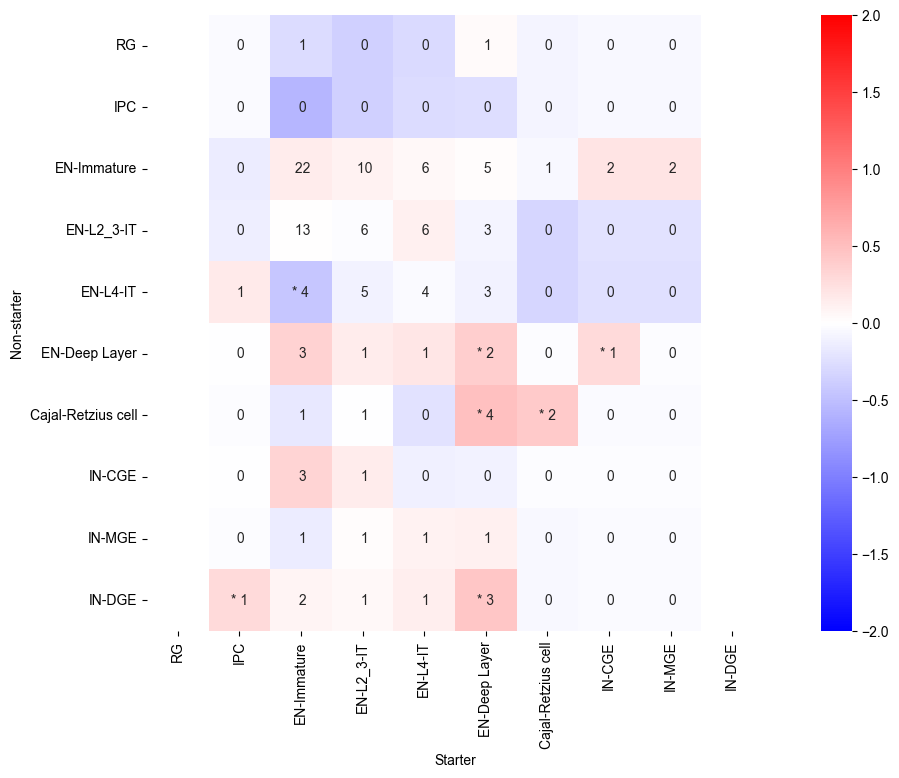

In [62]:
#Build null
uninfected_df = subset_metadata_df.loc[subset_metadata_df['datasetid'].isin(['u1','u2'])].groupby('subclass').count()['datasetid'].reset_index()
uninfected_df['proportion of celltype in nonstarter cells'] = uninfected_df['datasetid']/uninfected_df['datasetid'].sum()

#Rename 'datasetid' metadata column since it was overwritten by .count() function in preceding lines
uninfected_df.rename(columns = {'datasetid':'number of cells'},inplace = True)

#Clarify cell type assignments here should be used to generate non_starter null matrix populations
uninfected_df.rename(columns = {'subclass':'non_starter_cell_type'},inplace = True)
pooled_null = uninfected_df
pooled_null
pooled_null=build_null_matrix(pooled_null, subset_conn_1_compiling, annotations='subclass')

#Build observed
pooled_obs=build_obs_matrix(subset_conn_1_compiling, pooled_null, annotations='subclass')

#Build enriched
pooled_cell_sub_enrichment=build_enrichment_matrix(pooled_obs, pooled_null,dataset_id='combo')

In [ ]:
#Age

In [ ]:
old=subset_conn_1_compiling[subset_conn_1_compiling['datasetid'].isin(['s1','s3','s4','s5','c2','n2'])]
young=subset_conn_1_compiling[subset_conn_1_compiling['datasetid'].isin(['s2','c1','n1','c3','n3','c4','n4'])]

In [ ]:
#Export young vs. old
pd.DataFrame(old['subclass_conn'].value_counts()).to_csv('./connectivity/110625/old_sankey_input.csv')
pd.DataFrame(young['subclass_conn'].value_counts()).to_csv('./connectivity/110625/young_sankey_input.csv')

In [ ]:
#All datasets pooled, split by old/young
#old
#Build null
uninfected_df = subset_metadata_df.loc[subset_metadata_df['datasetid'].isin(['u1','u2'])].groupby('subclass').count()['datasetid'].reset_index()
uninfected_df['proportion of celltype in nonstarter cells'] = uninfected_df['datasetid']/uninfected_df['datasetid'].sum()

#Rename 'datasetid' metadata column since it was overwritten by .count() function in preceding lines
uninfected_df.rename(columns = {'datasetid':'number of cells'},inplace = True)

#Clarify cell type assignments here should be used to generate non_starter null matrix populations
uninfected_df.rename(columns = {'subclass':'non_starter_cell_type'},inplace = True)
pooled_null = uninfected_df
pooled_null
pooled_null=build_null_matrix(pooled_null, old, annotations='subclass')

#Build observed
pooled_obs=build_obs_matrix(old, pooled_null, annotations='subclass')

#Build enriched
pooled_cell_sub_enrichment=build_enrichment_matrix(pooled_obs, pooled_null,dataset_id='temp')


#young
#Build null
uninfected_df = subset_metadata_df.loc[subset_metadata_df['datasetid'].isin(['u1','u2'])].groupby('subclass').count()['datasetid'].reset_index()
uninfected_df['proportion of celltype in nonstarter cells'] = uninfected_df['datasetid']/uninfected_df['datasetid'].sum()

#Rename 'datasetid' metadata column since it was overwritten by .count() function in preceding lines
uninfected_df.rename(columns = {'datasetid':'number of cells'},inplace = True)

#Clarify cell type assignments here should be used to generate non_starter null matrix populations
uninfected_df.rename(columns = {'subclass':'non_starter_cell_type'},inplace = True)
pooled_null = uninfected_df
pooled_null
pooled_null=build_null_matrix(pooled_null, young, annotations='subclass')

#Build observed
pooled_obs=build_obs_matrix(young, pooled_null, annotations='subclass')

#Build enriched
pooled_cell_sub_enrichment=build_enrichment_matrix(pooled_obs, pooled_null,dataset_id='temp')

In [ ]:
#All datasets pooled
#Build null
uninfected_df = subset_metadata_df.loc[subset_metadata_df['datasetid'].isin(['u1','u2'])].groupby('subclass').count()['datasetid'].reset_index()
uninfected_df['proportion of celltype in nonstarter cells'] = uninfected_df['datasetid']/uninfected_df['datasetid'].sum()

#Rename 'datasetid' metadata column since it was overwritten by .count() function in preceding lines
uninfected_df.rename(columns = {'datasetid':'number of cells'},inplace = True)

#Clarify cell type assignments here should be used to generate non_starter null matrix populations
uninfected_df.rename(columns = {'subclass':'non_starter_cell_type'},inplace = True)
pooled_null = uninfected_df
pooled_null
pooled_null=build_null_matrix(pooled_null, subset_conn_1_compiling, annotations='subclass')

#Build observed
pooled_obs=build_obs_matrix(subset_conn_1_compiling, pooled_null, annotations='subclass')

#Build enriched
pooled_cell_sub_enrichment=build_enrichment_matrix(pooled_obs, pooled_null,dataset_id='temp')


In [ ]:
network_count=pd.DataFrame(conn_1_compiling.groupby('starter CBC')['non-starter CBC'].nunique()).reset_index()
#network_count.loc[network_count['non-starter CBC'] > 200, 'non-starter CBC'] = 200
network_count

In [ ]:
print(small_network_compiling['starter CBC'].nunique())
print(small_network_compiling['non-starter CBC'].nunique())



In [ ]:
#Age-divided
#If filtering out large networks

small_networks=network_count[network_count['non-starter CBC'] < 50]
small_networks

small_network_compiling=old[old['starter CBC'].isin(small_networks['starter CBC'])]
small_network_compiling
#subset_conn_1_compiling


#All datasets pooled
#Build null
uninfected_df = subset_metadata_df.loc[subset_metadata_df['datasetid'].isin(['u1','u2'])].groupby('subclass').count()['datasetid'].reset_index()
uninfected_df['proportion of celltype in nonstarter cells'] = uninfected_df['datasetid']/uninfected_df['datasetid'].sum()

#Rename 'datasetid' metadata column since it was overwritten by .count() function in preceding lines
uninfected_df.rename(columns = {'datasetid':'number of cells'},inplace = True)

#Clarify cell type assignments here should be used to generate non_starter null matrix populations
uninfected_df.rename(columns = {'subclass':'non_starter_cell_type'},inplace = True)
pooled_null = uninfected_df
pooled_null
pooled_null=build_null_matrix(pooled_null, small_network_compiling, annotations='subclass')

#Build observed
pooled_obs=build_obs_matrix(small_network_compiling, pooled_null, annotations='subclass')

#Build enriched
pooled_cell_sub_enrichment=build_enrichment_matrix(pooled_obs, pooled_null,dataset_id='old_drop_50')

In [ ]:
#If filtering out large networks

large_networks=network_count[network_count['non-starter CBC'] < 20]
large_networks

small_network_compiling=subset_conn_1_compiling[subset_conn_1_compiling['starter CBC'].isin(large_networks['starter CBC'])]
small_network_compiling
#subset_conn_1_compiling


#All datasets pooled
#Build null
uninfected_df = subset_metadata_df.loc[subset_metadata_df['datasetid'].isin(['u1','u2'])].groupby('subclass').count()['datasetid'].reset_index()
uninfected_df['proportion of celltype in nonstarter cells'] = uninfected_df['datasetid']/uninfected_df['datasetid'].sum()

#Rename 'datasetid' metadata column since it was overwritten by .count() function in preceding lines
uninfected_df.rename(columns = {'datasetid':'number of cells'},inplace = True)

#Clarify cell type assignments here should be used to generate non_starter null matrix populations
uninfected_df.rename(columns = {'subclass':'non_starter_cell_type'},inplace = True)
pooled_null = uninfected_df
pooled_null
pooled_null=build_null_matrix(pooled_null, small_network_compiling, annotations='subclass')

#Build observed
pooled_obs=build_obs_matrix(small_network_compiling, pooled_null, annotations='subclass')

#Build enriched
pooled_cell_sub_enrichment=build_enrichment_matrix(pooled_obs, pooled_null,dataset_id='drop_20')


### More junk?

In [ ]:
def build_enrichment_matrix(observed, null, dataset_id,vmin,vmax):
    
    #Add any missing connections that aren't in the uninfected datasets 
    missing_connections = list((set(observed['pre-post'])).difference(set(null['pre-post'])))

    df_new = pd.DataFrame({
        'pre-post':missing_connections,
        'proportion of connections':[0]*len(missing_connections),   
    })

    #Concatenate both matrices so you have a matrix that's the same size as the observed 
    null = pd.concat([null,df_new])
    null_dict = dict(zip(null['pre-post'],null['proportion of connections']))
    
    #Links the proportions from the null matrix to the matching cell type combos in the observed matrix dataframe
    observed['null proportion of connections'] = observed['pre-post'].apply(lambda x: null_dict[x])

    #Calculates the ratio of proportions of observed/null for each cell type (enrichment score) and normalizes with log10
    print(observed)
    observed['ratio of proportion of connections/null'] = ((observed['proportion of connections'] + 1) / (observed['null proportion of connections']+1)).apply(lambda x: math.log10(x) if x>0 else math.log10(10**-100))
    #Pseudocount addition
    #observed['ratio of proportion of connections/null'] = ((observed['proportion of connections']+1) / (observed['null proportion of connections']+1)).apply(lambda x: math.log10(x) if x>0 else math.log10(10**-100))

    
    #Format input for heatmap plot
    pivot = observed.pivot(index='non-starter cell_type', columns='starter cell_type')['ratio of proportion of connections/null']
    pivot2=observed.pivot(index='non-starter cell_type', columns='starter cell_type')['observed connections']
    #pivot = pivot.reindex(["RG","OPCs","Astrocytes","Progenitors","Interneurons","L2/3","L4","L5/6/SP"], level=0) \
    #.T.reindex(["RG","OPCs","Astrocytes","Progenitors","Interneurons","L2/3","L4","L5/6/SP"]).T
    print(pivot)
    plt.figure(figsize=(15,8))

    #Scaling is for log10 transformation
    sns.heatmap(pivot,  annot=pivot2, fmt = '', cmap = 'bwr', square = True, 
                vmin=vmin, 
                vmax = vmax)
    plt.ylabel('Non-starter')
    plt.xlabel('Starter')

    #Save figure as an .svg file
    #plt.savefig(f'/Users/maddieurbanek/Desktop/revision_data/082725/conn_matrices/{dataset_id}_enriched.svg', bbox_inches = 'tight', format = 'svg')

    print('Observation table:')
    print(observed[['pre-post','observed connections']])
    print()
    print('Total connections:')
    print(observed['observed connections'].sum())
    
    return observed

In [ ]:
#Pooled CVS Cell and Nuc?
#Build null
pooled_cell_sub_null=build_null_matrix(cell_subclass_null, cell_compiling, annotations='subclass')

#Build observed
pooled_cell_sub_obs=build_obs_matrix(cell_compiling, pooled_cell_sub_null, annotations='subclass')

#Build enriched
pooled_cell_sub_enrichment=build_enrichment_matrix(pooled_cell_sub_obs, pooled_cell_sub_null,dataset_id='cell_pooled_sub',vmin=-0.025,vmax=0.025)


In [ ]:
#Nuc
#Pooled CVS Cell and Nuc?
#Build null
pooled_nuc_broad_null=build_null_matrix(nuc_broad_null, nuc_compiling, annotations='broad_class')
pooled_nuc_sub_null=build_null_matrix(nuc_subclass_null, nuc_compiling, annotations='subclass')
pooled_nuc_fine_null=build_null_matrix(nuc_celltype_null, nuc_compiling, annotations='celltype')

#Build observed
pooled_nuc_broad_obs=build_obs_matrix(nuc_compiling, pooled_nuc_broad_null, annotations='broad_class')
pooled_nuc_sub_obs=build_obs_matrix(nuc_compiling, pooled_nuc_sub_null, annotations='subclass')
pooled_nuc_fine_obs=build_obs_matrix(nuc_compiling, pooled_nuc_fine_null, annotations='celltype')

#Build enriched
pooled_nuc_broad_enrichment=build_enrichment_matrix(pooled_nuc_broad_obs, pooled_nuc_broad_null,dataset_id='nuc_pooled_broad',vmin=-0.025,vmax=0.025)
pooled_nuc_sub_enrichment=build_enrichment_matrix(pooled_nuc_sub_obs, pooled_nuc_sub_null,dataset_id='nuc_pooled_sub',vmin=-0.025,vmax=0.025)
pooled_nuc_fine_enrichment=build_enrichment_matrix(pooled_nuc_fine_obs, pooled_nuc_fine_null,dataset_id='nuc_pooled_fine',vmin=-0.025,vmax=0.025)

In [ ]:
type_counts=metadata_df.groupby('datasetid')['celltype'].value_counts()

In [ ]:
type_counts.to_csv('/Users/maddieurbanek/Desktop/082725_type_counts.csv')

### Prepping starter_props

In [ ]:
#For every starter, need total number of connections made with presynaptic types

In [90]:
subset_conn_1_compiling['full_starter']=subset_conn_1_compiling['post_subclass'] + '_' + subset_conn_1_compiling['starter CBC']
#s1_obs['full_starter']=s1_obs['starter cell_type'] + '_' + s1_obs['starter CBC']
#s1_obs
#starters=conn_1_compiling['starter CBC'].unique()
starters=subset_conn_1_compiling['full_starter'].unique()
starter_sums=pd.DataFrame()

for i in starters:
    temp = subset_conn_1_compiling.loc[subset_conn_1_compiling['full_starter'] == i]
    counts = pd.DataFrame(temp['pre_subclass'].value_counts()).reset_index()
    counts['starter']=i
    starter_sums=pd.concat([starter_sums,counts],axis=0)


starter_sums=starter_sums[['starter','pre_subclass','count']]
print(starter_sums)

                            starter pre_subclass  count
0   EN-Immature_c1_AAAAAATGCATTCAAA  EN-Immature      5
1   EN-Immature_c1_AAAAAATGCATTCAAA   EN-L2_3-IT      2
2   EN-Immature_c1_AAAAAATGCATTCAAA    Astrocyte      2
3   EN-Immature_c1_AAAAAATGCATTCAAA           RG      1
4   EN-Immature_c1_AAAAAATGCATTCAAA       IN-MGE      1
..                              ...          ...    ...
0   EN-Immature_s5_CCGTAAAAATCTAACG  EN-Immature      2
0   EN-Immature_s5_CCTCAAGAATGTATAC  EN-Immature      1
1   EN-Immature_s5_CCTCAAGAATGTATAC       IN-MGE      1
2   EN-Immature_s5_CCTCAAGAATGTATAC   EN-L2_3-IT      1
0   EN-Immature_s5_CCTGAATGACAACATC   EN-L2_3-IT      1

[2582 rows x 3 columns]


In [91]:
#calculate proportions of connections for each starter entry

starters=starter_sums['starter'].unique()
starter_props=pd.DataFrame()

for i in starters:
    temp = starter_sums.loc[starter_sums['starter'] == i]
    temp['total_counts']=temp['count'].sum()
    temp['count_proportion']=temp['count']/temp['total_counts']
    starter_props=pd.concat([starter_props,temp],axis=0)

print(starter_props)


    #temp = conn_1_compiling.loc[conn_1_compiling['full_starter'] == i]
    #counts = pd.DataFrame(temp['non-starter cell_type'].value_counts()).reset_index()
    #counts['starter']=i
    #starter_sums=pd.concat([starter_sums,counts],axis=0)


                            starter pre_subclass  count  total_counts  \
0   EN-Immature_c1_AAAAAATGCATTCAAA  EN-Immature      5            13   
1   EN-Immature_c1_AAAAAATGCATTCAAA   EN-L2_3-IT      2            13   
2   EN-Immature_c1_AAAAAATGCATTCAAA    Astrocyte      2            13   
3   EN-Immature_c1_AAAAAATGCATTCAAA           RG      1            13   
4   EN-Immature_c1_AAAAAATGCATTCAAA       IN-MGE      1            13   
..                              ...          ...    ...           ...   
0   EN-Immature_s5_CCGTAAAAATCTAACG  EN-Immature      2             2   
0   EN-Immature_s5_CCTCAAGAATGTATAC  EN-Immature      1             3   
1   EN-Immature_s5_CCTCAAGAATGTATAC       IN-MGE      1             3   
2   EN-Immature_s5_CCTCAAGAATGTATAC   EN-L2_3-IT      1             3   
0   EN-Immature_s5_CCTGAATGACAACATC   EN-L2_3-IT      1             1   

    count_proportion  
0           0.384615  
1           0.153846  
2           0.153846  
3           0.076923  
4       

In [ ]:
starter_props

In [92]:
#Reformat starter props
#For cell types with _, replace with -
starter_props

starter_props['starter'] = starter_props['starter'].str.replace('EN-L2_3-IT', 'EN-L2-3-IT')
starter_props['starter'] = starter_props['starter'].str.replace('Cajal-Retzius cell', 'Cajal-Retzius-Cell')
starter_props['starter'] = starter_props['starter'].str.replace('EN-Deep Layer', 'EN-Deep-Layer')

starter_props['pre_subclass'] = starter_props['pre_subclass'].str.replace('EN-L2_3-IT', 'EN-L2-3-IT')
starter_props['pre_subclass'] = starter_props['pre_subclass'].str.replace('EN-Deep Layer', 'EN-Deep-Layer')
starter_props['pre_subclass'] = starter_props['pre_subclass'].str.replace('Cajal-Retzius cell', 'Cajal-Retzius-Cell')

starter_props

,starter,pre_subclass,count,total_counts,count_proportion
0,EN-Immature_c1_AAAAAATGCATTCAAA,EN-Immature,5,13,0.384615
1,EN-Immature_c1_AAAAAATGCATTCAAA,EN-L2-3-IT,2,13,0.153846
2,EN-Immature_c1_AAAAAATGCATTCAAA,Astrocyte,2,13,0.153846
3,EN-Immature_c1_AAAAAATGCATTCAAA,RG,1,13,0.076923
4,EN-Immature_c1_AAAAAATGCATTCAAA,IN-MGE,1,13,0.076923
...,...,...,...,...,...
0,EN-Immature_s5_CCGTAAAAATCTAACG,EN-Immature,2,2,1.000000
0,EN-Immature_s5_CCTCAAGAATGTATAC,EN-Immature,1,3,0.333333
1,EN-Immature_s5_CCTCAAGAATGTATAC,IN-MGE,1,3,0.333333
2,EN-Immature_s5_CCTCAAGAATGTATAC,EN-L2-3-IT,1,3,0.333333


In [93]:
#Split starter columns for reordering
starter_props[['post_subclass','dataset','CBC']] = starter_props['starter'].str.split('_', expand=True)
starter_props

,starter,pre_subclass,count,total_counts,count_proportion,post_subclass,dataset,CBC
0,EN-Immature_c1_AAAAAATGCATTCAAA,EN-Immature,5,13,0.384615,EN-Immature,c1,AAAAAATGCATTCAAA
1,EN-Immature_c1_AAAAAATGCATTCAAA,EN-L2-3-IT,2,13,0.153846,EN-Immature,c1,AAAAAATGCATTCAAA
2,EN-Immature_c1_AAAAAATGCATTCAAA,Astrocyte,2,13,0.153846,EN-Immature,c1,AAAAAATGCATTCAAA
3,EN-Immature_c1_AAAAAATGCATTCAAA,RG,1,13,0.076923,EN-Immature,c1,AAAAAATGCATTCAAA
4,EN-Immature_c1_AAAAAATGCATTCAAA,IN-MGE,1,13,0.076923,EN-Immature,c1,AAAAAATGCATTCAAA
...,...,...,...,...,...,...,...,...
0,EN-Immature_s5_CCGTAAAAATCTAACG,EN-Immature,2,2,1.000000,EN-Immature,s5,CCGTAAAAATCTAACG
0,EN-Immature_s5_CCTCAAGAATGTATAC,EN-Immature,1,3,0.333333,EN-Immature,s5,CCTCAAGAATGTATAC
1,EN-Immature_s5_CCTCAAGAATGTATAC,IN-MGE,1,3,0.333333,EN-Immature,s5,CCTCAAGAATGTATAC
2,EN-Immature_s5_CCTCAAGAATGTATAC,EN-L2-3-IT,1,3,0.333333,EN-Immature,s5,CCTCAAGAATGTATAC


In [94]:
starter_props['post_subclass'].unique()

array(['EN-Immature', 'EN-L2-3-IT', 'EN-Deep-Layer', 'EN-L4-IT', 'Oligo',
       'IN-MGE', 'IN-CGE', 'IPC', 'IN-DGE', 'Cajal-Retzius-Cell',
       'Astrocyte', 'RG'], dtype=object)

In [95]:
#sort based on starter type
types_list=['RG',
            'IPC',
            'EN-Immature',
            'EN-L2-3-IT',
            'EN-L4-IT',
            'EN-Deep-Layer',
            'Cajal-Retzius-Cell',
            'IN-CGE',
            'IN-MGE',
            'IN-DGE',
            'Astrocyte',
            'Oligo'
           ]

starter_props.sort_values(by="post_subclass", key=lambda column: column.map(lambda e: types_list.index(e)), inplace=True)
starter_props

,starter,pre_subclass,count,total_counts,count_proportion,post_subclass,dataset,CBC
0,RG_s3_ATGCCATTAGAGAGCC,Oligo,1,1,1.000000,RG,s3,ATGCCATTAGAGAGCC
3,IPC_c1_ATTGCCAAAATTATTC,EN-Deep-Layer,2,13,0.153846,IPC,c1,ATTGCCAAAATTATTC
2,IPC_c1_ATTGCCAAAATTATTC,Astrocyte,3,13,0.230769,IPC,c1,ATTGCCAAAATTATTC
1,IPC_c1_ATTGCCAAAATTATTC,EN-L2-3-IT,3,13,0.230769,IPC,c1,ATTGCCAAAATTATTC
0,IPC_c1_ATTGCCAAAATTATTC,EN-L4-IT,4,13,0.307692,IPC,c1,ATTGCCAAAATTATTC
...,...,...,...,...,...,...,...,...
2,Oligo_c4_ATCAAGAGACTAAAGG,EN-L4-IT,1,12,0.083333,Oligo,c4,ATCAAGAGACTAAAGG
3,Oligo_c4_ATCAAGAGACTAAAGG,EN-Deep-Layer,1,12,0.083333,Oligo,c4,ATCAAGAGACTAAAGG
1,Oligo_c1_ACGGATGGAAGAAGGC,Astrocyte,2,5,0.400000,Oligo,c1,ACGGATGGAAGAAGGC
1,Oligo_s4_CAACCACTCCACAGGT,Astrocyte,1,3,0.333333,Oligo,s4,CAACCACTCCACAGGT


### Junk?

In [ ]:
#For setting blue lines on heat map
print(starter_props.drop_duplicates('starter')['starter_type'].value_counts())
print(starter_props['starter_type'].unique())


In [ ]:
#Format input for heatmap plot

pivot = starter_props.pivot(index='starter', columns='non-starter cell_type')['count_proportion']
pivot=pivot.fillna(0)

#Reorganize pivot to match developmental stages
pivot=pivot[['RG-vRG',
             'RG-tRG',
             'RG-oRG',
             'Tri-IPC',
             'IPC-EN',
             'EN-Newborn',
             'EN-IT-Immature',
             'EN-Non-IT-Immature',
             'EN-L2-3-IT', 
             'EN-L4-IT',
             'EN-L5-ET', 
             'EN-L5-IT', 
             'EN-L5-6-NP', 
             'EN-L6-CT', 
             'EN-L6-IT', 
             'EN-L6b',
             'Cajal-Retzius-Cell',
             'IN-CGE-Immature',
             'IN-MGE-Immature',
             'IN-NCx-dLGE-Immature',
             'IN-CGE-SNCG',
             'IN-CGE-VIP',
             'IN-MGE-PV',
             'IN-MGE-SST',
             'IN-Mix-LAMP5',
             'OPC',
             'Oligodendrocyte-Immature',
             'Oligodendrocyte', 
             'Astrocyte-Immature',
             'Astrocyte-Protoplasmic',
             'Astrocyte-Fibrous',
             'Microglia',
             'Vascular']]

pivot = pivot.reindex(starter_props['starter'])
pivot = pivot.loc[~pivot.index.duplicated(keep='first'), :]

#pivot = pivot.reindex(["RG","OPCs","Astrocytes","Progenitors","Interneurons","L2/3","L4","L5/6/SP"], level=0) \
#This will plot a red square whenever there's a hit

fig, ax = plt.subplots(figsize=(7, 10))


sns.heatmap(pivot,  
            #annot=pivot, 
            fmt = '', 
            cmap = 'bwr',
            #vmin=0,
            center=0, 
            vmax=1,
            yticklabels=False,
            xticklabels=True, 
            ax=ax
           )

import matplotlib.patches as patches

#Astrocytes
ax.add_patch(
     patches.Rectangle(
         #Sets upper left coordinate of box
         (0, 0),
         #Sets how long (should be number of unique presynaptic types
         33.0,
         #Sets how tall (should be however many helpers for that identity)
         1.0,
         edgecolor='blue',
         fill=False,
         lw=0.25
     ))

#CR
ax.add_patch(
     patches.Rectangle(
         #Sets upper left coordinate of box
         (0, 1),
         #Sets how long (should be number of unique presynaptic types
         33.0,
         #Sets how tall (should be however many helpers for that identity)
         1.0,
         edgecolor='blue',
         fill=False,
         lw=0.25
     ))

ax.add_patch(
     patches.Rectangle(
         #Sets upper left coordinate of box
         (0, 2),
         #Sets how long (should be number of unique presynaptic types
         33.0,
         #Sets how tall (should be however many helpers for that identity)
         154.0,
         edgecolor='blue',
         fill=False,
         lw=0.25
     ))

ax.add_patch(
     patches.Rectangle(
         #Sets upper left coordinate of box
         (0, 156),
         #Sets how long (should be number of unique presynaptic types
         33.0,
         #Sets how tall (should be however many helpers for that identity)
         4.0,
         edgecolor='blue',
         fill=False,
         lw=0.25
     ))


ax.add_patch(
     patches.Rectangle(
         #Sets upper left coordinate of box
         (0, 160),
         #Sets how long (should be number of unique presynaptic types
         33.0,
         #Sets how tall (should be however many helpers for that identity)
         2.0,
         edgecolor='blue',
         fill=False,
         lw=0.25
     ))

ax.add_patch(
     patches.Rectangle(
         #Sets upper left coordinate of box
         (0, 162),
         #Sets how long (should be number of unique presynaptic types
         33.0,
         #Sets how tall (should be however many helpers for that identity)
         121.0,
         edgecolor='blue',
         fill=False,
         lw=0.25
     ))

ax.add_patch(
     patches.Rectangle(
         #Sets upper left coordinate of box
         (0, 283),
         #Sets how long (should be number of unique presynaptic types
         33.0,
         #Sets how tall (should be however many helpers for that identity)
         122.0,
         edgecolor='blue',
         fill=False,
         lw=0.25
     ))



ax.add_patch(
     patches.Rectangle(
         #Sets upper left coordinate of box
         (0, 405),
         #Sets how long (should be number of unique presynaptic types
         33.0,
         #Sets how tall (should be however many helpers for that identity)
         3.0,
         edgecolor='blue',
         fill=False,
         lw=0.25
     ))


ax.add_patch(
     patches.Rectangle(
         #Sets upper left coordinate of box
         (0, 408),
         #Sets how long (should be number of unique presynaptic types
         33.0,
         #Sets how tall (should be however many helpers for that identity)
         3.0,
         edgecolor='blue',
         fill=False,
         lw=0.25
     ))


#this adds EN-L6
ax.add_patch(
     patches.Rectangle(
         #Sets upper left coordinate of box
         (0, 411),
         #Sets how long (should be number of unique presynaptic types
         33.0,
         #Sets how tall (should be however many helpers for that identity)
         3.0,
         edgecolor='blue',
         fill=False,
         lw=0.25
     ))

ax.add_patch(
     patches.Rectangle(
         #Sets upper left coordinate of box
         (0, 414),
         #Sets how long (should be number of unique presynaptic types
         33.0,
         #Sets how tall (should be however many helpers for that identity)
         19.0,
         edgecolor='blue',
         fill=False,
         lw=0.25
     ))

ax.add_patch(
     patches.Rectangle(
         #Sets upper left coordinate of box
         (0, 433),
         #Sets how long (should be number of unique presynaptic types
         33.0,
         #Sets how tall (should be however many helpers for that identity)
         2.0,
         edgecolor='blue',
         fill=False,
         lw=0.25
     ))

ax.add_patch(
     patches.Rectangle(
         #Sets upper left coordinate of box
         (0, 435),
         #Sets how long (should be number of unique presynaptic types
         33.0,
         #Sets how tall (should be however many helpers for that identity)
         25.0,
         edgecolor='blue',
         fill=False,
         lw=0.25
     ))

ax.add_patch(
     patches.Rectangle(
         #Sets upper left coordinate of box
         (0, 460),
         #Sets how long (should be number of unique presynaptic types
         33.0,
         #Sets how tall (should be however many helpers for that identity)
         22.0,
         edgecolor='blue',
         fill=False,
         lw=0.25
     ))
ax.add_patch(
     patches.Rectangle(
         #Sets upper left coordinate of box
         (0, 482),
         #Sets how long (should be number of unique presynaptic types
         33.0,
         #Sets how tall (should be however many helpers for that identity)
         5.0,
         edgecolor='blue',
         fill=False,
         lw=0.25
     ))
ax.add_patch(
     patches.Rectangle(
         #Sets upper left coordinate of box
         (0, 487),
         #Sets how long (should be number of unique presynaptic types
         33.0,
         #Sets how tall (should be however many helpers for that identity)
         5.0,
         edgecolor='blue',
         fill=False,
         lw=0.25
     ))
ax.add_patch(
     patches.Rectangle(
         #Sets upper left coordinate of box
         (0, 492),
         #Sets how long (should be number of unique presynaptic types
         33.0,
         #Sets how tall (should be however many helpers for that identity)
         5.0,
         edgecolor='blue',
         fill=False,
         lw=0.25
     ))
ax.add_patch(
     patches.Rectangle(
         #Sets upper left coordinate of box
         (0, 497),
         #Sets how long (should be number of unique presynaptic types
         33.0,
         #Sets how tall (should be however many helpers for that identity)
         1.0,
         edgecolor='blue',
         fill=False,
         lw=0.25
     ))
ax.add_patch(
     patches.Rectangle(
         #Sets upper left coordinate of box
         (0, 498),
         #Sets how long (should be number of unique presynaptic types
         33.0,
         #Sets how tall (should be however many helpers for that identity)
         2.0,
         edgecolor='blue',
         fill=False,
         lw=0.25
     ))
ax.add_patch(
     patches.Rectangle(
         #Sets upper left coordinate of box
         (0, 499),
         #Sets how long (should be number of unique presynaptic types
         33.0,
         #Sets how tall (should be however many helpers for that identity)
         1.0,
         edgecolor='blue',
         fill=False,
         lw=0.25
     ))
ax.add_patch(
     patches.Rectangle(
         #Sets upper left coordinate of box
         (0, 500),
         #Sets how long (should be number of unique presynaptic types
         33.0,
         #Sets how tall (should be however many helpers for that identity)
         2.0,
         edgecolor='blue',
         fill=False,
         lw=0.25
     ))
ax.add_patch(
     patches.Rectangle(
         #Sets upper left coordinate of box
         (0, 502),
         #Sets how long (should be number of unique presynaptic types
         33.0,
         #Sets how tall (should be however many helpers for that identity)
         7.0,
         edgecolor='blue',
         fill=False,
         lw=0.25
     ))

ax.add_patch(
     patches.Rectangle(
         #Sets upper left coordinate of box
         (0, 509),
         #Sets how long (should be number of unique presynaptic types
         33.0,
         #Sets how tall (should be however many helpers for that identity)
         3.0,
         edgecolor='blue',
         fill=False,
         lw=0.25
     ))

ax.add_patch(
     patches.Rectangle(
         #Sets upper left coordinate of box
         (0, 512),
         #Sets how long (should be number of unique presynaptic types
         33.0,
         #Sets how tall (should be however many helpers for that identity)
         1.0,
         edgecolor='blue',
         fill=False,
         lw=0.25
     ))

ax.add_patch(
     patches.Rectangle(
         #Sets upper left coordinate of box
         (0, 513),
         #Sets how long (should be number of unique presynaptic types
         33.0,
         #Sets how tall (should be however many helpers for that identity)
         9.0,
         edgecolor='blue',
         fill=False,
         lw=0.25
     ))


plt.ylabel('Starter')
plt.xlabel('Presynaptic Type')

#plt.savefig('/Users/maddieurbanek/Desktop/revision_data/082925/label_binary_heatmap.svg', bbox_inches = 'tight', format = 'svg')
plt.savefig('/Users/maddieurbanek/Desktop/revision_data/090225/ordered_label_prop_heatmap.svg', bbox_inches = 'tight', format = 'svg')


In [ ]:
#1) scatter plot of #CR inputs v. #other EN inputs, for each starter cell with dots colored by cell type. 
#calculate proportions of connections for each starter entry

cr_rows = starter_props.loc[starter_props['non-starter cell_type'] == "Cajal-Retzius-Cell"]
cr_rows

#Get

In [ ]:
sns.regplot(data=cr_rows, x='total_counts', y='count', color = '#7294d4',scatter_kws={'alpha':0.1})
#ax=sns.regplot(data=nuc_mergeddf, x='logged_umi', y='logged_bar', color = '#e6a0c4')


In [ ]:
starters=starter_props['starter'].unique()
scatter_plot_input=pd.DataFrame()

#For each unique starter entry, pull all rows, pull counts where non-starter cell_type is Cajal Retzius, sum remaining rows
for i in starters:
    temp = starter_sums.loc[starter_sums['starter'] == i]
    cr_rows = temp.loc[temp['non-starter cell_type'] == "Cajal-Retzius-Cell"]
    print(cr_rows)
    non_cr_rows=temp.loc[~(temp['non-starter cell_type'] == "Cajal-Retzius-Cell")]

    #barcodes_df.loc[~(barcodes_df['barcode'].isin(starter_barcodes_list)),'starter_barcode'] = 'n'    
    #print(non_cr_rows)







In [ ]:
2) instead of ranking by cell type, rank by %CR inputs for each starter cell and keep the cell type color bar on the side.

In [ ]:
#Check datasets???

In [ ]:
#Format input for heatmap plot

pivot = starter_props.pivot(index='starter', columns='non-starter cell_type')['count_proportion']
pivot=pivot.fillna(0)

#Reorganize pivot to match developmental stages
pivot=pivot[['RG-vRG',
             'RG-tRG',
             'RG-oRG',
             'Tri-IPC',
             'IPC-EN',
             'EN-Newborn',
             'EN-IT-Immature',
             'EN-Non-IT-Immature',
             'EN-L2-3-IT', 
             'EN-L4-IT',
             'EN-L5-ET', 
             'EN-L5-IT', 
             'EN-L5-6-NP', 
             'EN-L6-CT', 
             'EN-L6-IT', 
             'EN-L6b',
             'Cajal-Retzius-Cell',
             'IN-CGE-Immature',
             'IN-MGE-Immature',
             'IN-NCx-dLGE-Immature',
             'IN-CGE-SNCG',
             'IN-CGE-VIP',
             'IN-MGE-PV',
             'IN-MGE-SST',
             'IN-Mix-LAMP5',
             'OPC',
             'Oligodendrocyte-Immature',
             'Oligodendrocyte', 
             'Astrocyte-Immature',
             'Astrocyte-Protoplasmic',
             'Astrocyte-Fibrous',
             'Microglia',
             'Vascular']]

pivot = pivot.reindex(starter_props['starter'])
pivot = pivot.loc[~pivot.index.duplicated(keep='first'), :]

temp=pivot.sort_values(by=['Cajal-Retzius-Cell'])
temp

#pivot = pivot.reindex(["RG","OPCs","Astrocytes","Progenitors","Interneurons","L2/3","L4","L5/6/SP"], level=0) \
#This will plot a red square whenever there's a hit

fig, ax = plt.subplots(figsize=(7, 100))


sns.heatmap(temp,  
            #annot=pivot, 
            fmt = '', 
            cmap = 'bwr',
            #vmin=0,
            center=0, 
            vmax=1,
            yticklabels=True,
            xticklabels=True, 
            ax=ax
           )


plt.ylabel('Starter')
plt.xlabel('Presynaptic Type')

#plt.savefig('/Users/maddieurbanek/Desktop/revision_data/082925/label_binary_heatmap.svg', bbox_inches = 'tight', format = 'svg')
plt.savefig('/Users/maddieurbanek/Desktop/revision_data/092225/weighted_by_cr.svg', bbox_inches = 'tight', format = 'svg')


In [ ]:
#Format input for heatmap plot

pivot = starter_props.pivot(index='starter', columns='non-starter cell_type')['count_proportion']
pivot=pivot.fillna(0)

#Reorganize pivot to match developmental stages
pivot=pivot[['RG-vRG',
             'RG-tRG',
             'RG-oRG',
             'Tri-IPC',
             'IPC-EN',
             'EN-Newborn',
             'EN-IT-Immature',
             'EN-Non-IT-Immature',
             'EN-L2-3-IT', 
             'EN-L4-IT',
             'EN-L5-ET', 
             'EN-L5-IT', 
             'EN-L5-6-NP', 
             'EN-L6-CT', 
             'EN-L6-IT', 
             'EN-L6b',
             'Cajal-Retzius-Cell',
             'IN-CGE-Immature',
             'IN-MGE-Immature',
             'IN-NCx-dLGE-Immature',
             'IN-CGE-SNCG',
             'IN-CGE-VIP',
             'IN-MGE-PV',
             'IN-MGE-SST',
             'IN-Mix-LAMP5',
             'OPC',
             'Oligodendrocyte-Immature',
             'Oligodendrocyte', 
             'Astrocyte-Immature',
             'Astrocyte-Protoplasmic',
             'Astrocyte-Fibrous',
             'Microglia',
             'Vascular']]

pivot = pivot.reindex(starter_props['starter'])
pivot = pivot.loc[~pivot.index.duplicated(keep='first'), :]

temp=pivot.sort_values(by=['Cajal-Retzius-Cell'])
temp

#pivot = pivot.reindex(["RG","OPCs","Astrocytes","Progenitors","Interneurons","L2/3","L4","L5/6/SP"], level=0) \
#This will plot a red square whenever there's a hit

fig, ax = plt.subplots(figsize=(7, 10))


sns.heatmap(temp,  
            #annot=pivot, 
            fmt = '', 
            cmap = 'bwr',
            #vmin=0,
            center=0, 
            vmax=1,
            yticklabels=False,
            xticklabels=True, 
            ax=ax
           )


plt.ylabel('Starter')
plt.xlabel('Presynaptic Type')

#plt.savefig('/Users/maddieurbanek/Desktop/revision_data/082925/label_binary_heatmap.svg', bbox_inches = 'tight', format = 'svg')
plt.savefig('/Users/maddieurbanek/Desktop/revision_data/092225/collapsed_weighted_by_cr.png', bbox_inches = 'tight', format = 'png')


### Heatmap

In [ ]:
#START HERE W/ STARTER PROPS

In [ ]:
#Adding column to starter props

In [ ]:
Maybe don't need to run the following cell?

In [ ]:
#Define subclasses (layer identies for excitatory neurons, types for glia, region for inhibitory)
astro=['Astrocyte-Fibrous','Astrocyte-Protoplasmic','Astrocyte-Immature']
opc=['OPC','Oligodendrocyte','Oligodendrocyte-Immature']
rgc=['RG-tRG','RG-oRG','RG-vRG']

mge=['IN-MGE-SST','IN-MGE-PV','IN-MGE-Immature']
cge=['IN-CGE-Immature','IN-CGE-VIP', 'IN-CGE-SNCG']
dge=['IN-NCx-dLGE-Immature']

immature=['EN-Newborn','EN-IT-Immature','EN-Non-IT-Immature']
deep=['EN-L5_6-NP','EN-L6b','EN-L5-ET','EN-L6-CT', 'EN-L6-IT','EN-L5-IT']

starter_props['pre_subclass']=starter_props['non-starter cell_type'].copy()
starter_props.loc[starter_props['non-starter cell_type'].isin(astro), 'pre_subclass'] = 'Astrocyte'
starter_props.loc[starter_props['non-starter cell_type'].isin(opc), 'pre_subclass'] = 'Oligo'
starter_props.loc[starter_props['non-starter cell_type'].isin(rgc), 'pre_subclass'] = 'RG'
starter_props.loc[starter_props['non-starter cell_type'].isin(pro), 'pre_subclass'] = 'IPC'
starter_props.loc[starter_props['non-starter cell_type'].isin(mge), 'pre_subclass'] = 'IN-MGE'
starter_props.loc[starter_props['non-starter cell_type'].isin(cge), 'pre_subclass'] = 'IN-CGE'
starter_props.loc[starter_props['non-starter cell_type'].isin(dge), 'pre_subclass'] = 'IN-dLGE'
starter_props.loc[starter_props['non-starter cell_type'].isin(immature), 'pre_subclass'] = 'EN-Immature'
starter_props.loc[starter_props['non-starter cell_type'].isin(deep), 'pre_subclass'] = 'EN-Deep Layer'

starter_props['post_subclass']=starter_props['starter_type'].copy()
starter_props.loc[starter_props['starter_type'].isin(astro), 'post_subclass'] = 'Astrocyte'
starter_props.loc[starter_props['starter_type'].isin(opc), 'post_subclass'] = 'Oligo'
starter_props.loc[starter_props['starter_type'].isin(rgc), 'post_subclass'] = 'RG'
starter_props.loc[starter_props['starter_type'].isin(pro), 'post_subclass'] = 'IPC'
starter_props.loc[starter_props['starter_type'].isin(mge), 'post_subclass'] = 'IN-MGE'
starter_props.loc[starter_props['starter_type'].isin(cge), 'post_subclass'] = 'IN-CGE'
starter_props.loc[starter_props['starter_type'].isin(dge), 'post_subclass'] = 'IN-dLGE'
starter_props.loc[starter_props['starter_type'].isin(immature), 'post_subclass'] = 'EN-Immature'
starter_props.loc[starter_props['starter_type'].isin(deep), 'post_subclass'] = 'EN-Deep Layer'
starter_props['pre_subclass'].unique()

In [96]:
#Removing any starters that aren't neuronal types'
subset_starter_props = starter_props[starter_props.post_subclass != 'Oligo']
subset_starter_props = subset_starter_props[subset_starter_props.post_subclass != 'Astrocyte']

In [ ]:
subset_starter_props

In [97]:
#Pooled
pivot = subset_starter_props.pivot(index='starter', columns='pre_subclass')['count_proportion']
pivot=pivot.fillna(0)

#Reorganize pivot to match developmental stages, excluding visualization for low-representation and glial populations
pivot=pivot[['RG','IPC','EN-Immature','EN-L2-3-IT','EN-L4-IT','EN-Deep-Layer','Cajal-Retzius-Cell','IN-CGE','IN-MGE','IN-DGE']]

pivot = pivot.reindex(subset_starter_props['starter'])
pivot = pivot.loc[~pivot.index.duplicated(keep='first'), :]
pivot

pre_subclass,RG,IPC,EN-Immature,EN-L2-3-IT,EN-L4-IT,EN-Deep-Layer,Cajal-Retzius-Cell,IN-CGE,IN-MGE,IN-DGE
starter,,,,,,,,,,
RG_s3_ATGCCATTAGAGAGCC,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
IPC_c1_ATTGCCAAAATTATTC,0.0,0.000000,0.000000,0.230769,0.307692,0.153846,0.0,0.000000,0.000000,0.076923
IPC_c2_ACCACCTGCACACATC,0.0,0.000000,0.685714,0.171429,0.114286,0.000000,0.0,0.028571,0.000000,0.000000
EN-Immature_c2_AGGAACGGAGAGAGAG,0.0,0.061224,0.448980,0.285714,0.061224,0.000000,0.0,0.040816,0.061224,0.020408
EN-Immature_c2_AGGCATCCAGGAAGTT,0.0,0.000000,0.250000,0.375000,0.250000,0.000000,0.0,0.000000,0.125000,0.000000
...,...,...,...,...,...,...,...,...,...,...
IN-MGE_c1_ACGTCCCCCCACCACT,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
IN-DGE_c1_CAGAATGAACCTAGGG,0.0,0.000000,0.375000,0.000000,0.250000,0.000000,0.0,0.125000,0.000000,0.000000
IN-DGE_c2_CATGACTCATCCCACC,0.0,0.000000,0.409091,0.318182,0.113636,0.000000,0.0,0.000000,0.045455,0.022727


#393b79
#5254a3
#6b6ecf
#637939
#8ca252
#cedb9c
#8c6d31
#e7ba52
#e7cb94
#843c39
#d6616b
#e7969c
#a55194
#ce6dbd
#de9ed6


/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_26238/1305693600.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20b', 15)    # PiYG


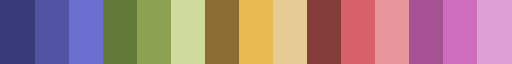

In [98]:
#Pulling hex codes for starter types
from pylab import *
cmap = cm.get_cmap('tab20b', 15)    # PiYG
cmap

for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    print(matplotlib.colors.rgb2hex(rgba))

cmap

In [99]:
#Exact GW
starter_list=pd.DataFrame(pivot.index)
starter_list[['celltype','dataset_id','cbc']]=starter_list['starter'].str.split('_', expand=True)

#Adding dataset colors
starter_list[['gw_color']]='color'


starter_list.loc[starter_list['dataset_id'].isin(['s1']), 'gw_color'] = '#A0C4FF'
starter_list.loc[starter_list['dataset_id'].isin(['s2']), 'gw_color'] = '#FFD6A5'
starter_list.loc[starter_list['dataset_id'].isin(['s3']), 'gw_color'] = '#BDB2FF'
starter_list.loc[starter_list['dataset_id'].isin(['s4']), 'gw_color'] = '#CAFFBF'
starter_list.loc[starter_list['dataset_id'].isin(['s5']), 'gw_color'] = '#CAFFBF'

starter_list.loc[starter_list['dataset_id'].isin(['c1']), 'gw_color'] = '#FDFFB6'
starter_list.loc[starter_list['dataset_id'].isin(['c2']), 'gw_color'] = '#A0C4FF'
starter_list.loc[starter_list['dataset_id'].isin(['c3']), 'gw_color'] = '#FFADAD'
starter_list.loc[starter_list['dataset_id'].isin(['c4']), 'gw_color'] = '#FDFFB6'

starter_list.loc[starter_list['dataset_id'].isin(['n1']), 'gw_color'] = '#FDFFB6'
starter_list.loc[starter_list['dataset_id'].isin(['n2']), 'gw_color'] = '#A0C4FF'
starter_list.loc[starter_list['dataset_id'].isin(['n3']), 'gw_color'] = '#FFADAD'
starter_list.loc[starter_list['dataset_id'].isin(['n4']), 'gw_color'] = '#FDFFB6'

starter_list

,starter,celltype,dataset_id,cbc,gw_color
0,RG_s3_ATGCCATTAGAGAGCC,RG,s3,ATGCCATTAGAGAGCC,#BDB2FF
1,IPC_c1_ATTGCCAAAATTATTC,IPC,c1,ATTGCCAAAATTATTC,#FDFFB6
2,IPC_c2_ACCACCTGCACACATC,IPC,c2,ACCACCTGCACACATC,#A0C4FF
3,EN-Immature_c2_AGGAACGGAGAGAGAG,EN-Immature,c2,AGGAACGGAGAGAGAG,#A0C4FF
4,EN-Immature_c2_AGGCATCCAGGAAGTT,EN-Immature,c2,AGGCATCCAGGAAGTT,#A0C4FF
...,...,...,...,...,...
692,IN-MGE_c1_ACGTCCCCCCACCACT,IN-MGE,c1,ACGTCCCCCCACCACT,#FDFFB6
693,IN-DGE_c1_CAGAATGAACCTAGGG,IN-DGE,c1,CAGAATGAACCTAGGG,#FDFFB6
694,IN-DGE_c2_CATGACTCATCCCACC,IN-DGE,c2,CATGACTCATCCCACC,#A0C4FF
695,IN-DGE_n1_CCGGACCCACTCCCGG,IN-DGE,n1,CCGGACCCACTCCCGG,#FDFFB6


In [100]:
#Want a dictionary for starter and color
#One color for DATASET ID

#Adding dataset colors
starter_list[['dataset_color']]='color'

starter_list.loc[starter_list['dataset_id'].isin(['s1']), 'dataset_color'] = 'firebrick'
starter_list.loc[starter_list['dataset_id'].isin(['s2']), 'dataset_color'] = 'rosybrown'
starter_list.loc[starter_list['dataset_id'].isin(['s3']), 'dataset_color'] = 'maroon'
starter_list.loc[starter_list['dataset_id'].isin(['s4']), 'dataset_color'] = 'orangered'
starter_list.loc[starter_list['dataset_id'].isin(['s5']), 'dataset_color'] = 'lightsalmon'

starter_list.loc[starter_list['dataset_id'].isin(['c1']), 'dataset_color'] = 'darkgreen'
starter_list.loc[starter_list['dataset_id'].isin(['c2']), 'dataset_color'] = 'mediumseagreen'
starter_list.loc[starter_list['dataset_id'].isin(['c3']), 'dataset_color'] = 'turquoise'
starter_list.loc[starter_list['dataset_id'].isin(['c4']), 'dataset_color'] = 'skyblue'

starter_list.loc[starter_list['dataset_id'].isin(['n1']), 'dataset_color'] = 'pink'
starter_list.loc[starter_list['dataset_id'].isin(['n2']), 'dataset_color'] = 'orchid'
starter_list.loc[starter_list['dataset_id'].isin(['n3']), 'dataset_color'] = 'darkmagenta'
starter_list.loc[starter_list['dataset_id'].isin(['n4']), 'dataset_color'] = 'plum'

starter_list

,starter,celltype,dataset_id,cbc,gw_color,dataset_color
0,RG_s3_ATGCCATTAGAGAGCC,RG,s3,ATGCCATTAGAGAGCC,#BDB2FF,maroon
1,IPC_c1_ATTGCCAAAATTATTC,IPC,c1,ATTGCCAAAATTATTC,#FDFFB6,darkgreen
2,IPC_c2_ACCACCTGCACACATC,IPC,c2,ACCACCTGCACACATC,#A0C4FF,mediumseagreen
3,EN-Immature_c2_AGGAACGGAGAGAGAG,EN-Immature,c2,AGGAACGGAGAGAGAG,#A0C4FF,mediumseagreen
4,EN-Immature_c2_AGGCATCCAGGAAGTT,EN-Immature,c2,AGGCATCCAGGAAGTT,#A0C4FF,mediumseagreen
...,...,...,...,...,...,...
692,IN-MGE_c1_ACGTCCCCCCACCACT,IN-MGE,c1,ACGTCCCCCCACCACT,#FDFFB6,darkgreen
693,IN-DGE_c1_CAGAATGAACCTAGGG,IN-DGE,c1,CAGAATGAACCTAGGG,#FDFFB6,darkgreen
694,IN-DGE_c2_CATGACTCATCCCACC,IN-DGE,c2,CATGACTCATCCCACC,#A0C4FF,mediumseagreen
695,IN-DGE_n1_CCGGACCCACTCCCGG,IN-DGE,n1,CCGGACCCACTCCCGG,#FDFFB6,pink


In [101]:
#Strain

#Adding dataset colors
starter_list[['strain_color']]='color'


starter_list.loc[starter_list['dataset_id'].isin(['s1']), 'strain_color'] = '#F59D8C'
starter_list.loc[starter_list['dataset_id'].isin(['s2']), 'strain_color'] = '#F59D8C'
starter_list.loc[starter_list['dataset_id'].isin(['s3']), 'strain_color'] = '#F59D8C'
starter_list.loc[starter_list['dataset_id'].isin(['s4']), 'strain_color'] = '#F59D8C'
starter_list.loc[starter_list['dataset_id'].isin(['s5']), 'strain_color'] = '#F59D8C'

starter_list.loc[starter_list['dataset_id'].isin(['c1']), 'strain_color'] = '#A68CF5'
starter_list.loc[starter_list['dataset_id'].isin(['c2']), 'strain_color'] = '#A68CF5'
starter_list.loc[starter_list['dataset_id'].isin(['c3']), 'strain_color'] = '#A68CF5'
starter_list.loc[starter_list['dataset_id'].isin(['c4']), 'strain_color'] = '#A68CF5'

starter_list.loc[starter_list['dataset_id'].isin(['n1']), 'strain_color'] = '#A68CF5'
starter_list.loc[starter_list['dataset_id'].isin(['n2']), 'strain_color'] = '#A68CF5'
starter_list.loc[starter_list['dataset_id'].isin(['n3']), 'strain_color'] = '#A68CF5'
starter_list.loc[starter_list['dataset_id'].isin(['n4']), 'strain_color'] = '#A68CF5'

starter_list

,starter,celltype,dataset_id,cbc,gw_color,dataset_color,strain_color
0,RG_s3_ATGCCATTAGAGAGCC,RG,s3,ATGCCATTAGAGAGCC,#BDB2FF,maroon,#F59D8C
1,IPC_c1_ATTGCCAAAATTATTC,IPC,c1,ATTGCCAAAATTATTC,#FDFFB6,darkgreen,#A68CF5
2,IPC_c2_ACCACCTGCACACATC,IPC,c2,ACCACCTGCACACATC,#A0C4FF,mediumseagreen,#A68CF5
3,EN-Immature_c2_AGGAACGGAGAGAGAG,EN-Immature,c2,AGGAACGGAGAGAGAG,#A0C4FF,mediumseagreen,#A68CF5
4,EN-Immature_c2_AGGCATCCAGGAAGTT,EN-Immature,c2,AGGCATCCAGGAAGTT,#A0C4FF,mediumseagreen,#A68CF5
...,...,...,...,...,...,...,...
692,IN-MGE_c1_ACGTCCCCCCACCACT,IN-MGE,c1,ACGTCCCCCCACCACT,#FDFFB6,darkgreen,#A68CF5
693,IN-DGE_c1_CAGAATGAACCTAGGG,IN-DGE,c1,CAGAATGAACCTAGGG,#FDFFB6,darkgreen,#A68CF5
694,IN-DGE_c2_CATGACTCATCCCACC,IN-DGE,c2,CATGACTCATCCCACC,#A0C4FF,mediumseagreen,#A68CF5
695,IN-DGE_n1_CCGGACCCACTCCCGG,IN-DGE,n1,CCGGACCCACTCCCGG,#FDFFB6,pink,#A68CF5


In [102]:
#Dissociation modality

#Adding dataset colors
starter_list[['diss_color']]='color'


starter_list.loc[starter_list['dataset_id'].isin(['s1']), 'diss_color'] = '#7294d4'
starter_list.loc[starter_list['dataset_id'].isin(['s2']), 'diss_color'] = '#7294d4'
starter_list.loc[starter_list['dataset_id'].isin(['s3']), 'diss_color'] = '#7294d4'
starter_list.loc[starter_list['dataset_id'].isin(['s4']), 'diss_color'] = '#7294d4'
starter_list.loc[starter_list['dataset_id'].isin(['s5']), 'diss_color'] = '#7294d4'

starter_list.loc[starter_list['dataset_id'].isin(['c1']), 'diss_color'] = '#7294d4'
starter_list.loc[starter_list['dataset_id'].isin(['c2']), 'diss_color'] = '#7294d4'
starter_list.loc[starter_list['dataset_id'].isin(['c3']), 'diss_color'] = '#7294d4'
starter_list.loc[starter_list['dataset_id'].isin(['c4']), 'diss_color'] = '#7294d4'

starter_list.loc[starter_list['dataset_id'].isin(['n1']), 'diss_color'] = '#e6a0c4'
starter_list.loc[starter_list['dataset_id'].isin(['n2']), 'diss_color'] = '#e6a0c4'
starter_list.loc[starter_list['dataset_id'].isin(['n3']), 'diss_color'] = '#e6a0c4'
starter_list.loc[starter_list['dataset_id'].isin(['n4']), 'diss_color'] = '#e6a0c4'

starter_list

,starter,celltype,dataset_id,cbc,gw_color,dataset_color,strain_color,diss_color
0,RG_s3_ATGCCATTAGAGAGCC,RG,s3,ATGCCATTAGAGAGCC,#BDB2FF,maroon,#F59D8C,#7294d4
1,IPC_c1_ATTGCCAAAATTATTC,IPC,c1,ATTGCCAAAATTATTC,#FDFFB6,darkgreen,#A68CF5,#7294d4
2,IPC_c2_ACCACCTGCACACATC,IPC,c2,ACCACCTGCACACATC,#A0C4FF,mediumseagreen,#A68CF5,#7294d4
3,EN-Immature_c2_AGGAACGGAGAGAGAG,EN-Immature,c2,AGGAACGGAGAGAGAG,#A0C4FF,mediumseagreen,#A68CF5,#7294d4
4,EN-Immature_c2_AGGCATCCAGGAAGTT,EN-Immature,c2,AGGCATCCAGGAAGTT,#A0C4FF,mediumseagreen,#A68CF5,#7294d4
...,...,...,...,...,...,...,...,...
692,IN-MGE_c1_ACGTCCCCCCACCACT,IN-MGE,c1,ACGTCCCCCCACCACT,#FDFFB6,darkgreen,#A68CF5,#7294d4
693,IN-DGE_c1_CAGAATGAACCTAGGG,IN-DGE,c1,CAGAATGAACCTAGGG,#FDFFB6,darkgreen,#A68CF5,#7294d4
694,IN-DGE_c2_CATGACTCATCCCACC,IN-DGE,c2,CATGACTCATCCCACC,#A0C4FF,mediumseagreen,#A68CF5,#7294d4
695,IN-DGE_n1_CCGGACCCACTCCCGG,IN-DGE,n1,CCGGACCCACTCCCGG,#FDFFB6,pink,#A68CF5,#e6a0c4


In [103]:
#Want a dictionary for starter and color
#One color for DATASET ID
#Other color for cell type

#Adding dataset colors
starter_list[['age_color']]='color'


starter_list.loc[starter_list['dataset_id'].isin(['s1']), 'age_color'] = 'r'
starter_list.loc[starter_list['dataset_id'].isin(['s2']), 'age_color'] = 'g'
starter_list.loc[starter_list['dataset_id'].isin(['s3']), 'age_color'] = 'r'
starter_list.loc[starter_list['dataset_id'].isin(['s4']), 'age_color'] = 'r'
starter_list.loc[starter_list['dataset_id'].isin(['s5']), 'age_color'] = 'r'

starter_list.loc[starter_list['dataset_id'].isin(['c1']), 'age_color'] = 'g'
starter_list.loc[starter_list['dataset_id'].isin(['c2']), 'age_color'] = 'r'
starter_list.loc[starter_list['dataset_id'].isin(['c3']), 'age_color'] = 'g'
starter_list.loc[starter_list['dataset_id'].isin(['c4']), 'age_color'] = 'g'

starter_list.loc[starter_list['dataset_id'].isin(['n1']), 'age_color'] = 'g'
starter_list.loc[starter_list['dataset_id'].isin(['n2']), 'age_color'] = 'r'
starter_list.loc[starter_list['dataset_id'].isin(['n3']), 'age_color'] = 'g'
starter_list.loc[starter_list['dataset_id'].isin(['n4']), 'age_color'] = 'g'

starter_list

,starter,celltype,dataset_id,cbc,gw_color,dataset_color,strain_color,diss_color,age_color
0,RG_s3_ATGCCATTAGAGAGCC,RG,s3,ATGCCATTAGAGAGCC,#BDB2FF,maroon,#F59D8C,#7294d4,r
1,IPC_c1_ATTGCCAAAATTATTC,IPC,c1,ATTGCCAAAATTATTC,#FDFFB6,darkgreen,#A68CF5,#7294d4,g
2,IPC_c2_ACCACCTGCACACATC,IPC,c2,ACCACCTGCACACATC,#A0C4FF,mediumseagreen,#A68CF5,#7294d4,r
3,EN-Immature_c2_AGGAACGGAGAGAGAG,EN-Immature,c2,AGGAACGGAGAGAGAG,#A0C4FF,mediumseagreen,#A68CF5,#7294d4,r
4,EN-Immature_c2_AGGCATCCAGGAAGTT,EN-Immature,c2,AGGCATCCAGGAAGTT,#A0C4FF,mediumseagreen,#A68CF5,#7294d4,r
...,...,...,...,...,...,...,...,...,...
692,IN-MGE_c1_ACGTCCCCCCACCACT,IN-MGE,c1,ACGTCCCCCCACCACT,#FDFFB6,darkgreen,#A68CF5,#7294d4,g
693,IN-DGE_c1_CAGAATGAACCTAGGG,IN-DGE,c1,CAGAATGAACCTAGGG,#FDFFB6,darkgreen,#A68CF5,#7294d4,g
694,IN-DGE_c2_CATGACTCATCCCACC,IN-DGE,c2,CATGACTCATCCCACC,#A0C4FF,mediumseagreen,#A68CF5,#7294d4,r
695,IN-DGE_n1_CCGGACCCACTCCCGG,IN-DGE,n1,CCGGACCCACTCCCGG,#FDFFB6,pink,#A68CF5,#e6a0c4,g


In [104]:
#And for starter cell type
#Adding dataset colors
starter_list[['starter_color']]='color'


starter_list.loc[starter_list['celltype'].isin(['RG']), 'starter_color'] = '#8ca252'
starter_list.loc[starter_list['celltype'].isin(['IPC']), 'starter_color'] = '#cedb9c'
starter_list.loc[starter_list['celltype'].isin(['EN-Immature']), 'starter_color'] = '#8c6d31'
starter_list.loc[starter_list['celltype'].isin(['EN-L2-3-IT']), 'starter_color'] = '#e7ba52'
starter_list.loc[starter_list['celltype'].isin(['EN-L4-IT']), 'starter_color'] = '#e7cb94'
starter_list.loc[starter_list['celltype'].isin(['EN-Deep-Layer']), 'starter_color'] = '#843c39'
starter_list.loc[starter_list['celltype'].isin(['Cajal-Retzius-Cell']), 'starter_color'] = '#d6616b'
starter_list.loc[starter_list['celltype'].isin(['IN-CGE']), 'starter_color'] = '#e7969c'
starter_list.loc[starter_list['celltype'].isin(['IN-MGE']), 'starter_color'] = '#a55194'
starter_list.loc[starter_list['celltype'].isin(['IN-DGE']), 'starter_color'] = '#ce6dbd'



In [105]:
color_df = starter_list[['age_color','dataset_color','starter_color','strain_color','diss_color','gw_color']]
color_df

,age_color,dataset_color,starter_color,strain_color,diss_color,gw_color
0,r,maroon,#8ca252,#F59D8C,#7294d4,#BDB2FF
1,g,darkgreen,#cedb9c,#A68CF5,#7294d4,#FDFFB6
2,r,mediumseagreen,#cedb9c,#A68CF5,#7294d4,#A0C4FF
3,r,mediumseagreen,#8c6d31,#A68CF5,#7294d4,#A0C4FF
4,r,mediumseagreen,#8c6d31,#A68CF5,#7294d4,#A0C4FF
...,...,...,...,...,...,...
692,g,darkgreen,#a55194,#A68CF5,#7294d4,#FDFFB6
693,g,darkgreen,#ce6dbd,#A68CF5,#7294d4,#FDFFB6
694,r,mediumseagreen,#ce6dbd,#A68CF5,#7294d4,#A0C4FF
695,g,pink,#ce6dbd,#A68CF5,#e6a0c4,#FDFFB6


In [106]:
#Sending index to numbers so it matches color map
pivot=pivot.reset_index()
pivot=pivot.drop(columns=['starter'])
pivot

pre_subclass,RG,IPC,EN-Immature,EN-L2-3-IT,EN-L4-IT,EN-Deep-Layer,Cajal-Retzius-Cell,IN-CGE,IN-MGE,IN-DGE
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,0.0,0.000000,0.000000,0.230769,0.307692,0.153846,0.0,0.000000,0.000000,0.076923
2,0.0,0.000000,0.685714,0.171429,0.114286,0.000000,0.0,0.028571,0.000000,0.000000
3,0.0,0.061224,0.448980,0.285714,0.061224,0.000000,0.0,0.040816,0.061224,0.020408
4,0.0,0.000000,0.250000,0.375000,0.250000,0.000000,0.0,0.000000,0.125000,0.000000
...,...,...,...,...,...,...,...,...,...,...
692,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
693,0.0,0.000000,0.375000,0.000000,0.250000,0.000000,0.0,0.125000,0.000000,0.000000
694,0.0,0.000000,0.409091,0.318182,0.113636,0.000000,0.0,0.000000,0.045455,0.022727
695,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000


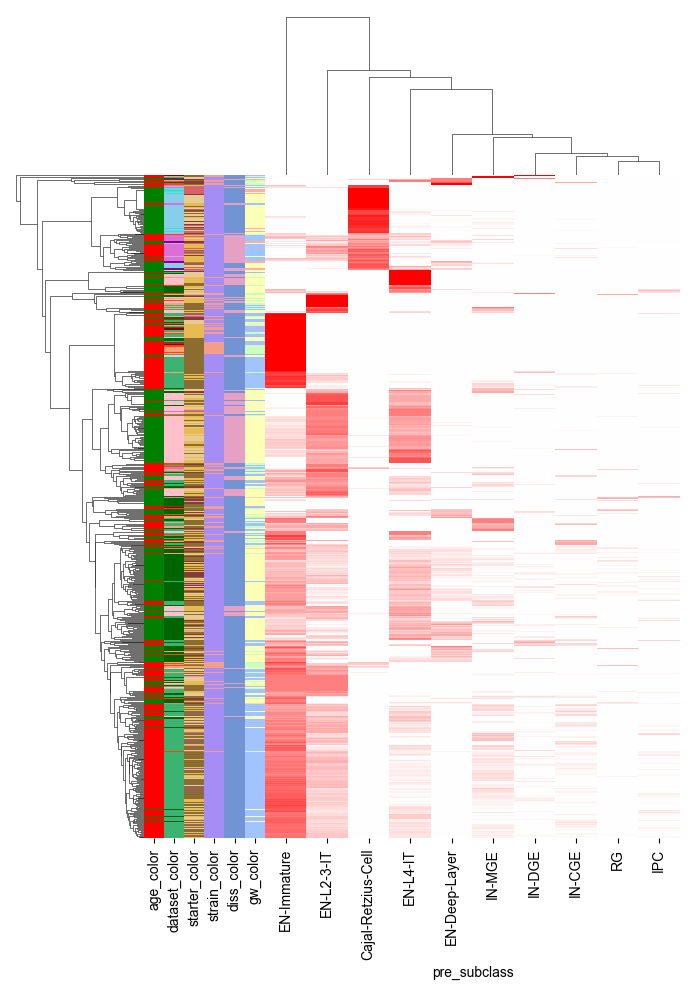

In [107]:
sns.clustermap(pivot,
              #annot=pivot,
               fmt = '', 
               cmap = 'bwr',
               #vmin=0,
               center=0, 
               vmax=1,
               yticklabels=False,
               xticklabels=True,
               figsize=(7, 10),
               row_colors=color_df,
               cbar_pos=None
              )

plt.savefig('../figs/fig_8/112025_full_heatmap.pdf', bbox_inches = 'tight', format = 'pdf')

### Graph Networks

In [ ]:
def graph_draw(G, using_barcodes_df):
            
        pos = nx.nx_agraph.graphviz_layout(G, prog='neato', root=None, args='')  

        fig, ax = plt.subplots()
        edge_list = list(G.edges())
        nodes_list = list(G.nodes())

# scale node size by max degree among nodes
        if len(edge_list) >1:
            max_degree = max([x[1] for x in list(G.degree())])
            nodescale = 20

            nodesize = [nodescale*x[1]/max_degree for x in list(G.degree())]

        celltype_dict = dict(zip(using_barcodes_df['CBC'], using_barcodes_df['subclass']))
    
        keys = ['RG', 
                'IPC', 
                'EN-Immature', 
                'EN-L2_3-IT', 
                'EN-L4-IT',
                'EN-Deep Layer', 
                'Cajal-Retzius cell', 
                'IN-CGE', 
                'IN-MGE',
                'IN-DGE']
    
        values = ['#8ca252',
                  '#cedb9c', 
                  '#8c6d31', 
                  '#e7ba52',
                  '#e7cb94',
                  '#843c39', 
                  '#d6616b', 
                  '#e7969c',
                 '#a55194',
                  '#ce6dbd']

    
        colors_dict = dict(zip(keys, values))
        color_list_nodes = list(map(lambda x: colors_dict[x], list(map(lambda x: celltype_dict[x], nodes_list)))) 

        # draw nodes
        nx.draw_networkx_nodes(G, pos, ax=ax, node_color=color_list_nodes, node_size =nodesize)

        # color edges by cell type of nonstarter neuron
        if len(edge_list) >1:
            edges_colors = list(map(lambda x: colors_dict[x], list(map(lambda x: celltype_dict[x[0]], edge_list))))      
            nx.draw_networkx_edges(G, pos, ax=ax, edgelist=edge_list, width = 1/10, node_size = nodesize, edge_color=edges_colors, arrowsize = 4, arrows=True)

# add degree legend
        size_ranges = [np.array(nodesize).min(), np.median(np.array(nodesize)), np.array(nodesize).max()]
        size_labels = [f'Min: {max_degree/nodescale*size_ranges[0]:.2f}', f'Median: {max_degree/nodescale*size_ranges[1]:.2f}', f'Max: {max_degree/nodescale*size_ranges[2]:.2f}']
        
        for size, label in zip(size_ranges, size_labels):
           ax.scatter([], [], s=size, color='black', alpha=0.6, label=label)
        
        ax.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='upper left', title= 'Node degree', bbox_to_anchor=(1.00, 1.5))
    
# add cell type legend
        for celltype, color in colors_dict.items():
           ax.scatter([], [], s=100, color=color, alpha=0.6, label=celltype)

# keep title for degree but plot cell type colors
        ax.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='upper left',title= 'Node degree', bbox_to_anchor=(1.00, 1.0))

        return fig

In [ ]:
def graph_draw(G, using_barcodes_df):
            
        pos = nx.nx_agraph.graphviz_layout(G, prog='neato', root=None, args='')  

        fig, ax = plt.subplots()
        edge_list = list(G.edges())
        nodes_list = list(G.nodes())

# scale node size by max degree among nodes
        if len(edge_list) >1:
            max_degree = max([x[1] for x in list(G.degree())])
            nodescale = 20

            nodesize = [nodescale*x[1]/max_degree for x in list(G.degree())]

        celltype_dict = dict(zip(using_barcodes_df['CBC'], using_barcodes_df['subclass']))
    
        keys = ['RG', 
                'IPC', 
                'EN-Immature', 
                'EN-L2_3-IT', 
                'EN-L4-IT',
                'EN-Deep Layer', 
                'Cajal-Retzius cell', 
                'IN-CGE', 
                'IN-MGE',
                'IN-DGE']
    
        values = ['#8ca252',
                  '#cedb9c', 
                  '#8c6d31', 
                  '#e7ba52',
                  '#e7cb94',
                  '#843c39', 
                  '#d6616b', 
                  '#e7969c',
                 '#a55194',
                  '#ce6dbd']

    
        colors_dict = dict(zip(keys, values))
        color_list_nodes = list(map(lambda x: colors_dict[x], list(map(lambda x: celltype_dict[x], nodes_list)))) 

        # draw nodes
        nx.draw_networkx_nodes(G, pos, ax=ax, node_color=color_list_nodes, node_size =nodesize)

        # color edges by cell type of nonstarter neuron
        if len(edge_list) >1:
            edges_colors = list(map(lambda x: colors_dict[x], list(map(lambda x: celltype_dict[x[0]], edge_list))))      
            nx.draw_networkx_edges(G, pos, ax=ax, edgelist=edge_list, width = 1/10, node_size = nodesize, edge_color=edges_colors, arrowsize = 4, arrows=True)

# add degree legend
        size_ranges = [np.array(nodesize).min(), np.median(np.array(nodesize)), np.array(nodesize).max()]
        size_labels = [f'Min: {max_degree/nodescale*size_ranges[0]:.2f}', f'Median: {max_degree/nodescale*size_ranges[1]:.2f}', f'Max: {max_degree/nodescale*size_ranges[2]:.2f}']
        
        for size, label in zip(size_ranges, size_labels):
           ax.scatter([], [], s=size, color='black', alpha=0.6, label=label)
        
        ax.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='upper left', title= 'Node degree', bbox_to_anchor=(1.00, 1.5))
    
# add cell type legend
        for celltype, color in colors_dict.items():
           ax.scatter([], [], s=100, color=color, alpha=0.6, label=celltype)

# keep title for degree but plot cell type colors
        ax.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='upper left',title= 'Node degree', bbox_to_anchor=(1.00, 1.0))

        return fig

In [ ]:
def graph_plot(conn_1, using_barcodes_df, path_to_pdf):

    G = nx.DiGraph()
   
    G.add_nodes_from(set(conn_1['non-starter CBC']).union(set(conn_1['starter CBC'])))

    edge_list = []    
    edge_list = list(conn_1['connection'])
    
    G.add_edges_from(edge_list)       
            
    G_plot = G
    fig = graph_draw(G_plot, using_barcodes_df)
    fig.set_size_inches(10,10)
    fig.savefig(path_to_pdf)

In [ ]:
#Removing glial and low represented cells from graph network visualization
subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.post_subclass != 'Astrocyte']
subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.pre_subclass != 'Astrocyte']

subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.post_subclass != 'Oligo']
subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.pre_subclass != 'Oligo']

subset_conn_1_compiling

In [ ]:
dataset = list(set(processed_barcodes_df['datasetid']))

for datasets in dataset:
    print(datasets)
    datasets = [datasets]
    
    using_barcodes_df = processed_barcodes_df.loc[processed_barcodes_df['datasetid'].isin(datasets)]
    conn_1 = subset_conn_1_compiling.loc[subset_conn_1_compiling['datasetid'].isin(datasets)]
    
    graph_plot(conn_1, using_barcodes_df, 
               f'../figs/fig_8/117325_{datasets}_network.pdf')

In [ ]:
#For all slices together
using_barcodes_df = processed_barcodes_df.loc[processed_barcodes_df['single_starter_barcode'].isin(['y'])]
    
graph_plot(subset_conn_1_compiling, using_barcodes_df, 
               '../figs/fig_8/111725_pooled_network.pdf')

In [ ]:
#Cajal-Retzius only
using_barcodes_df = processed_barcodes_df.loc[processed_barcodes_df['single_starter_barcode'].isin(['y'])]
cajal = subset_conn_1_compiling.loc[(subset_conn_1_compiling['post_subclass'].isin(['Cajal-Retzius cell']) | subset_conn_1_compiling['pre_subclass'].isin(['Cajal-Retzius cell']))]


graph_plot(cajal, using_barcodes_df, 
               '../figs/fig_8/110625_cr_network.pdf')

### Network composition by cell type

In [ ]:
subset_conn_1_compiling = conn_1_compiling[conn_1_compiling.post_subclass != 'Vascular']
subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.pre_subclass != 'Vascular']

subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.post_subclass != 'IN-Mix-LAMP5']
subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.pre_subclass != 'IN-Mix-LAMP5']

subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.post_subclass != 'Microglia']
subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.pre_subclass != 'Microglia']
subset_conn_1_compiling

In [ ]:
#Calculate number of presynaptic cells per network by counting unique presynaptic CBCs
network_size=pd.DataFrame(subset_conn_1_compiling['starter CBC'].value_counts()).reset_index()

#Merge dataframes together
network_types=pd.merge(subset_conn_1_compiling,network_size, on= 'starter CBC')
network_types

In [ ]:
#Add column for grouping into network bins
network_types['network_size']=network_types['count'].copy()
network_types.loc[network_types['count'] == 1, 'network_size'] = 'single'
network_types.loc[network_types['count'] >1, 'network_size'] = 'small'
network_types.loc[network_types['count'] >10, 'network_size'] = 'medium'
network_types.loc[network_types['count'] >20, 'network_size'] = 'large'
network_types

In [ ]:
def calculate_props(dataset_list, #list of categories data are grouped into
                   population #which population to use, pre or post
                   ):
    
    final_props=network_types[[population]]
    final_props=final_props.drop_duplicates().reset_index()

    for i in dataset_list:
        temp = network_types.loc[network_types['network_size'] == i]

        if population == 'post_subclass':
            temp=temp.drop_duplicates(['starter CBC']).reset_index()
            
        print(len(temp))
        props=pd.DataFrame(temp[population].value_counts()).reset_index()
        props[f'{i}_proportion']=props['count']/props['count'].sum()
        final_props = final_props.merge(props[[population, f'{i}_proportion']], on=population, how='left')

    transposed_props=final_props.T
    transposed_props.columns = transposed_props.iloc[1]
    transposed_props = transposed_props[2:]

    transposed_props= transposed_props.fillna(0)
    
    return transposed_props


In [ ]:
pre_props=calculate_props(['single','small','medium','large'], 'pre_subclass')


post_props=calculate_props(['single','small','medium','large'],'post_subclass')


In [ ]:
#Sort cell types for input into stacked bar plot
pre_props=pre_props[['Oligo',
                         'Astrocyte',
                         'RG',
                         'IPC',
                         'EN-Immature',
                         'EN-L2_3-IT',
                         'EN-L4-IT',
                         'EN-Deep Layer',
                         'Cajal-Retzius cell',
                         'IN-CGE',
                         'IN-MGE',
                         'IN-DGE'
                        ]]
pre_props['dataset'] = pre_props.index

post_props=post_props[['Oligo',
                         'Astrocyte',
                         'RG',
                         'IPC',
                         'EN-Immature',
                         'EN-L2_3-IT',
                         'EN-L4-IT',
                         'EN-Deep Layer',
                         'Cajal-Retzius cell',
                         'IN-CGE',
                         'IN-MGE',
                         'IN-DGE'
                        ]]
post_props['dataset'] = post_props.index

In [ ]:
# plot data in stack manner of bar type
pre_props.plot(x='dataset', 
                 kind='bar', 
                 stacked=True,
                 title='Cell type proportions',
                 legend=False,
                 colormap='tab20b'
                )

plt.savefig('../figs/fig_8/111125_pre_stacked_cell_types.pdf', bbox_inches='tight', format='pdf')
plt.show()


#And with legend for recoloring later in illustrator
pre_props.plot(x='dataset', 
                 kind='bar', 
                 stacked=True,
                 title='Cell type proportions',
                 legend=True,
                 colormap='tab20b'
                )

plt.savefig('../figs/fig_8/111125_stacked_cell_types_w_legend.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [ ]:
# plot data in stack manner of bar type
post_props.plot(x='dataset', 
                 kind='bar', 
                 stacked=True,
                 title='Cell type proportions',
                 legend=False,
                 colormap='tab20b'
                )

plt.savefig('../figs/fig_8/111125_post_stacked_cell_types.pdf', bbox_inches='tight', format='pdf')
plt.show()


#And with legend for recoloring later in illustrator
post_props.plot(x='dataset', 
                 kind='bar', 
                 stacked=True,
                 title='Cell type proportions',
                 legend=True,
                 colormap='tab20b'
                )

plt.savefig('../figs/fig_8/111125_stacked_cell_types_w_legend.pdf', bbox_inches='tight', format='pdf')
plt.show()

### Junk?

In [ ]:
def calculate_counts(dataset_list #list of dataset IDs to be pulled from metadata file
                   ):
    
    final_counts=network_types[['pre_subclass']]
    final_counts=final_counts.drop_duplicates().reset_index()

    for i in dataset_list:
        temp = network_types.loc[network_types['network_size'] == i]
        counts=pd.DataFrame(temp['pre_subclass'].value_counts()).reset_index()
        counts[f'{i}_count']=counts['count']
        final_counts = final_counts.merge(counts[['pre_subclass', f'{i}_count']], on='pre_subclass', how='left')

    transposed_counts=final_counts.T
    transposed_counts.columns = transposed_counts.iloc[1]
    transposed_counts = transposed_counts[2:]

    transposed_counts= transposed_counts.fillna(0)
    
    return transposed_counts


In [ ]:
final_counts=calculate_counts(['single','small','medium','large'])
final_counts

In [ ]:
#Sort cell types for input into stacked bar plot
final_counts=final_counts[['Oligo',
                         'Astrocyte',
                         'RG',
                         'IPC',
                         'EN-Immature',
                         'EN-L2_3-IT',
                         'EN-L4-IT',
                         'EN-Deep Layer',
                         'Cajal-Retzius cell',
                         'IN-CGE',
                         'IN-MGE',
                         'IN-DGE'
                        ]]
final_counts['dataset'] = final_counts.index

In [ ]:
# plot counts in stack manner of bar type
final_counts.plot(x='dataset', 
                 kind='bar', 
                 stacked=True,
                 title='Cell type proportions',
                 legend=False,
                 colormap='tab20b'
                )

plt.yscale('log')
plt.savefig('../figs/fig_8/stacked_cell_types_counts.pdf', bbox_inches='tight', format='pdf')
plt.show()


#And with legend for recoloring later in illustrator
final_counts.plot(x='dataset', 
                 kind='bar', 
                 stacked=True,
                 title='Cell type proportions',
                 legend=True,
                 colormap='tab20b'
                )

plt.savefig('../figs/fig_6/stacked_cell_types_counts_w_legend.pdf', bbox_inches='tight', format='pdf')
plt.show()

### Starter drop-out

In [ ]:
#Make line plot showing how risk of calling single-starter that's actually dual-starter decreases as a function of helper capture
drop_out_risk=pd.DataFrame([.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
drop_out_risk.columns=['capture']
drop_out_risk['both_observed']=drop_out_risk['capture']*drop_out_risk['capture']
drop_out_risk['none_observed']=(1-drop_out_risk['capture'])*(1-drop_out_risk['capture'])
drop_out_risk['one_observed']=1-drop_out_risk['none_observed']-drop_out_risk['both_observed']
drop_out_risk['risk_of_calling_one_not_two']=drop_out_risk['one_observed']/drop_out_risk['both_observed']

drop_out_risk

In [ ]:
#Plotting risk column
plt.plot(drop_out_risk['capture'],drop_out_risk['both_observed'],color='blue',label='Capture Both')
plt.plot(drop_out_risk['capture'],drop_out_risk['one_observed'],color='green',label='Capture One')
plt.plot(drop_out_risk['capture'],drop_out_risk['none_observed'],color='black',label='Capture None')
plt.legend()
plt.xlabel('% of Starters Capture')
plt.ylabel('False Single Starter Call/True Dual Starter Call')
plt.savefig('/Users/maddieurbanek/Desktop/revision_data/resubmission/figs/sfig_conn/starter_dropout/risk_dynamics.pdf')
plt.show() 

In [ ]:
#Plotting risk column
plt.plot(drop_out_risk['capture'],drop_out_risk['risk_of_calling_one_not_two'])
plt.axhline(y=1, color='black', linestyle=':')
plt.xlabel('% of Starters Capture')
plt.ylabel('False Single Starter Call/True Dual Starter Call')
plt.savefig('/Users/maddieurbanek/Desktop/revision_data/resubmission/figs/sfig_conn/starter_dropout/false_single_risk.pdf')
plt.show() 

In [ ]:
#Plot number of empty vs. single vs. dual 

In [ ]:
#Drop-out simulations
processed_barcodes_df['celltypes'].unique()
(combo_list)

In [ ]:
percent_to_take=.10
bootstraps=3
temp=processed_barcodes_df[processed_barcodes_df['helper'] == 'starter']
starters_to_pull=int(temp['CBC'].nunique()*percent_to_take)

#bootstrapped_counts=pd.DataFrame(index=combo_list)
bootstrapped_counts=pd.DataFrame()

for n in range(bootstraps):
    starters=(np.random.choice(temp['CBC'].unique(),starters_to_pull,replace=False))
    temp_1=temp[temp['CBC'].isin(starters)]
    to_pull=temp_1['barcode'].unique()
    downsampled_pbdf=processed_barcodes_df[processed_barcodes_df['barcode'].isin(to_pull)]

    df = downsampled_pbdf.loc[(downsampled_pbdf['single_starter_barcode'] == 'y') & (downsampled_pbdf['starter/nonstarter barcode'] == 'both')]
    cell_type_dict = dict(zip(df['CBC'],df['celltypes']))
    starter_df = df.loc[df['helper'] == 'starter'].groupby(['datasetid','CBC'])['barcode'].apply(set).reset_index()
    starter_dict = dict(zip(starter_df['CBC'],starter_df['barcode']))
    nonstarter_df = df.loc[df['helper'] == 'nonstarter'].groupby(['CBC'])['barcode'].apply(set).reset_index()
    nonstarter_dict = dict(zip(nonstarter_df['CBC'],nonstarter_df['barcode']))
    for starter in starter_dict.keys():
        matching_cells = []
        starter_barcode_set = starter_dict[starter]
        for nonstarter in nonstarter_dict.keys():
            nonstarter_barcode_set = nonstarter_dict[nonstarter]
            if len(starter_barcode_set.intersection(nonstarter_barcode_set))>=1:
                matching_cells.append(nonstarter)
        starter_df.loc[starter_df['CBC'] == starter, 'matching_cells'] = str(matching_cells)
    starter_df['matching_cells'] = starter_df['matching_cells'].apply(ast.literal_eval)
    starter_df.rename(columns = {'CBC':'starter CBC', 'barcode':'starter barcodes', 'matching_cells':'non-starter CBC'}, inplace = True)
    starter_df['starter cell_type'] = starter_df['starter CBC'].apply(lambda x: cell_type_dict[x])
    conn_0_compiling = starter_df[['datasetid','starter cell_type','starter CBC','non-starter CBC']]
    conn_0_compiling['number of non-starters associated'] = conn_0_compiling['non-starter CBC'].apply(lambda x: len(x))
    conn_0_compiling['number of cells in single-starter network'] = conn_0_compiling['non-starter CBC'].apply(lambda x: len(x) +1)
    conn_1_compiling = starter_df.explode('non-starter CBC')
    conn_1_compiling['non-starter cell_type'] = conn_1_compiling['non-starter CBC'].apply(lambda x: cell_type_dict[x])
    conn_1_compiling = conn_1_compiling[['datasetid','starter cell_type','starter CBC','non-starter cell_type','non-starter CBC']]
    conn_1_compiling['conn_type'] = conn_1_compiling['non-starter cell_type'] +'+'+ conn_1_compiling['starter cell_type'] 
    conn_1_compiling['connection'] = conn_1_compiling.apply(lambda x: (x['non-starter CBC'], x['starter CBC'], {'w':1}), axis=1)
    feature_dict = dict(zip(metadata_df['cellbarcode'],metadata_df['broad_class']))
    conn_1_compiling['pre_broad_class'] = conn_1_compiling['non-starter CBC'].apply(lambda x: feature_dict[x])
    conn_1_compiling['post_subclass'] = conn_1_compiling['starter CBC'].apply(lambda x: feature_dict[x])
    feature_dict = dict(zip(metadata_df['cellbarcode'],metadata_df['subclass']))
    conn_1_compiling['pre_subclass'] = conn_1_compiling['non-starter CBC'].apply(lambda x: feature_dict[x])
    conn_1_compiling['post_subclass'] = conn_1_compiling['starter CBC'].apply(lambda x: feature_dict[x])
    conn_1_compiling['subclass_conn']=conn_1_compiling['pre_subclass'] + '+' + conn_1_compiling['post_subclass']
    subset_conn_1_compiling = conn_1_compiling[conn_1_compiling.post_subclass != 'Vascular']
    subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.pre_subclass != 'Vascular']
    subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.post_subclass != 'IN-Mix-LAMP5']
    subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.pre_subclass != 'IN-Mix-LAMP5']
    subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.post_subclass != 'Microglia']
    subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.pre_subclass != 'Microglia']
    subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.post_subclass != 'Astrocyte']
    subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.pre_subclass != 'Astrocyte']
    subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.post_subclass != 'Oligo']
    subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.pre_subclass != 'Oligo']
    connection_counts=pd.DataFrame(subset_conn_1_compiling['subclass_conn'].value_counts())
    connection_counts.loc['total_counts'] = connection_counts.sum(numeric_only=True, axis=0)
    connection_props = connection_counts.divide(connection_counts.loc['total_counts'], axis=1)
    connection_props.drop(['total_counts'])
    bootstrapped_counts = pd.concat([bootstrapped_counts,connection_props],axis=1,sort=False)

bootstrapped_counts=bootstrapped_counts.fillna(0)
average = pd.DataFrame(bootstrapped_counts.mean(axis=1))
bootstrapped_counts['sem'] = bootstrapped_counts.sem(axis=1)
bootstrapped_counts['average']=average
bootstrapped_counts

In [ ]:
#Run null matrix formatting
#Build null
uninfected_df = subset_metadata_df.loc[subset_metadata_df['datasetid'].isin(['u1','u2'])].groupby('subclass').count()['datasetid'].reset_index()
uninfected_df['proportion of celltype in nonstarter cells'] = uninfected_df['datasetid']/uninfected_df['datasetid'].sum()

#Rename 'datasetid' metadata column since it was overwritten by .count() function in preceding lines
uninfected_df.rename(columns = {'datasetid':'number of cells'},inplace = True)

#Clarify cell type assignments here should be used to generate non_starter null matrix populations
uninfected_df.rename(columns = {'subclass':'non_starter_cell_type'},inplace = True)
pooled_null = uninfected_df
pooled_null

In [ ]:
#Randomly downsample
from tqdm import tqdm

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

def downsample_helpers(processed_barcodes_df, #unfiltered processed_barcodes_df
                       percent_to_take, #capture efficiency
                       bootstraps, #number of times to pull helpers and calculate average number of connections from
                       metadata_df,
                       pooled_null
                      ):

    #Pull list of putative helpers to choose from
    temp=processed_barcodes_df[processed_barcodes_df['helper'] == 'starter']
    starters_to_pull=int(temp['CBC'].nunique()*percent_to_take)
    print('Number of starters used to calculate connections:')
    print(starters_to_pull)

    bootstrapped_props=pd.DataFrame()
    bootstrapped_counts=pd.DataFrame()
    bootstrapped_enrichment_scores=pd.DataFrame()
    
    for n in tqdm(range(bootstraps)):
        #Get your starter pool
        starters=(np.random.choice(temp['CBC'].unique(),starters_to_pull,replace=False))
        #Pull all the cells from the processed_barcode_dataframe with the same barcodes as these helpers
        temp_1=temp[temp['CBC'].isin(starters)]
        to_pull=temp_1['barcode'].unique()
        downsampled_pbdf=processed_barcodes_df[processed_barcodes_df['barcode'].isin(to_pull)]

        df = downsampled_pbdf.loc[(downsampled_pbdf['single_starter_barcode'] == 'y') & (downsampled_pbdf['starter/nonstarter barcode'] == 'both')]
        cell_type_dict = dict(zip(df['CBC'],df['celltypes']))
        starter_df = df.loc[df['helper'] == 'starter'].groupby(['datasetid','CBC'])['barcode'].apply(set).reset_index()
        starter_dict = dict(zip(starter_df['CBC'],starter_df['barcode']))
        nonstarter_df = df.loc[df['helper'] == 'nonstarter'].groupby(['CBC'])['barcode'].apply(set).reset_index()
        nonstarter_dict = dict(zip(nonstarter_df['CBC'],nonstarter_df['barcode']))
        for starter in starter_dict.keys():
            matching_cells = []
            starter_barcode_set = starter_dict[starter]
            for nonstarter in nonstarter_dict.keys():
                nonstarter_barcode_set = nonstarter_dict[nonstarter]
                if len(starter_barcode_set.intersection(nonstarter_barcode_set))>=1:
                    matching_cells.append(nonstarter)
            starter_df.loc[starter_df['CBC'] == starter, 'matching_cells'] = str(matching_cells)
        starter_df['matching_cells'] = starter_df['matching_cells'].apply(ast.literal_eval)
        starter_df.rename(columns = {'CBC':'starter CBC', 'barcode':'starter barcodes', 'matching_cells':'non-starter CBC'}, inplace = True)
        starter_df['starter cell_type'] = starter_df['starter CBC'].apply(lambda x: cell_type_dict[x])
        conn_0_compiling = starter_df[['datasetid','starter cell_type','starter CBC','non-starter CBC']]
        conn_0_compiling['number of non-starters associated'] = conn_0_compiling['non-starter CBC'].apply(lambda x: len(x))
        conn_0_compiling['number of cells in single-starter network'] = conn_0_compiling['non-starter CBC'].apply(lambda x: len(x) +1)
        conn_1_compiling = starter_df.explode('non-starter CBC')
        conn_1_compiling['non-starter cell_type'] = conn_1_compiling['non-starter CBC'].apply(lambda x: cell_type_dict[x])
        conn_1_compiling = conn_1_compiling[['datasetid','starter cell_type','starter CBC','non-starter cell_type','non-starter CBC']]
        conn_1_compiling['conn_type'] = conn_1_compiling['non-starter cell_type'] +'+'+ conn_1_compiling['starter cell_type'] 
        conn_1_compiling['connection'] = conn_1_compiling.apply(lambda x: (x['non-starter CBC'], x['starter CBC'], {'w':1}), axis=1)
        feature_dict = dict(zip(metadata_df['cellbarcode'],metadata_df['broad_class']))
        conn_1_compiling['pre_broad_class'] = conn_1_compiling['non-starter CBC'].apply(lambda x: feature_dict[x])
        conn_1_compiling['post_subclass'] = conn_1_compiling['starter CBC'].apply(lambda x: feature_dict[x])
        feature_dict = dict(zip(metadata_df['cellbarcode'],metadata_df['subclass']))
        conn_1_compiling['pre_subclass'] = conn_1_compiling['non-starter CBC'].apply(lambda x: feature_dict[x])
        conn_1_compiling['post_subclass'] = conn_1_compiling['starter CBC'].apply(lambda x: feature_dict[x])
        conn_1_compiling['subclass_conn']=conn_1_compiling['pre_subclass'] + '+' + conn_1_compiling['post_subclass']
        subset_conn_1_compiling = conn_1_compiling[conn_1_compiling.post_subclass != 'Vascular']
        subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.pre_subclass != 'Vascular']
        subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.post_subclass != 'IN-Mix-LAMP5']
        subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.pre_subclass != 'IN-Mix-LAMP5']
        subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.post_subclass != 'Microglia']
        subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.pre_subclass != 'Microglia']
        subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.post_subclass != 'Astrocyte']
        subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.pre_subclass != 'Astrocyte']
        subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.post_subclass != 'Oligo']
        subset_conn_1_compiling = subset_conn_1_compiling[subset_conn_1_compiling.pre_subclass != 'Oligo']
        connection_counts=pd.DataFrame(subset_conn_1_compiling['subclass_conn'].value_counts())
        bootstrapped_counts = pd.concat([bootstrapped_counts,connection_counts],axis=1,sort=False)
        connection_counts.loc['total_counts'] = connection_counts.sum(numeric_only=True, axis=0)
        connection_props = connection_counts.divide(connection_counts.loc['total_counts'], axis=1)
        connection_props.drop(['total_counts'])
        bootstrapped_props = pd.concat([bootstrapped_props,connection_props],axis=1,sort=False)

        #Calculate average enrichment scores
        #Null first
        #Drop identical CBCs
        starters = subset_conn_1_compiling.drop_duplicates(subset='starter CBC')
        starters.rename(columns={'starter cell_type': 'starter_cell_type'},inplace=True)
        feature_dict = dict(zip(metadata_df['cellbarcode'],metadata_df['subclass']))
        starters['starter_cell_type'] = starters['starter CBC'].apply(lambda x: feature_dict[x])
        starter_proportions=starters.groupby('starter_cell_type').count()['datasetid'].reset_index()
        starter_proportions['proportion of celltype in starter cells'] = starter_proportions['datasetid']/starter_proportions['datasetid'].sum()
        starter_proportions.rename(columns = {'datasetid':'number of cells'},inplace = True)
        starter_proportions.rename(columns = {'celltype':'starter_cell_type'},inplace = True)
        null_df = pooled_null.merge(starter_proportions, how='cross')
        null_df['proportion of connections'] = null_df['proportion of celltype in nonstarter cells']*null_df['proportion of celltype in starter cells']
        null_df['pre-post'] = null_df['non_starter_cell_type'] + "+" + null_df['starter_cell_type']
        #Now observed
        feature_dict = dict(zip(metadata_df['cellbarcode'],metadata_df['subclass']))
        subset_conn_1_compiling['starter cell_type'] = subset_conn_1_compiling['starter CBC'].apply(lambda x: feature_dict[x])
        subset_conn_1_compiling['non-starter cell_type'] = subset_conn_1_compiling['non-starter CBC'].apply(lambda x: feature_dict[x])
        conn_matrix_df = subset_conn_1_compiling.groupby(['non-starter cell_type','starter cell_type']).count()[['conn_type']].reset_index()
        conn_matrix_df.rename(columns = {'conn_type':'observed connections'}, inplace = True)
        conn_matrix_df['pre-post'] = conn_matrix_df['non-starter cell_type'] + '+' + conn_matrix_df['starter cell_type']
        missing_connections = list((set(null_df['pre-post'])).difference(set(conn_matrix_df['pre-post'])))
        df_new = pd.DataFrame({
            'pre-post':missing_connections,
            'observed connections':[0]*len(missing_connections),
            'non-starter cell_type': [x.split('+')[0] for x in missing_connections],
            'starter cell_type': [x.split('+')[1] for x in missing_connections],
        })
        conn_matrix_df = pd.concat([conn_matrix_df,df_new])
        conn_matrix_df['proportion of connections'] = conn_matrix_df['observed connections'] / conn_matrix_df['observed connections'].sum()
        #Calculate enrichment scores
        #Add any missing connections that aren't in the uninfected datasets 
        missing_connections = list((set(conn_matrix_df['pre-post'])).difference(set(null_df['pre-post'])))

        df_new = pd.DataFrame({
            'pre-post':missing_connections,
            'proportion of connections':[0]*len(missing_connections),   
        })

        null_df = pd.concat([null_df,df_new])
        null_dict = dict(zip(null_df['pre-post'],null_df['proportion of connections']))
        conn_matrix_df['null proportion of connections'] = conn_matrix_df['pre-post'].apply(lambda x: null_dict[x])
        conn_matrix_df['expected connections']=conn_matrix_df['observed connections'].sum() * conn_matrix_df['null proportion of connections']
        conn_matrix_df['expected connections']=conn_matrix_df['expected connections']+1
        conn_matrix_df['observed connections']=conn_matrix_df['observed connections']+1
        conn_matrix_df['ratio of proportion of connections/null'] = ((conn_matrix_df['observed connections']) / (conn_matrix_df['expected connections']))
        conn_matrix_df['log10 ratio of proportion of connections/null'] = (np.log10(conn_matrix_df['ratio of proportion of connections/null']))
        conn_matrix_df=conn_matrix_df.set_index('pre-post')
        enrichment_scores=conn_matrix_df[['log10 ratio of proportion of connections/null']]
        bootstrapped_enrichment_scores = pd.concat([bootstrapped_enrichment_scores,enrichment_scores],axis=1,sort=False)
    
    #Calculate average proportions across bootstraps
    bootstrapped_props=bootstrapped_props.fillna(0)
    average = pd.DataFrame(bootstrapped_props.mean(axis=1))
    bootstrapped_props['sem'] = bootstrapped_props.sem(axis=1)
    bootstrapped_props['average']=average

    bootstrapped_counts=bootstrapped_counts.fillna(0)
    average = pd.DataFrame(bootstrapped_counts.mean(axis=1))
    bootstrapped_counts['sem'] = bootstrapped_counts.sem(axis=1)
    bootstrapped_counts['average']=average

    bootstrapped_enrichment_scores=bootstrapped_enrichment_scores.fillna(0)
    average = pd.DataFrame(bootstrapped_enrichment_scores.mean(axis=1))
    bootstrapped_enrichment_scores['sem'] = bootstrapped_enrichment_scores.sem(axis=1)
    bootstrapped_enrichment_scores['average']=average


    #Export bootstrapped proportions
    bootstrapped_counts.to_csv(f'/Users/maddieurbanek/Desktop/revision_data/resubmission/data/connectivity/starter_drop_out_sim/{percent_to_take}_{bootstraps}_counts.csv')
    bootstrapped_props.to_csv(f'/Users/maddieurbanek/Desktop/revision_data/resubmission/data/connectivity/starter_drop_out_sim/{percent_to_take}_{bootstraps}_props.csv')
    bootstrapped_enrichment_scores.to_csv(f'/Users/maddieurbanek/Desktop/revision_data/resubmission/data/connectivity/starter_drop_out_sim/{percent_to_take}_{bootstraps}_enrichment.csv')
    
    return bootstrapped_props

In [ ]:
simulation=downsample_helpers(processed_barcodes_df,
                   0.9,
                   50, metadata_df, pooled_null)

In [ ]:
#Run simulation for each capture efficiency rate
simulation=downsample_helpers(processed_barcodes_df,
                   1,
                   50, metadata_df, pooled_null)

simulation=downsample_helpers(processed_barcodes_df,
                   0.9,
                   50, metadata_df, pooled_null)

simulation=downsample_helpers(processed_barcodes_df,
                   0.8,
                   50, metadata_df, pooled_null)

simulation=downsample_helpers(processed_barcodes_df,
                   0.7,
                   50, metadata_df, pooled_null)

simulation=downsample_helpers(processed_barcodes_df,
                   0.6,
                   50, metadata_df, pooled_null)

simulation=downsample_helpers(processed_barcodes_df,
                   0.5,
                   50, metadata_df, pooled_null)

simulation=downsample_helpers(processed_barcodes_df,
                   0.4,
                   50, metadata_df, pooled_null)

simulation=downsample_helpers(processed_barcodes_df,
                   0.3,
                   50, metadata_df, pooled_null)

simulation=downsample_helpers(processed_barcodes_df,
                   0.2,
                   50, metadata_df, pooled_null)

simulation=downsample_helpers(processed_barcodes_df,
                   0.1,
                   50, metadata_df, pooled_null)

In [ ]:
#Read in previous simulations
temp=pd.DataFrame()

sim_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
for i in sim_list:
    sim=pd.read_table(f'/Users/maddieurbanek/Desktop/revision_data/resubmission/data/connectivity/starter_drop_out_sim/{i}_50_props.csv',delimiter=',')
    sim=sim.set_index('subclass_conn')
    sim=sim[['average','sem']]
    sim.columns=[f'average_{i}',f'sem_{i}']
    temp = pd.concat([temp,sim],axis=1,sort=False)

temp

In [ ]:
#Split pooled dataframe into starter-type specific
temp['subclass_connections']=temp.index
temp

temp[['pre', 'starter']] = temp['subclass_connections'].str.split('+', expand=True)

In [ ]:
cr=temp[temp['starter'] == 'Cajal-Retzius cell']
imm=temp[temp['starter'] == 'EN-Immature']
l23=temp[temp['starter'] == 'EN-L2_3-IT']
l4=temp[temp['starter'] == 'EN-L4-IT']
dl=temp[temp['starter'] == 'EN-Deep Layer']
mge=temp[temp['starter'] == 'IN-MGE']
cge=temp[temp['starter'] == 'IN-CGE']
dge=temp[temp['starter'] == 'IN-DGE']
ipc=temp[temp['starter'] == 'IPC']

In [ ]:
ipc

In [ ]:
def starter_sim_formatting(dataset,celltype):

    plt.rc('font', family='Arial', size=14)
    
    dataset=dataset.drop(columns=['subclass_connections', 'starter'])
    dataset=dataset.set_index('pre')
    averages=dataset[['average_0.1','average_0.2','average_0.3','average_0.4','average_0.5','average_0.6','average_0.7','average_0.8','average_0.9','average_1']]
    averages.columns=[.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
    transposed=averages.T

    sem=dataset[['sem_0.1','sem_0.2','sem_0.3','sem_0.4','sem_0.5','sem_0.6','sem_0.7','sem_0.8','sem_0.9','sem_1']]
    sem.columns=[.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
    t_sem=sem.T
    t_sem

    upper = transposed + t_sem
    lower = transposed - t_sem

    print(upper)
    
    #ax = lineplot(data=transposed, x=transposed.index, y="Cajal-Retzius cell", errorbar=None,color='#d6616b')
    #ax.fill_between(transposed.index, lower['Cajal-Retzius cell'], upper["Cajal-Retzius cell"], alpha=0.2,color='#d6616b')

    ax = lineplot(data=transposed, x=transposed.index, y="EN-L2_3-IT", errorbar=None,color='#e7ba52')
    ax.fill_between(transposed.index, lower['EN-L2_3-IT'], upper["EN-L2_3-IT"], alpha=0.2,color='#e7ba52')

    ax = lineplot(data=transposed, x=transposed.index, y="EN-Deep Layer", errorbar=None,color='#843c39')
    ax.fill_between(transposed.index, lower['EN-Deep Layer'], upper["EN-Deep Layer"], alpha=0.2,color='#843c39')

    ax = lineplot(data=transposed, x=transposed.index, y="EN-L4-IT", errorbar=None,color='#e7cb94')
    ax.fill_between(transposed.index, lower['EN-L4-IT'], upper["EN-L4-IT"], alpha=0.2,color='#e7cb94')

    ax = lineplot(data=transposed, x=transposed.index, y="EN-Immature", errorbar=None,color='#8c6d31')
    ax.fill_between(transposed.index, lower['EN-Immature'], upper["EN-Immature"], alpha=0.2,color='#8c6d31')

    #ax = lineplot(data=transposed, x=transposed.index, y="IN-MGE", errorbar=None,color='#a55194')
    #ax.fill_between(transposed.index, lower['IN-MGE'], upper["IN-MGE"], alpha=0.2,color='#a55194')

    ax = lineplot(data=transposed, x=transposed.index, y="IN-CGE", errorbar=None,color='#e7969c')
    ax.fill_between(transposed.index, lower['IN-CGE'], upper["IN-CGE"], alpha=0.2,color='#e7969c')

    #ax = lineplot(data=transposed, x=transposed.index, y="RG", errorbar=None,color='#8ca252')
    #ax.fill_between(transposed.index, lower['RG'], upper["RG"], alpha=0.2,color='#8ca252')

    #ax = lineplot(data=transposed, x=transposed.index, y="IPC", errorbar=None,color='#cedb9c')
    #ax.fill_between(transposed.index, lower['IPC'], upper["IPC"], alpha=0.2,color='#cedb9c')

    ax = lineplot(data=transposed, x=transposed.index, y="IN-DGE", errorbar=None,color='#ce6dbd')
    ax.fill_between(transposed.index, lower['IN-DGE'], upper["IN-DGE"], alpha=0.2,color='#ce6dbd')

    ax.set_xlabel('Capture Efficiency')
    ax.set_ylabel('Proportion of Connection IDed')

    plt.savefig(f'/Users/maddieurbanek/Desktop/revision_data/resubmission/figs/sfig_conn/starter_dropout/{celltype}.pdf') 
    plt.show()
    #return transposed, upper, lower

In [ ]:
starter_sim_formatting(cr,'cr')

In [ ]:
starter_sim_formatting(imm,'imm')

In [ ]:
starter_sim_formatting(l23,'l23')

In [ ]:
starter_sim_formatting(l4,'l4')

In [ ]:
starter_sim_formatting(dl,'dl')

In [ ]:
starter_sim_formatting(mge,'mge')

In [ ]:
starter_sim_formatting(cge,'cge')

In [ ]:
starter_sim_formatting(dge,'dge')

In [ ]:
starter_sim_formatting(ipc,'ipc')

In [ ]:
#Number of connections per capture efficiency
#Read in previous simulations
average_list=[]
sem_list=[]

sim_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
for i in sim_list:
    sim=pd.read_table(f'/Users/maddieurbanek/Desktop/revision_data/resubmission/data/connectivity/starter_drop_out_sim/{i}_50_counts.csv',delimiter=',')
    sim=sim.drop(columns=['sem', 'average','subclass_conn'])
    sim.loc['total_connections'] = sim.sum(numeric_only=True, axis=0)
    total_connections=sim.loc['total_connections']
    average=total_connections.mean()
    sem=total_connections.sem()
    average_list.append(average)
    sem_list.append(sem)

average_list
average_conn = pd.DataFrame(list(zip(sim_list, average_list)), columns=['efficiency', 'average'])
sem_conn = pd.DataFrame(list(zip(sim_list, sem_list)), columns=['efficiency', 'sem'])
sem_conn

In [ ]:
#Plot
ax = lineplot(data=average_conn, x="efficiency", y="average", errorbar=None,color='black')
ax.fill_between(average_conn['efficiency'], average_conn['average']-sem_conn['sem'], average_conn['average']+sem_conn['sem'],color='black', alpha=0.30)

ax.set_xlabel('Capture Efficiency')
ax.set_ylabel('Number of Connections IDed')

plt.savefig(f'/Users/maddieurbanek/Desktop/revision_data/resubmission/figs/sfig_conn/starter_dropout/average_number_connections.pdf') 
plt.show()

In [ ]:
#Make connectivity enrichment heatmaps with different capture effiencies

In [ ]:
#Build function for plotting connectivity enrichment matrices
def downsampled_conn(dataset):

    #get counts+SEM
    counts=pd.read_table(f'/Users/maddieurbanek/Desktop/revision_data/resubmission/data/connectivity/starter_drop_out_sim/{dataset}_50_counts.csv',delimiter=',')
    counts=counts.fillna(0)
    counts=counts.round(1)
    counts['average'] = counts['average'].map(str)
    counts['sem'] = counts['sem'].map(str)
    counts['average_sem']=counts['average']+'±'+counts['sem']
    temp=counts[['subclass_conn','average_sem']]
    temp[['non-starter cell_type','starter cell_type']] = temp['subclass_conn'].str.split('+', expand=True)
    temp
    pivot2 = temp.pivot(index='non-starter cell_type', columns='starter cell_type')['average_sem']
    pivot2=pivot2.fillna(0) 
    pivot2

    #get enrichment score
    enrichment=pd.read_table(f'/Users/maddieurbanek/Desktop/revision_data/resubmission/data/connectivity/starter_drop_out_sim/{dataset}_50_enrichment.csv',delimiter=',')
    temp=enrichment[['pre-post','average']]
    temp[['non-starter cell_type','starter cell_type']] = temp['pre-post'].str.split('+', expand=True)
    temp
    pivot = temp.pivot(index='non-starter cell_type', columns='starter cell_type')['average']
    pivot=pivot.fillna(0) 

    #plot
    #Format input for heatmap plot
    
    pivot = pivot.reindex(['RG','IPC','EN-Immature','EN-L2_3-IT','EN-L4-IT','EN-Deep Layer','Cajal-Retzius cell','IN-CGE','IN-MGE','IN-DGE'], level=0) \
    .T.reindex(['RG','IPC','EN-Immature','EN-L2_3-IT','EN-L4-IT','EN-Deep Layer','Cajal-Retzius cell','IN-CGE','IN-MGE','IN-DGE']).T

    pivot2 = pivot2.reindex(['RG','IPC','EN-Immature','EN-L2_3-IT','EN-L4-IT','EN-Deep Layer','Cajal-Retzius cell','IN-CGE','IN-MGE','IN-DGE'], level=0) \
    .T.reindex(['RG','IPC','EN-Immature','EN-L2_3-IT','EN-L4-IT','EN-Deep Layer','Cajal-Retzius cell','IN-CGE','IN-MGE','IN-DGE']).T

    plt.figure(figsize=(15,8))

    #Scaling is for log10 transformation
    sns.heatmap(pivot,  annot= pivot2, fmt = '', 
                square = True, 
                vmin=-2.0, 
                vmax =2,
                center=0,
               cmap = 'bwr')
    plt.ylabel('Non-starter')
    plt.xlabel('Starter')
    plt.rcParams.update({'font.size': 8})

    #Save figure as an .svg file
    plt.savefig(f'/Users/maddieurbanek/Desktop/revision_data/resubmission/figs/sfig_conn/starter_dropout/conn_matrices/{dataset}_matrix.svg', bbox_inches = 'tight', format = 'svg')
    

In [ ]:
#Run downsampled connectivity
downsampled_conn(1)
downsampled_conn(0.9)
downsampled_conn(0.8)
downsampled_conn(0.7)
downsampled_conn(0.6)
downsampled_conn(0.5)
downsampled_conn(0.4)
downsampled_conn(0.3)
downsampled_conn(0.2)
downsampled_conn(0.1)

In [ ]:
counts=pd.read_table('/Users/maddieurbanek/Desktop/revision_data/resubmission/data/connectivity/starter_drop_out_sim/0.1_50_counts.csv',delimiter=',')
counts=counts.fillna(0)
counts=counts.round(1)

counts['average'] = counts['average'].map(str)
counts['sem'] = counts['sem'].map(str)
counts['average_sem']=counts['average']+'±'+counts['sem']


temp=counts[['subclass_conn','average_sem']]
temp[['non-starter cell_type','starter cell_type']] = temp['subclass_conn'].str.split('+', expand=True)
temp

pivot2 = temp.pivot(index='non-starter cell_type', columns='starter cell_type')['average_sem']
pivot2=pivot2.fillna(0) 
pivot2

In [ ]:
enrichment=pd.read_table('/Users/maddieurbanek/Desktop/revision_data/resubmission/data/connectivity/starter_drop_out_sim/0.1_50_enrichment.csv',delimiter=',')
enrichment

In [ ]:
temp=enrichment[['pre-post','average']]
temp[['non-starter cell_type','starter cell_type']] = temp['pre-post'].str.split('+', expand=True)
temp

pivot = temp.pivot(index='non-starter cell_type', columns='starter cell_type')['average']
pivot 

In [ ]:
#Format input for heatmap plot
    pivot = observed.pivot(index='non-starter cell_type', columns='starter cell_type')['log10 ratio of proportion of connections/null']
    
    observed['real observed connections']=observed['post_hoc_significance'] + (observed['observed connections']-1).astype(str)
    pivot2=observed.pivot(index='non-starter cell_type', columns='starter cell_type')['real observed connections']

    pivot = pivot.reindex(['RG','IPC','EN-Immature','EN-L2_3-IT','EN-L4-IT','EN-Deep Layer','Cajal-Retzius cell','IN-CGE','IN-MGE','IN-DGE'], level=0) \
    .T.reindex(['RG','IPC','EN-Immature','EN-L2_3-IT','EN-L4-IT','EN-Deep Layer','Cajal-Retzius cell','IN-CGE','IN-MGE','IN-DGE']).T

    pivot2 = pivot2.reindex(['RG','IPC','EN-Immature','EN-L2_3-IT','EN-L4-IT','EN-Deep Layer','Cajal-Retzius cell','IN-CGE','IN-MGE','IN-DGE'], level=0) \
    .T.reindex(['RG','IPC','EN-Immature','EN-L2_3-IT','EN-L4-IT','EN-Deep Layer','Cajal-Retzius cell','IN-CGE','IN-MGE','IN-DGE']).T

    observed['expected connections']=observed['expected connections']+1
    observed['observed connections']=observed['observed connections']+1
    observed.to_csv(f'/Users/maddieurbanek/Desktop/revision_data/resubmission/figs/sfig_conn/starter_dropout/conn_matrices/{dataset_id}_observation_table.csv')
    
    plt.figure(figsize=(15,8))

    #Scaling is for log10 transformation
    sns.heatmap(pivot,  annot= pivot2, fmt = '', 
                square = True, 
                vmin=-2.0, 
                vmax =2,
                center=0,
               cmap = 'bwr')
    plt.ylabel('Non-starter')
    plt.xlabel('Starter')

    #Save figure as an .svg file
    plt.savefig(f'/Users/maddieurbanek/Desktop/revision_data/resubmission/figs/sfig_conn/starter_dropout/conn_matrices/{dataset_id}_matrix.svg', bbox_inches = 'tight', format = 'svg')

    print('Observation table:')
    print(observed[['pre-post','observed connections']])
    print()
    print('Total connections:')
    print(observed['observed connections'].sum())
    
    return observed

### Cell type proportions as a function of UMI thresholding

In [ ]:
type_props=pd.read_table('/Users/maddieurbanek/Desktop/revision_data/resubmission/data/connectivity/cell_type_props/cell_props.csv',delimiter=',')
type_props=type_props.set_index('subclass')
type_props=type_props.T

type_props.index = pd.to_numeric(type_props.index, downcast='integer', errors='coerce')

type_props['EN']=type_props['Cajal-Retzius cell']+type_props['EN-Deep Layer']+type_props['EN-L4-IT']+type_props['EN-L2_3-IT']+type_props['EN-Immature']
type_props['IN']=type_props['IN-CGE']+type_props['IN-DGE']+type_props['IN-MGE']

type_props

In [ ]:
ax = lineplot(data=type_props, x=type_props.index, y="Astrocyte", errorbar=None,color='#637939')
ax = lineplot(data=type_props, x=type_props.index, y="Oligo", errorbar=None,color='#6b6ecf')
ax = lineplot(data=type_props, x=type_props.index, y="RG", errorbar=None,color='#8ca252')
ax = lineplot(data=type_props, x=type_props.index, y="IPC", errorbar=None,color='#cedb9c')
ax = lineplot(data=type_props, x=type_props.index, y="EN", errorbar=None,color='#8c6d31')
ax = lineplot(data=type_props, x=type_props.index, y="IN", errorbar=None,color='#ce6dbd')


ax.set_xlabel('UMI Threshold')
ax.set_ylabel('Proportion of RVdG+ Cells')

plt.savefig(f'/Users/maddieurbanek/Desktop/revision_data/resubmission/figs/sfig_conn/umi_type_props.pdf') 
plt.show()